# Information on How These Data Are Organized:

`TypeOfResponse` refers to whether participants pressed a button ("SCResp") or did not press a button ("SCRespITI") within the given time frame.

`Version` refers to the task version. We counterbalanced for block order: version 9: MIC-MIC-MC-MC + version 10: MC-MC-MIC-MIC. Color-word assignment to the PC manipulation was randomized across participants.

`LogCounter` gets added to whenever the JS records a new datapoint.

`TrialCounter` gets added to whenever a new trial has started. This is reset at the start of each block.

`MatrixCounter` gets added to throughout the task and is never reset. It is what I use to call Stimuli #s.

`ImageCounter` refers to how I cycle through the images for the trial-unique feedback participants receive.

`RunCounter` refers to the run. The first run was a practice run of 120 congruent trials (20/key), just so participants were acclimated to the S-R mappings. Afterwards, each run was its own mostly congruent or incongruent block. This meant that only 4/6 items were presented in each run.

`TrialType` refers to whether the trial was a congruent (1) or incongruent trial (0).

`ContextType` refers to whether the block/run is a mostly incongruent (1) or mostly congruent (0) context.

`ItemType` refers to whether the image is PC-90 (1), PC-10 (2), or PC-50 (3). (Note that you have to exclude the practice run for the numbers to actually make sense.)

`ColorPresented` refers to the color of the color-word on each trial; `WordPresented` is the word on each trial.

`StroopNum` just refers to the combinations present. In this experiment we controlled for contingency learning by having each color-word have only one incongruent and congruent stimulus. So, there are only 12 pairings (3 item types, 2 color-words per item type, 2 trial types). The PC-90 item was incongruent only w/ the other PC-90 item, and the same occurred for the PC-50 and PC-10 items.

`ImagePresented` indicates the trial-unique image that participants were given for feedback. This is relevant for the memory phase analyses.

`PressCorrect` refers to the button that participants should press on that trial. This is how I define accuracy (i.e., correct: when PressCorrect = actualkeyPressed).

`ActualKeyPressed` is what key subjects pressed.

`Accuracy` & `RT` self-explanatory.

`FeedbackType` refers to whether they got correct as fb (1), incorrect as fb (2), or the fb time-out (3).

`runStart` refers to the initiation of the countdown to begin the block; `FBOnset` refers to when feedback was triggered; `StimTime` refers to when the color-word was presented;  `RespOnset` refers to when a response was made.

`AccCount` is how I give subjects accurate fb of their performance at the end of each run (i.e., a counter that gets added to after each correct trial & is divided by trial #).

`Subject` self-explanatory.

`population` indicates 1 for MTurk workers and 2 for SONA (undergraduate) online participants.

`StimRep` looks for direct stimulus repetitions (StroopNum).

`Sequential` and `Prevtrial` are just exploratory variables added later in case anyone wants to analyze the congruency sequence effect. Prevtrial indicates whether the previous trial was congruent or not, while sequential indicates the 4 trial types (incong-incong, incong-cong, cong-cong, cong-incong).

---

### Here we'll just import Python specific packages and read in our data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as plb
import math
from scipy import stats
from plotnine import *
import warnings
warnings.simplefilter('ignore')

%matplotlib notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
%run CorrelationStats.py

In [3]:
%cd C:\Users\cb383\Desktop\YearFour\controllearning\LWPCtufb\data
dat = pd.read_csv('AllSubsSC.csv')
#setting path for where I can a) find data and b) write csv files if I want to look more closely at the data
csvpath='C:\\Users\\cb383\\Desktop\\YearFour\\controllearning\\LWPCtufb\\data\\csvdata\\'

C:\Users\cb383\Desktop\YearFour\controllearning\LWPCtufb\data


# Do Some Basic Cleaning

#### We are filtering and preparing the data for analysis.

FOR BOTH:

-Don't analyze the Practice Block (`RunCounter` == 0)

FOR REACTION TIMES:

-Select only `TypeOfResponse` equal to `Resp` (`ITI Resp` is when subs didn't respond).

-Only take the RTs that are greater than 200ms and less than 1000 ms (filtering out too fast responses; it's overkill, probably, to have the <1000 ms filter, because those trials should be marked as ITI Resp, but just in case).

-Only take the RTs on accurate trials.

-Only take trials where the stimulus didn't repeat.


FOR ACCURACY:

-All errors are errors

In [4]:
adat = dat.query('(RunCounter != 0)').copy()
cdat = adat.query('(TypeOfResponse != "SCRespITI") & (RT > 200) & (RT < 1000) & (Accuracy != 0) & (StimRep != 1)').copy()

In [5]:
#creating a column for split halves reliability
adat['sh'] = (np.resize([1,0],len(adat)))
cdat['sh'] = (np.resize([1,0],len(cdat)))

#### Now I'm making columns in the data based off my variables so that other folks can understand the analysis.

In [6]:
dataframes = [cdat, adat];

for df in dataframes:
    #create new boolean column & then relabel it with conditions
    
    df['BlockOrder'] = df['Version'].isin([9,10])
    df.loc[df['Version'].isin([9]), 'BlockOrder'] = 'IncongFirst'
    df.loc[df['Version'].isin([10]), 'BlockOrder'] = 'CongFirst'
    
    df['Time'] = df['RunCounter'].isin([4])
    df.loc[df['RunCounter'].isin([1,2]), 'Time'] = 'Early'
    df.loc[df['RunCounter'].isin([3,4]), 'Time'] = 'Late'
    
    df['ContextHalf'] = df['RunCounter'].isin([4])
    df.loc[df['RunCounter'].isin([1,3]), 'ContextHalf'] = 'Early'
    df.loc[df['RunCounter'].isin([2,4]), 'ContextHalf'] = 'Late'
    
    df['BlockType'] = df['ContextType'].isin([0])
    df.loc[df['ContextType'].isin([1]), 'BlockType'] = 'PC-25'
    df.loc[df['ContextType'].isin([0]), 'BlockType'] = 'PC-75'

    df['Congruency'] = df['TrialType'].isin([1])
    df.loc[df['TrialType'].isin([0]),'Congruency'] = 'Incongruent'
    df.loc[df['TrialType'].isin([1]),'Congruency'] = 'Congruent'
    
    df['Item'] = df['ItemType'].isin([1])
    df.loc[df['ItemType'].isin([1]),'Item'] = 'PC-90'
    df.loc[df['ItemType'].isin([2]),'Item'] = 'PC-10'
    df.loc[df['ItemType'].isin([3]),'Item'] = 'PC-50'
    
    df['ContextCong'] = df['BlockType'].isin(['High']) & df['TrialType'].isin([1])
    df.loc[(df['BlockType'].isin(['PC-25']) & df['TrialType'].isin([0])), 'ContextCong'] = 'HighIC'
    df.loc[(df['BlockType'].isin(['PC-75']) & df['TrialType'].isin([0])), 'ContextCong'] = 'LowIC'
    df.loc[(df['BlockType'].isin(['PC-25']) & df['TrialType'].isin([1])), 'ContextCong'] = 'HighC'
    df.loc[(df['BlockType'].isin(['PC-75']) & df['TrialType'].isin([1])), 'ContextCong'] = 'LowC'

# Look at Mean Cueing Effects

### List-wide proportion congruent (LWPC) paradigms involve the association of incongruent and congruent trial frequency with blocks (or lists) of trials, so that task demand is temporally predictable. This may lead to the recruitment of “global” or “proactive control,” i.e., control recruited in anticipation of upcoming trials. Of note, in order to separate out the effects of list-wide control demand from lower-level effects of frequency-based learning (i.e., faster responses to more frequently encountered stimuli), LWPC tasks are ideally constructed by combining a set of “inducer items” that are heavily frequency-biased in their proportion of congruency and create the current context (either mostly congruent or mostly incongruent) with a set of “diagnostic items” that are presented equally often with congruent and incongruent distracters regardless of context (Braem et al., 2019; Bugg & Chanani, 2011). A modulation of congruency effects by list-wide context in these unbiased items is taken to reflect a generalization of learning of context-appropriate control settings from the biased items to the unbiased ones, a “pure” signature of list-wide control adjustments. 

### Here we are looking to replicate a biased LWPC/ISPC effect and an unbiased LWPC effect (as in Bejjani, Tan, and Egner, 2020, JEP:HPP). In our previous study, we also found that performance feedback enhanced the LWPC effect. Our main question here thus concerned the role of reinforcement in driving control-learning. We posit that feedback events in this task could enhance the LWPC effect by reinforcing the association between stimuli, context, and attentional control settings, and/or by accentuating motivational differences between low and high proportion congruent contexts. 

First, it is commonly thought that control-learning in conflict tasks involves the linking of stimuli, context, and an appropriate level of attentional focus (Egner, 2014; Abrahamse et al., 2016). For example, in the case of a mostly incongruent block of trials, both individual stimuli that are frequently paired with incongruent distracters as well as the overall temporal context would become associated with a high selectivity of attention, because a high attentional focus is required for exclusively processing the task-relevant stimulus feature to select the correct response. Since the genesis of the LWPC effect is thought to lie with the formation of such associations, it is plausible that reinforcing these associations via performance feedback would promote the LWPC effect (as observed in Bejjani et al., 2020), enhancing the context-appropriate tightening of attention in low proportion congruent contexts and loosening of attention in high proportion congruent contexts. We will refer to this proposal as the “context binding” hypothesis.

Second, inspired by the idea that adaptation to conflict may be a form of avoidance learning (Botvinick, 2007), a substantial research literature has documented that conflict (in incongruent trials) is in fact perceived as aversive or costly (Cavanagh et al., 2014; Dignath et al., 2020; Dreisbach & Fischer, 2012, 2015), and that adaptation of control in response to conflict could serve the purpose of reducing negative affect (Dreisbach, Fröber, et al., 2018; Dreisbach, Reindl, et al., 2018; Schmidts et al., 2020; Torres-Quesada et al., 2014; Zhang et al., 2019). Accordingly, responding successfully (correctly) to incongruent trials has been associated with more positive affect than correctly responding to congruent trials (Schouppe et al., 2015; see also Ivanchei et al., 2019). Considering this literature, performance feedback in the LWPC could serve as an intrinsic motivator, increasing a sense of achievement upon performing well on incongruent trials (cf. Schouppe et al., 2015). This would result in increased motivation in mostly incongruent blocks (thus ramping up control and reducing congruency effects) relative to mostly congruent blocks (where, under low motivation, attentional focus would be expected to be particularly loose, and congruency effects would be expected to be large). We will refer to this proposal as the “intrinsic motivation” hypothesis. As the expression of this type of motivational mechanism may depend on individual differences in people’s sensitivity to punishment (Braem et al., 2013), we also acquired self-reported trait measures of reward sensitivity to relate to performance.

#### Thus, we had a few predictions:

First, in line with the assumption that feedback enhances context-specific stimulus-control associations (the context-binding hypothesis), one would anticipate better memory for feedback events for the context-defining items (e.g., congruent item feedback in a mostly-congruent context). Second, updating of context-control associations in the LWPC protocol should be particularly relevant when a context is new or changing. Accordingly, we hypothesized better memory for reinforcement events at the beginning of a new context (at the beginning of the task and after a change in proportion congruency). Third, as outlined above, the intrinsic motivation hypothesis would suggest that feedback would be better attended in the mostly incongruent blocks (and generally, following incongruent more than following congruent trials). Finally, the motivation hypothesis also predicts that inter-individual differences in reward sensitivity should be associated with the impact of feedback on the LWPC, leading to the prediction that individuals with higher reward sensitivity would show larger LWPC effects.

In [7]:
def mean_cueing_effect(df, dv, Filter1, Context):
    if Context == 1:
        sub_means = df.loc[df['Item']==Filter1].groupby(['subject','ContextCong'])[dv].mean()
    elif Context == 2:
        sub_means = df.loc[df['Item']!=Filter1].groupby(['subject','ContextCong'])[dv].mean()
    grpmean = pd.Series.mean(sub_means, level=1)
    nsubs = math.sqrt(len(np.unique(sub_means.reset_index().subject)))
    grpstd = pd.Series.std(sub_means, level=1)
    sem = grpstd / nsubs
    return grpmean, sem

In [8]:
mean_cueing_effect(cdat, 'RT', 'PC-50', 1) #PC-50/50

(ContextCong
 HighC     662.979176
 HighIC    713.952376
 LowC      665.918043
 LowIC     726.904333
 Name: RT, dtype: float64, ContextCong
 HighC     3.754568
 HighIC    3.836364
 LowC      3.791619
 LowIC     4.101589
 Name: RT, dtype: float64)

This suggests an LWPC effect of 10 ms (726.90433 - 665.918043 = 60.986) - (713.952376 - 662.979176 = 50.973). Whether that's significant, we'll see below.

What about the biased items?

In [9]:
mean_cueing_effect(cdat, 'RT', 'PC-50', 2) #PC-85/15

(ContextCong
 HighC     636.556770
 HighIC    665.967925
 LowC      623.765848
 LowIC     727.262341
 Name: RT, dtype: float64, ContextCong
 HighC     4.559572
 HighIC    3.737271
 LowC      3.514984
 LowIC     5.771345
 Name: RT, dtype: float64)

This again suggests a pretty strong biased item/list effect (727 - 624 = 103) - (666 - 637 = 29) = ~82 ms.

#### Now, what of Accuracy?

In [10]:
mean_cueing_effect(adat, 'Accuracy', 'PC-50', 1) #PC-50/50

(ContextCong
 HighC     0.846163
 HighIC    0.766089
 LowC      0.850743
 LowIC     0.739356
 Name: Accuracy, dtype: float64, ContextCong
 HighC     0.007432
 HighIC    0.009387
 LowC      0.008145
 LowIC     0.011214
 Name: Accuracy, dtype: float64)

Biased Items for Accuracy...

In [11]:
mean_cueing_effect(adat, 'Accuracy', 'PC-50', 2) #PC-85/15

(ContextCong
 HighC     0.878006
 HighIC    0.854488
 LowC      0.915111
 LowIC     0.699081
 Name: Accuracy, dtype: float64, ContextCong
 HighC     0.007617
 HighIC    0.005841
 LowC      0.004633
 LowIC     0.014232
 Name: Accuracy, dtype: float64)

#### Let's dig a little deeper now.

## Run Repeated-Measures ANOVAs in R

Recruiting an approximately equal amount (N ~ 100) of MTurk workers and undergraduate students was largely a matter of convenience, since both populations performed the study online in a browser and at their own pace, and we did not expect any differences in observed behavior. Entering participant population as a factor of no interest into our analyses revealed no interactions with any effects of interest, so we did not include that factor in the analyses below.

In [12]:
%cd csvdata

C:\Users\cb383\Desktop\YearFour\controllearning\LWPCtufb\data\csvdata


In [13]:
RTmeans = cdat.loc[cdat['Item']!='PC-50'].groupby(['subject', 'BlockType','Congruency', 'BlockOrder'])['RT'].mean().reset_index();
ACCmeans = adat.loc[adat['Item']!='PC-50'].groupby(['subject', 'BlockType','Congruency', 'BlockOrder'])['Accuracy'].mean().reset_index();

RTmeans_PC50 = cdat.loc[cdat['Item']=='PC-50'].groupby(['subject', 'BlockType','Congruency', 'BlockOrder'])['RT'].mean().reset_index();
ACCmeans_PC50 = adat.loc[adat['Item']=='PC-50'].groupby(['subject', 'BlockType','Congruency', 'BlockOrder'])['Accuracy'].mean().reset_index();

RTmeans.to_csv(csvpath+'SC_ANOVA_RT.csv')
ACCmeans.to_csv(csvpath+'SC_ANOVA_ACC.csv')

RTmeans_PC50.to_csv(csvpath+'SCT_ANOVA_RT.csv')
ACCmeans_PC50.to_csv(csvpath+'SCT_ANOVA_ACC.csv')

In [14]:
%%writefile SCAnova.R

install.packages("afex",repos='https://mirrors.nics.utk.edu/cran/')
library(afex)

rawRTData <- read.csv('SC_ANOVA_RT.csv')
aov_car(RT ~ BlockOrder + Error(subject/(BlockType*Congruency)), data = rawRTData, anova_table = list(es = "pes"))

#

rawRTData_T <- read.csv('SCT_ANOVA_RT.csv')
aov_car(RT ~ BlockOrder + Error(subject/(BlockType*Congruency)), data = rawRTData_T, anova_table = list(es = "pes"))

#

rawACCData <- read.csv('SC_ANOVA_ACC.csv')
aov_car(Accuracy ~ BlockOrder + Error(subject/(BlockType*Congruency)), data = rawACCData, anova_table = list(es = "pes"))

#

rawACCData_T <- read.csv('SCT_ANOVA_ACC.csv')
aov_car(Accuracy ~ BlockOrder + Error(subject/(BlockType*Congruency)), data = rawACCData_T, anova_table = list(es = "pes"))

Overwriting SCAnova.R


In [15]:
! Rscript SCAnova.R

Anova Table (Type 3 tests)

Response: RT
                           Effect     df      MSE          F  pes p.value
1                      BlockOrder 1, 200 10263.61       1.77 .009     .19
2                       BlockType 1, 200  1987.48  62.34 ***  .24  <.0001
3            BlockOrder:BlockType 1, 200  1987.48  70.03 ***  .26  <.0001
4                      Congruency 1, 200  1487.73 601.54 ***  .75  <.0001
5           BlockOrder:Congruency 1, 200  1487.73     4.97 *  .02     .03
6            BlockType:Congruency 1, 200  1740.48 160.01 ***  .44  <.0001
7 BlockOrder:BlockType:Congruency 1, 200  1740.48       2.69  .01     .10
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '+' 0.1 ' ' 1
Anova Table (Type 3 tests)

Response: RT
                           Effect     df     MSE          F    pes p.value
1                      BlockOrder 1, 200 9315.07       0.00 <.0001     .98
2                       BlockType 1, 200 1037.36  13.09 ***    .06   .0004
3            BlockOrder:BlockType 

Warning message:
package 'afex' is not available (for R version 3.4.3) 
Loading required package: lme4
Loading required package: Matrix
Loading required package: methods
************
Welcome to afex. For support visit: http://afex.singmann.science/
- Functions for ANOVAs: aov_car(), aov_ez(), and aov_4()
- Methods for calculating p-values with mixed(): 'KR', 'S', 'LRT', and 'PB'
- 'afex_aov' and 'mixed' objects can be passed to emmeans() for follow-up tests
- NEWS: library('emmeans') now needs to be called explicitly!
- Get and set global package options with: afex_options()
- Set orthogonal sum-to-zero contrasts globally: set_sum_contrasts()
- For example analyses see: browseVignettes("afex")
************

Attaching package: 'afex'

The following object is masked from 'package:lme4':

    lmer

Warning message:
package 'lme4' was built under R version 3.4.4 
Contrasts set to contr.sum for the following variables: BlockOrder
Contrasts set to contr.sum for the following variables: Block

For <em>biased items</em>:
* A Block Type x Congruency (RT) interaction
* A Block Type x Congruency x Block Order (Acc) & Block Type x Congruency (Acc) interaction

For <em>unbiased items</em>:
* A Block Type x Congruency x Block Order (RT) & Block Type x Congruency (RT) interaction
* A Block Type x Congruency x Block Order (Acc) & Block Type x Congruency (Acc) interaction

In other words, it looks like the differences observed above are significant (i.e., there is a LWPC + biased item/list effect). We'll take a look at the results graphically below.

Note that the fact that we counterbalanced the order of PC conditions across participants also allowed us to assess the effect of PC between participants and in isolation from the effect of block order. This could be done by analyzing only the first two blocks per participant and treating the order factor as a between-participants PC factor, whereby half of the participants contribute their mostly congruent first two blocks, and the other half contribute their mostly incongruent first two blocks. This approach thus focuses on the early task phase(s), where presumably most of the initial learning from feedback takes place.

In [16]:
RTmeans_early = cdat.loc[cdat['Time']=='Early'].loc[cdat['Item']!='PC-50'].groupby(['subject', 'Congruency', 'BlockOrder'])['RT'].mean().reset_index();
ACCmeans_early = adat.loc[adat['Time']=='Early'].loc[adat['Item']!='PC-50'].groupby(['subject','Congruency', 'BlockOrder'])['Accuracy'].mean().reset_index();

RTmeans_PC50_early = cdat.loc[cdat['Time']=='Early'].loc[cdat['Item']=='PC-50'].groupby(['subject', 'Congruency', 'BlockOrder'])['RT'].mean().reset_index();
ACCmeans_PC50_early = adat.loc[adat['Time']=='Early'].loc[adat['Item']=='PC-50'].groupby(['subject', 'Congruency', 'BlockOrder'])['Accuracy'].mean().reset_index();

RTmeans_early.to_csv(csvpath+'SC_ANOVA_RT_early.csv')
ACCmeans_early.to_csv(csvpath+'SC_ANOVA_ACC_early.csv')

RTmeans_PC50_early.to_csv(csvpath+'SCT_ANOVA_RT_early.csv')
ACCmeans_PC50_early.to_csv(csvpath+'SCT_ANOVA_ACC_early.csv')

In [17]:
%%writefile SCAnova_Early.R

install.packages("afex",repos='https://mirrors.nics.utk.edu/cran/')
library(afex)

rawRTData_early <- read.csv('SC_ANOVA_RT_early.csv')
aov_car(RT ~ BlockOrder + Error(subject/(Congruency)), data = rawRTData_early, anova_table = list(es = "pes"))

#

rawRTData_T_early <- read.csv('SCT_ANOVA_RT_early.csv')
aov_car(RT ~ BlockOrder + Error(subject/(Congruency)), data = rawRTData_T_early, anova_table = list(es = "pes"))

#

rawACCData_early <- read.csv('SC_ANOVA_ACC_early.csv')
aov_car(Accuracy ~ BlockOrder + Error(subject/(Congruency)), data = rawACCData_early, anova_table = list(es = "pes"))

#

rawACCData_T_early <- read.csv('SCT_ANOVA_ACC_early.csv')
aov_car(Accuracy ~ BlockOrder + Error(subject/(Congruency)), data = rawACCData_T_early, anova_table = list(es = "pes"))

Overwriting SCAnova_Early.R


In [18]:
! Rscript SCAnova_Early.R

Anova Table (Type 3 tests)

Response: RT
                 Effect     df     MSE          F pes p.value
1            BlockOrder 1, 200 6365.81     3.71 + .02     .06
2            Congruency 1, 200 1804.91 285.05 *** .59  <.0001
3 BlockOrder:Congruency 1, 200 1804.91 104.34 *** .34  <.0001
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '+' 0.1 ' ' 1
Anova Table (Type 3 tests)

Response: RT
                 Effect     df     MSE          F  pes p.value
1            BlockOrder 1, 200 5078.76       1.39 .007     .24
2            Congruency 1, 200  888.44 445.30 ***  .69  <.0001
3 BlockOrder:Congruency 1, 200  888.44  11.21 ***  .05   .0010
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '+' 0.1 ' ' 1
Anova Table (Type 3 tests)

Response: Accuracy
                 Effect     df  MSE          F pes p.value
1            BlockOrder 1, 200 0.02  32.84 *** .14  <.0001
2            Congruency 1, 200 0.01 168.80 *** .46  <.0001
3 BlockOrder:Congruency 1, 200 0.01  95.30 *** .32  <.0001
-

Warning message:
package 'afex' is not available (for R version 3.4.3) 
Loading required package: lme4
Loading required package: Matrix
Loading required package: methods
************
Welcome to afex. For support visit: http://afex.singmann.science/
- Functions for ANOVAs: aov_car(), aov_ez(), and aov_4()
- Methods for calculating p-values with mixed(): 'KR', 'S', 'LRT', and 'PB'
- 'afex_aov' and 'mixed' objects can be passed to emmeans() for follow-up tests
- NEWS: library('emmeans') now needs to be called explicitly!
- Get and set global package options with: afex_options()
- Set orthogonal sum-to-zero contrasts globally: set_sum_contrasts()
- For example analyses see: browseVignettes("afex")
************

Attaching package: 'afex'

The following object is masked from 'package:lme4':

    lmer

Warning message:
package 'lme4' was built under R version 3.4.4 
Contrasts set to contr.sum for the following variables: BlockOrder
Contrasts set to contr.sum for the following variables: Block

We thus observe Block Order x Congruency interactions for RT and Accuracy across both biased and unbiased items, suggesting we can observe a LWPC and biased item/list effect even early on in the task.

# Look at the Results Graphically

In [19]:
figurepath='C:\\Users\\cb383\\Desktop\\YearFour\\controllearning\\LWPCtufb\\data\\figures\\'
sns.set(context='notebook', style='ticks', font='Myriad Pro', font_scale=2.5, color_codes=False, rc=None);

In [20]:
def mybargraph(x,y,hue,order,col,titles,data,xlabel,ylabel,title,legendtitle,ymin,ymax,figname,stepsize):
    g = sns.catplot(x=x, 
                       y=y, 
                       hue=hue,
                       order=order,
                       col=col,
                       data=data,
                       palette=("Set2"),
                       ci=68, 
                       kind="bar",
                       height=10, 
                       aspect=.7,
                       saturation=0.6,
                       legend_out = True);
    g.set_axis_labels(xlabel, ylabel);
    g.despine(left=True);

    # check axes and find which have legends
    for ax in g.axes.flat:
        leg = g.axes.flat[0].get_legend()
        if not leg is None: 
            break
    
    # or legend may be on a figure
    if leg is None: 
        leg = g._legend

    leg.set_title(legendtitle);
    g.set(ylim=(ymin, ymax), yticks=np.arange(ymin,ymax+stepsize,stepsize))
    g.fig.suptitle(title, y = 1.05)
    
    titles = titles
    for ax, title in zip(g.axes.flat, titles):
        ax.set_title(title)
        
    plb.savefig(figurepath+figname, dpi=300, bbox_inches='tight')

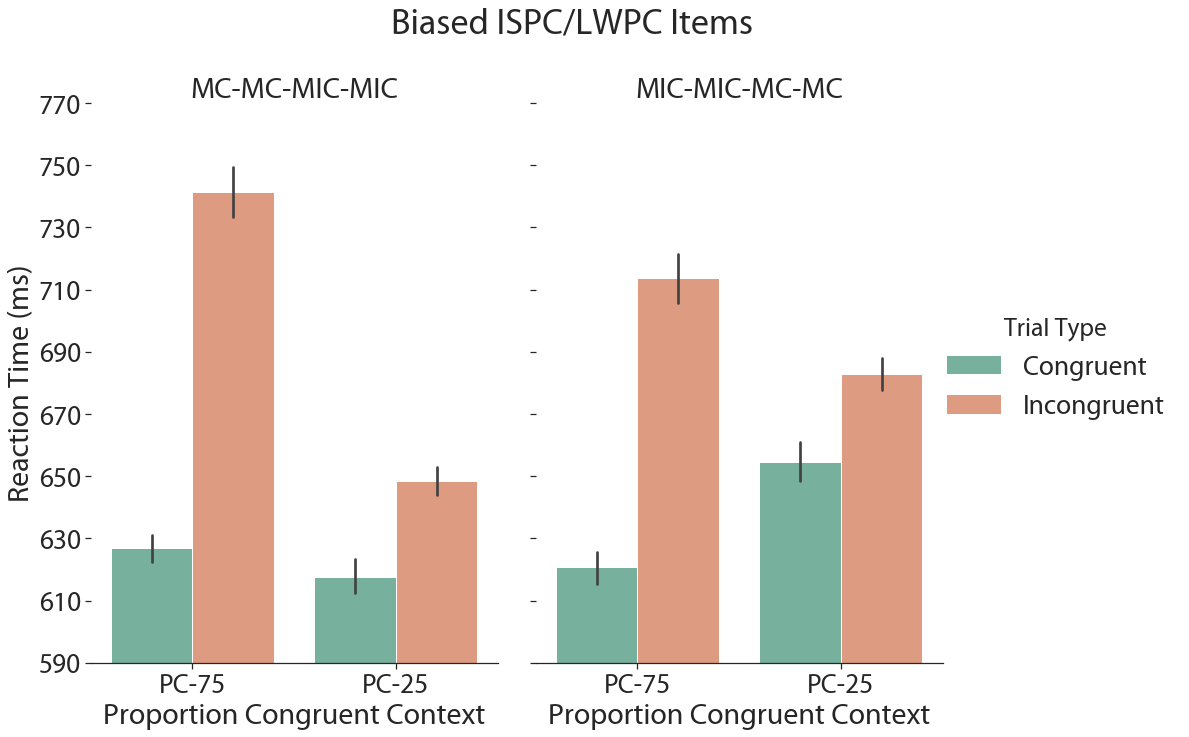

In [21]:
mybargraph("BlockType","RT","Congruency",["PC-75", "PC-25"],"BlockOrder",["MC-MC-MIC-MIC", "MIC-MIC-MC-MC"],RTmeans,"Proportion Congruent Context","Reaction Time (ms)","Biased ISPC/LWPC Items","Trial Type",590,770,"LWPC_RT_maintask.png",20)

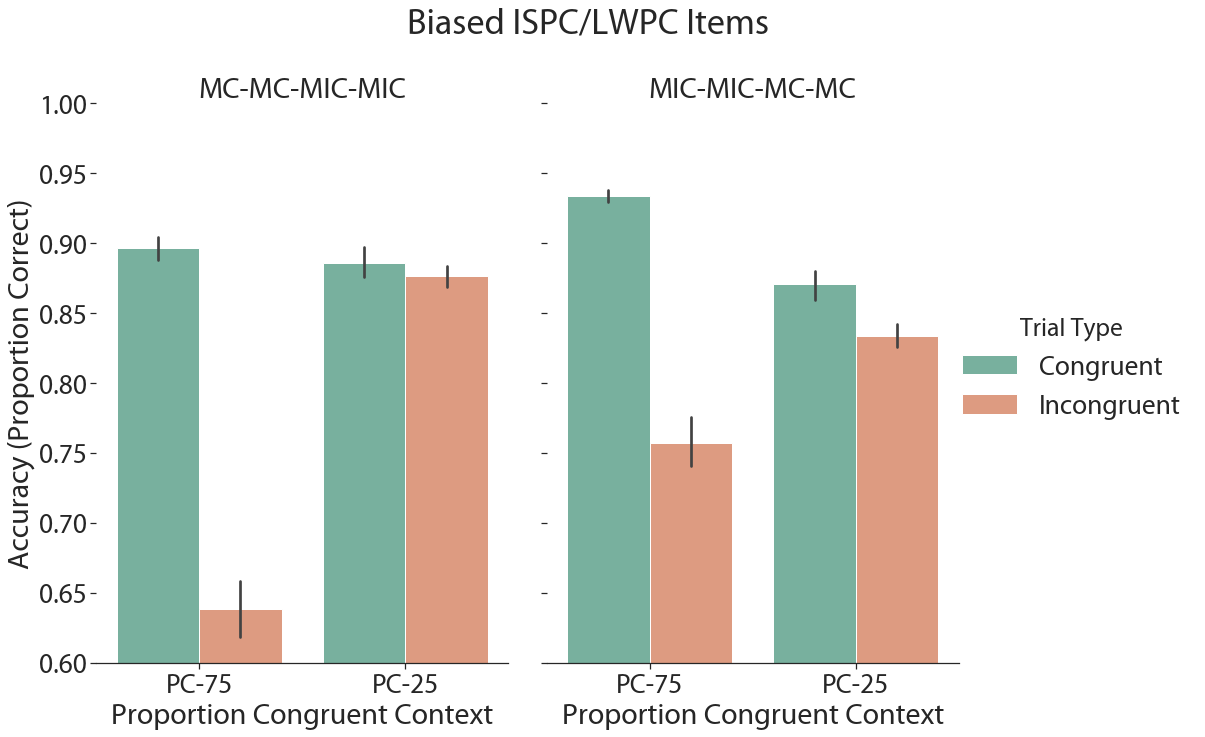

In [22]:
mybargraph("BlockType","Accuracy","Congruency",["PC-75", "PC-25"],"BlockOrder",["MC-MC-MIC-MIC", "MIC-MIC-MC-MC"],ACCmeans,"Proportion Congruent Context","Accuracy (Proportion Correct)","Biased ISPC/LWPC Items","Trial Type",0.60,1.0,"LWPC_ACC_maintask.png",0.05)

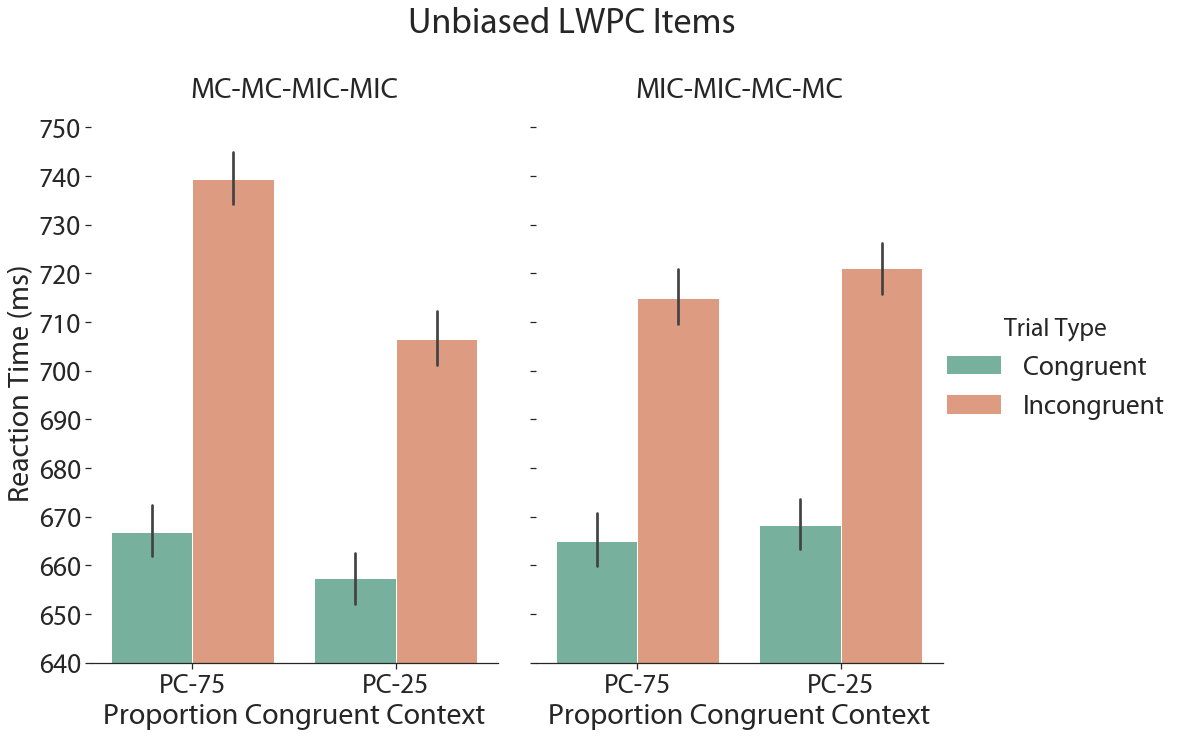

In [23]:
mybargraph("BlockType","RT","Congruency",["PC-75", "PC-25"],"BlockOrder",["MC-MC-MIC-MIC", "MIC-MIC-MC-MC"],RTmeans_PC50,"Proportion Congruent Context","Reaction Time (ms)","Unbiased LWPC Items","Trial Type",640,755,"LWPC_RT_pc50.png",10)

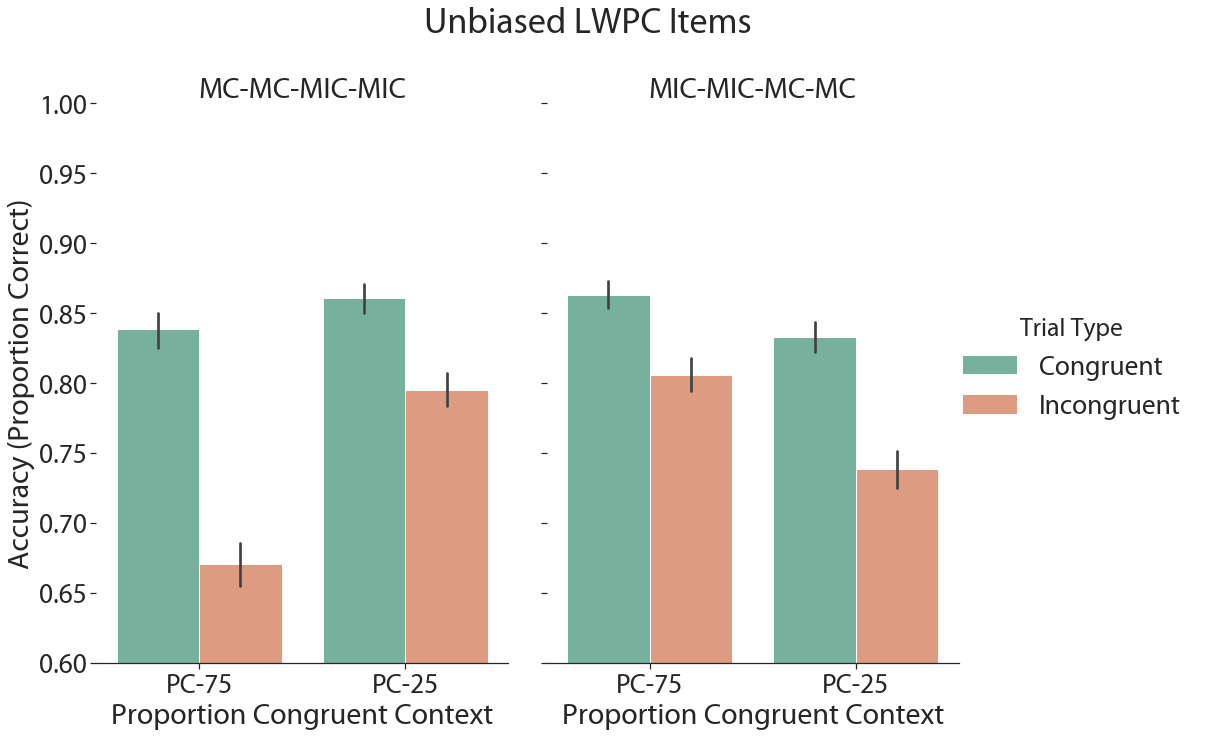

In [24]:
mybargraph("BlockType","Accuracy","Congruency",["PC-75", "PC-25"],"BlockOrder",["MC-MC-MIC-MIC", "MIC-MIC-MC-MC"],ACCmeans_PC50,"Proportion Congruent Context","Accuracy (Proportion Correct)","Unbiased LWPC Items","Trial Type",0.60,1.0,"LWPC_ACC_pc50.png",0.05)

# Creating Variables

##### this is to calculate the interaction effects for later correlation graphs, with overall RT/acc in each condition serving as a correction--

Whenever possible, correlations for difference scores were corrected by dividing the difference score by the overall mean score on the behavioral measure (e.g., the RT interaction metric divided by overall RT for each participant) (see e.g., Hedge et al., 2018; Rouder & Haaf, 2019 for a discussion on the reliability of difference scores)

In [25]:
FBsubslim = len(set(cdat.subject))

In [26]:
#needed to be outside the function because python wasn't recognizing the dfname as an input when dfname = pd.DataFrame()
FB_RT = pd.DataFrame();
FB_ACC = pd.DataFrame();

In [27]:
def create_wide_df(df,dfname,dv,lim1):
    lists = [[] for list in range(0,10)]
    
    for ID in range(1, lim1):
        if ID in range(1,89):
            group = 1
        else: group = 2
        
        sub = df[df.subject == ID]
        lists[0].append(ID)
        submain = sub[sub.Item != 'PC-50']
        LowC_trials = submain[submain.ContextCong == 'LowC'][dv].mean()
        LowIC_trials = submain[submain.ContextCong == 'LowIC'][dv].mean()
        HighC_trials = submain[submain.ContextCong == 'HighC'][dv].mean()
        HighIC_trials = submain[submain.ContextCong == 'HighIC'][dv].mean()
        subtransfer = sub[sub.Item == 'PC-50']
        LowC_trials_T = subtransfer[subtransfer.ContextCong == 'LowC'][dv].mean()
        LowIC_trials_T = subtransfer[subtransfer.ContextCong == 'LowIC'][dv].mean()
        HighC_trials_T = subtransfer[subtransfer.ContextCong == 'HighC'][dv].mean()
        HighIC_trials_T = subtransfer[subtransfer.ContextCong == 'HighIC'][dv].mean()
        lists[1].append(LowC_trials)
        lists[2].append(LowIC_trials)
        lists[3].append(HighC_trials)
        lists[4].append(HighIC_trials)
        lists[5].append(LowC_trials_T)
        lists[6].append(LowIC_trials_T)
        lists[7].append(HighC_trials_T)
        lists[8].append(HighIC_trials_T)
        lists[9].append(group)
        
    dfname['SubjectID'] = lists[0]
    dfname['LowC'] = lists[1]
    dfname['LowIC'] = lists[2]
    dfname['HighC'] = lists[3]
    dfname['HighIC'] = lists[4]
    dfname['LowC_T'] = lists[5]
    dfname['LowIC_T'] = lists[6]
    dfname['HighC_T'] = lists[7]
    dfname['HighIC_T'] = lists[8]
    dfname['population'] = lists[9]

In [28]:
create_wide_df(cdat,FB_RT,'RT',FBsubslim+1);

In [29]:
create_wide_df(adat,FB_ACC,'Accuracy',(FBsubslim+1));

In [30]:
def calc_PCbycong_interaction(df, transfer, RTacc):
    if transfer == 0:
        InteractionEffect = (df.LowIC - df.LowC) - (df.HighIC - df.HighC);
    elif transfer == 1:
        InteractionEffect = (df.LowIC_T - df.LowC_T) - (df.HighIC_T - df.HighC_T);
    
    InteractionEffect = InteractionEffect.reset_index();
    
    if RTacc == 1:
        InteractionEffect.columns = ['index', 'RTs']
    elif RTacc == 0:
        InteractionEffect.columns = ['index', 'ACC']
    
    return InteractionEffect

In [31]:
SC_RT_FB = calc_PCbycong_interaction(FB_RT, 0, 1)

In [32]:
SCT_RT_FB = calc_PCbycong_interaction(FB_RT, 1, 1)

In [33]:
SC_ACC_FB = calc_PCbycong_interaction(FB_ACC, 0, 0)

In [34]:
SCT_ACC_FB = calc_PCbycong_interaction(FB_ACC, 1, 0)

The average biased and LWPC effects are...

In [35]:
SC_RT_FB.RTs.mean()
SC_ACC_FB.ACC.mean()*100
SCT_RT_FB.RTs.mean()
SCT_ACC_FB.ACC.mean()*100

74.0853390315787

-19.251281100006974

10.0130899403234

-3.131188118811882

In [36]:
def means_overall_group(df, filternum, filter1, dv):
    if filternum == 0:
        X = df.groupby(['subject'])[dv].mean().reset_index();       
    elif filternum == 1:
        X = df.loc[df['Item'] == filter1].groupby(['subject'])[dv].mean().reset_index();
    elif filternum == 2:
        X = df.loc[df['Item'] != filter1].groupby(['subject'])[dv].mean().reset_index();
        
    X = X.drop('subject',1)
    
    return X

In [37]:
overallRT = means_overall_group(cdat, 0, 0, 'RT')
overallRT = overallRT.reset_index();

In [38]:
overallACC = means_overall_group(adat, 0, 0, 'Accuracy')
overallACC = overallACC.reset_index();

In [39]:
overallMainRT = means_overall_group(cdat, 2, 'PC-50', 'RT') #main refers to pc-85/15 here
overallMainRT = overallMainRT.reset_index();

In [40]:
overallMainACC = means_overall_group(adat, 2, 'PC-50', 'Accuracy') #main refers to pc-85/15 here
overallMainACC = overallMainACC.reset_index();

In [41]:
overallRT_T = means_overall_group(cdat, 1, 'PC-50', 'RT') #_T refers to pc-50 here
overallRT_T = overallRT_T.reset_index();

In [42]:
overallACC_T = means_overall_group(adat,  1, 'PC-50', 'Accuracy') #_T refers to pc-50 here
overallACC_T = overallACC_T.reset_index();

### Now that we've looked at our ANOVAs, let's calculate the means to report in the manuscript

Biased Items - RT

In [43]:
#main effect of congruency for RT
maineffectcongruency=cdat.loc[cdat['Item']!='PC-50'].groupby(['subject','Congruency'])['RT'].mean()
grpmean = pd.Series.mean(maineffectcongruency, level=1)
round(grpmean), grpmean[1] - grpmean[0]

#main effect of PC for RT
maineffectPC=cdat.loc[cdat['Item']!='PC-50'].groupby(['subject','BlockType'])['RT'].mean()
grpmean = pd.Series.mean(maineffectPC, level=1)
round(grpmean), grpmean[1] - grpmean[0]

#interaction of Pc x Cong for biased items
IntCong=cdat.loc[cdat['Item']!='PC-50'].groupby(['subject','ContextCong'])['RT'].mean().reset_index()
Congdiff25 = IntCong.loc[IntCong['ContextCong'] == 'HighIC'].reset_index()['RT'] - IntCong.loc[IntCong['ContextCong'] == 'HighC'].reset_index()['RT']
Congdiff75 = IntCong.loc[IntCong['ContextCong'] == 'LowIC'].reset_index()['RT'] - IntCong.loc[IntCong['ContextCong'] == 'LowC'].reset_index()['RT']
round(Congdiff25.mean()), round(Congdiff75.mean()), round(SC_RT_FB.RTs.mean())

#PC x cong x BO
PCCongBO=cdat.loc[cdat['Item']!='PC-50'].groupby(['subject','ContextCong','BlockOrder'])['RT'].mean().reset_index()
MC_BO25 = PCCongBO.loc[PCCongBO['ContextCong'] == 'HighIC'].loc[PCCongBO['BlockOrder'] == 'CongFirst'].reset_index()['RT'] - PCCongBO.loc[PCCongBO['ContextCong'] == 'HighC'].loc[PCCongBO['BlockOrder'] == 'CongFirst'].reset_index()['RT']
MC_BO75 = PCCongBO.loc[PCCongBO['ContextCong'] == 'LowIC'].loc[PCCongBO['BlockOrder'] == 'CongFirst'].reset_index()['RT'] - PCCongBO.loc[PCCongBO['ContextCong'] == 'LowC'].loc[PCCongBO['BlockOrder'] == 'CongFirst'].reset_index()['RT']
MIC_BO25 = PCCongBO.loc[PCCongBO['ContextCong'] == 'HighIC'].loc[PCCongBO['BlockOrder'] == 'IncongFirst'].reset_index()['RT'] - PCCongBO.loc[PCCongBO['ContextCong'] == 'HighC'].loc[PCCongBO['BlockOrder'] == 'IncongFirst'].reset_index()['RT']
MIC_BO75 = PCCongBO.loc[PCCongBO['ContextCong'] == 'LowIC'].loc[PCCongBO['BlockOrder'] == 'IncongFirst'].reset_index()['RT'] - PCCongBO.loc[PCCongBO['ContextCong'] == 'LowC'].loc[PCCongBO['BlockOrder'] == 'IncongFirst'].reset_index()['RT']
round(MC_BO75.mean() - MC_BO25.mean()), round(MIC_BO75.mean() - MIC_BO25.mean())

#congruency x block order
CongBO=cdat.loc[cdat['Item']!='PC-50'].groupby(['subject','Congruency', 'BlockOrder'])['RT'].mean().reset_index()
CongFirstBO = CongBO.loc[CongBO['Congruency'] == 'Incongruent'].loc[CongBO['BlockOrder'] == 'CongFirst'].reset_index()['RT'] - CongBO.loc[CongBO['Congruency'] == 'Congruent'].loc[CongBO['BlockOrder'] == 'CongFirst'].reset_index()['RT']
IncongFirstBO = CongBO.loc[CongBO['Congruency'] == 'Incongruent'].loc[CongBO['BlockOrder'] == 'IncongFirst'].reset_index()['RT'] - CongBO.loc[CongBO['Congruency'] == 'Congruent'].loc[CongBO['BlockOrder'] == 'IncongFirst'].reset_index()['RT']
round(CongFirstBO.mean()), round(IncongFirstBO.mean())

#PC x block order
PCBO=cdat.loc[cdat['Item']!='PC-50'].groupby(['subject','BlockType', 'BlockOrder'])['RT'].mean().reset_index()
BO25 = PCBO.loc[PCBO['BlockType'] == 'PC-25'].loc[PCBO['BlockOrder'] == 'CongFirst'].reset_index()['RT'] - PCBO.loc[PCBO['BlockType'] == 'PC-75'].loc[PCBO['BlockOrder'] == 'CongFirst'].reset_index()['RT']
BO75 = PCBO.loc[PCBO['BlockType'] == 'PC-25'].loc[PCBO['BlockOrder'] == 'IncongFirst'].reset_index()['RT'] - PCBO.loc[PCBO['BlockType'] == 'PC-75'].loc[PCBO['BlockOrder'] == 'IncongFirst'].reset_index()['RT']
round(BO25.mean()), round(BO75.mean())

(Congruency
 Congruent      625.0
 Incongruent    671.0
 Name: RT, dtype: float64, 45.774211005951884)

(BlockType
 PC-25    662.0
 PC-75    632.0
 Name: RT, dtype: float64, -30.20356402117136)

(29, 103, 74)

(84, 65)

(30, 61)

(9, 50)

Biased Items - Accuracy

In [44]:
#main effect of congruency
maineffectcongruency=adat.loc[adat['Item']!='PC-50'].groupby(['subject','Congruency'])['Accuracy'].mean()
grpmean = pd.Series.mean(maineffectcongruency, level=1)
grpmean, grpmean[1] - grpmean[0]

#main effect of PC
maineffectPC=adat.loc[adat['Item']!='PC-50'].groupby(['subject','BlockType'])['Accuracy'].mean()
grpmean = pd.Series.mean(maineffectPC, level=1)
grpmean, grpmean[1] - grpmean[0]

#main effect of block order
maineffectBO=adat.loc[adat['Item']!='PC-50'].groupby(['subject','BlockOrder'])['Accuracy'].mean()
grpmean = pd.Series.mean(maineffectBO, level=1)
grpmean, grpmean[1] - grpmean[0]

#interaction of Pc x Cong for biased items
IntCong=adat.loc[adat['Item']!='PC-50'].groupby(['subject','ContextCong'])['Accuracy'].mean().reset_index()
Congdiff25 = IntCong.loc[IntCong['ContextCong'] == 'HighIC'].reset_index()['Accuracy'] - IntCong.loc[IntCong['ContextCong'] == 'HighC'].reset_index()['Accuracy']
Congdiff75 = IntCong.loc[IntCong['ContextCong'] == 'LowIC'].reset_index()['Accuracy'] - IntCong.loc[IntCong['ContextCong'] == 'LowC'].reset_index()['Accuracy']
Congdiff25.mean(), Congdiff75.mean(), SC_ACC_FB.ACC.mean()

#PC x cong x BO
PCCongBO=adat.loc[adat['Item']!='PC-50'].groupby(['subject','ContextCong','BlockOrder'])['Accuracy'].mean().reset_index()
MC_BO25 = PCCongBO.loc[PCCongBO['ContextCong'] == 'HighIC'].loc[PCCongBO['BlockOrder'] == 'CongFirst'].reset_index()['Accuracy'] - PCCongBO.loc[PCCongBO['ContextCong'] == 'HighC'].loc[PCCongBO['BlockOrder'] == 'CongFirst'].reset_index()['Accuracy']
MC_BO75 = PCCongBO.loc[PCCongBO['ContextCong'] == 'LowIC'].loc[PCCongBO['BlockOrder'] == 'CongFirst'].reset_index()['Accuracy'] - PCCongBO.loc[PCCongBO['ContextCong'] == 'LowC'].loc[PCCongBO['BlockOrder'] == 'CongFirst'].reset_index()['Accuracy']
MIC_BO25 = PCCongBO.loc[PCCongBO['ContextCong'] == 'HighIC'].loc[PCCongBO['BlockOrder'] == 'IncongFirst'].reset_index()['Accuracy'] - PCCongBO.loc[PCCongBO['ContextCong'] == 'HighC'].loc[PCCongBO['BlockOrder'] == 'IncongFirst'].reset_index()['Accuracy']
MIC_BO75 = PCCongBO.loc[PCCongBO['ContextCong'] == 'LowIC'].loc[PCCongBO['BlockOrder'] == 'IncongFirst'].reset_index()['Accuracy'] - PCCongBO.loc[PCCongBO['ContextCong'] == 'LowC'].loc[PCCongBO['BlockOrder'] == 'IncongFirst'].reset_index()['Accuracy']
(MC_BO75.mean() - MC_BO25.mean()), (MIC_BO75.mean() - MIC_BO25.mean())

#congruency x block order
CongBO=adat.loc[adat['Item']!='PC-50'].groupby(['subject','Congruency', 'BlockOrder'])['Accuracy'].mean().reset_index()
CongFirstBO = CongBO.loc[CongBO['Congruency'] == 'Incongruent'].loc[CongBO['BlockOrder'] == 'CongFirst'].reset_index()['Accuracy'] - CongBO.loc[CongBO['Congruency'] == 'Congruent'].loc[CongBO['BlockOrder'] == 'CongFirst'].reset_index()['Accuracy']
IncongFirstBO = CongBO.loc[CongBO['Congruency'] == 'Incongruent'].loc[CongBO['BlockOrder'] == 'IncongFirst'].reset_index()['Accuracy'] - CongBO.loc[CongBO['Congruency'] == 'Congruent'].loc[CongBO['BlockOrder'] == 'IncongFirst'].reset_index()['Accuracy']
CongFirstBO.mean(), IncongFirstBO.mean()

#PC x block order
PCBO=adat.loc[adat['Item']!='PC-50'].groupby(['subject','BlockType', 'BlockOrder'])['Accuracy'].mean().reset_index()
BO25 = PCBO.loc[PCBO['BlockType'] == 'PC-25'].loc[PCBO['BlockOrder'] == 'CongFirst'].reset_index()['Accuracy'] - PCBO.loc[PCBO['BlockType'] == 'PC-75'].loc[PCBO['BlockOrder'] == 'CongFirst'].reset_index()['Accuracy']
BO75 = PCBO.loc[PCBO['BlockType'] == 'PC-25'].loc[PCBO['BlockOrder'] == 'IncongFirst'].reset_index()['Accuracy'] - PCBO.loc[PCBO['BlockType'] == 'PC-75'].loc[PCBO['BlockOrder'] == 'IncongFirst'].reset_index()['Accuracy']
BO25.mean(), BO75.mean()


(Congruency
 Congruent      0.911291
 Incongruent    0.838490
 Name: Accuracy, dtype: float64, -0.07280139778683736)

(BlockType
 PC-25    0.856909
 PC-75    0.892873
 Name: Accuracy, dtype: float64, 0.03596389050669768)

(BlockOrder
 CongFirst      0.873329
 IncongFirst    0.876392
 Name: Accuracy, dtype: float64, 0.0030631846736930424)

(-0.023517749901453843, -0.21603056090152328, -0.19251281100006973)

(-0.24761668204291146, -0.1395488961142311)

(-0.04344919786096256, -0.10101370645345518)

(0.007501485442661917, -0.0777412906910337)

Unbiased Items - RT

In [45]:
#main effect of congruency for RT
maineffectcongruency=cdat.loc[cdat['Item']=='PC-50'].groupby(['subject','Congruency'])['RT'].mean()
grpmean = pd.Series.mean(maineffectcongruency, level=1)
round(grpmean), grpmean[1] - grpmean[0]

#main effect of PC for RT
maineffectPC=cdat.loc[cdat['Item']=='PC-50'].groupby(['subject','BlockType'])['RT'].mean()
grpmean = pd.Series.mean(maineffectPC, level=1)
round(grpmean), grpmean[1] - grpmean[0]

#interaction of Pc x Cong
IntCong=cdat.loc[cdat['Item']=='PC-50'].groupby(['subject','ContextCong'])['RT'].mean().reset_index()
Congdiff25 = IntCong.loc[IntCong['ContextCong'] == 'HighIC'].reset_index()['RT'] - IntCong.loc[IntCong['ContextCong'] == 'HighC'].reset_index()['RT']
Congdiff75 = IntCong.loc[IntCong['ContextCong'] == 'LowIC'].reset_index()['RT'] - IntCong.loc[IntCong['ContextCong'] == 'LowC'].reset_index()['RT']
round(Congdiff25.mean()), round(Congdiff75.mean()), round(SCT_RT_FB.RTs.mean())

#PC x cong x BO
PCCongBO=cdat.loc[cdat['Item']=='PC-50'].groupby(['subject','ContextCong','BlockOrder'])['RT'].mean().reset_index()
MC_BO25 = PCCongBO.loc[PCCongBO['ContextCong'] == 'HighIC'].loc[PCCongBO['BlockOrder'] == 'CongFirst'].reset_index()['RT'] - PCCongBO.loc[PCCongBO['ContextCong'] == 'HighC'].loc[PCCongBO['BlockOrder'] == 'CongFirst'].reset_index()['RT']
MC_BO75 = PCCongBO.loc[PCCongBO['ContextCong'] == 'LowIC'].loc[PCCongBO['BlockOrder'] == 'CongFirst'].reset_index()['RT'] - PCCongBO.loc[PCCongBO['ContextCong'] == 'LowC'].loc[PCCongBO['BlockOrder'] == 'CongFirst'].reset_index()['RT']
MIC_BO25 = PCCongBO.loc[PCCongBO['ContextCong'] == 'HighIC'].loc[PCCongBO['BlockOrder'] == 'IncongFirst'].reset_index()['RT'] - PCCongBO.loc[PCCongBO['ContextCong'] == 'HighC'].loc[PCCongBO['BlockOrder'] == 'IncongFirst'].reset_index()['RT']
MIC_BO75 = PCCongBO.loc[PCCongBO['ContextCong'] == 'LowIC'].loc[PCCongBO['BlockOrder'] == 'IncongFirst'].reset_index()['RT'] - PCCongBO.loc[PCCongBO['ContextCong'] == 'LowC'].loc[PCCongBO['BlockOrder'] == 'IncongFirst'].reset_index()['RT']
round(MC_BO75.mean() - MC_BO25.mean()), round(MIC_BO75.mean() - MIC_BO25.mean())

#PC x block order
PCBO=cdat.loc[cdat['Item']=='PC-50'].groupby(['subject','BlockType', 'BlockOrder'])['RT'].mean().reset_index()
BO25 = PCBO.loc[PCBO['BlockType'] == 'PC-25'].loc[PCBO['BlockOrder'] == 'CongFirst'].reset_index()['RT'] - PCBO.loc[PCBO['BlockType'] == 'PC-75'].loc[PCBO['BlockOrder'] == 'CongFirst'].reset_index()['RT']
BO75 = PCBO.loc[PCBO['BlockType'] == 'PC-25'].loc[PCBO['BlockOrder'] == 'IncongFirst'].reset_index()['RT'] - PCBO.loc[PCBO['BlockType'] == 'PC-75'].loc[PCBO['BlockOrder'] == 'IncongFirst'].reset_index()['RT']
round(BO25.mean()), round(BO75.mean())

#congruency x block order
CongBO=cdat.loc[cdat['Item']=='PC-50'].groupby(['subject','Congruency', 'BlockOrder'])['RT'].mean().reset_index()
CongFirstBO = CongBO.loc[CongBO['Congruency'] == 'Incongruent'].loc[CongBO['BlockOrder'] == 'CongFirst'].reset_index()['RT'] - CongBO.loc[CongBO['Congruency'] == 'Congruent'].loc[CongBO['BlockOrder'] == 'CongFirst'].reset_index()['RT']
IncongFirstBO = CongBO.loc[CongBO['Congruency'] == 'Incongruent'].loc[CongBO['BlockOrder'] == 'IncongFirst'].reset_index()['RT'] - CongBO.loc[CongBO['Congruency'] == 'Congruent'].loc[CongBO['BlockOrder'] == 'IncongFirst'].reset_index()['RT']
round(CongFirstBO.mean()), round(IncongFirstBO.mean())

(Congruency
 Congruent      664.0
 Incongruent    719.0
 Name: RT, dtype: float64, 55.11453407911415)

(BlockType
 PC-25    687.0
 PC-75    693.0
 Name: RT, dtype: float64, 6.532852335335065)

(51, 61, 10)

(23, -3)

(-17, 4)

(59, 51)

Unbiased Items - Accuracy

In [46]:
#main effect of congruency
maineffectcongruency=adat.loc[adat['Item']=='PC-50'].groupby(['subject','Congruency'])['Accuracy'].mean()
grpmean = pd.Series.mean(maineffectcongruency, level=1)
grpmean, grpmean[1] - grpmean[0]

#main effect of PC
maineffectPC=adat.loc[adat['Item']=='PC-50'].groupby(['subject','BlockType'])['Accuracy'].mean()
grpmean = pd.Series.mean(maineffectPC, level=1)
grpmean, grpmean[1] - grpmean[0]

#interaction of Pc x Cong
IntCong=adat.loc[adat['Item']=='PC-50'].groupby(['subject','ContextCong'])['Accuracy'].mean().reset_index()
Congdiff25 = IntCong.loc[IntCong['ContextCong'] == 'HighIC'].reset_index()['Accuracy'] - IntCong.loc[IntCong['ContextCong'] == 'HighC'].reset_index()['Accuracy']
Congdiff75 = IntCong.loc[IntCong['ContextCong'] == 'LowIC'].reset_index()['Accuracy'] - IntCong.loc[IntCong['ContextCong'] == 'LowC'].reset_index()['Accuracy']
Congdiff25.mean(), Congdiff75.mean(), SCT_ACC_FB.ACC.mean()

#PC x cong x BO
PCCongBO=adat.loc[adat['Item']=='PC-50'].groupby(['subject','ContextCong','BlockOrder'])['Accuracy'].mean().reset_index()
MC_BO25 = PCCongBO.loc[PCCongBO['ContextCong'] == 'HighIC'].loc[PCCongBO['BlockOrder'] == 'CongFirst'].reset_index()['Accuracy'] - PCCongBO.loc[PCCongBO['ContextCong'] == 'HighC'].loc[PCCongBO['BlockOrder'] == 'CongFirst'].reset_index()['Accuracy']
MC_BO75 = PCCongBO.loc[PCCongBO['ContextCong'] == 'LowIC'].loc[PCCongBO['BlockOrder'] == 'CongFirst'].reset_index()['Accuracy'] - PCCongBO.loc[PCCongBO['ContextCong'] == 'LowC'].loc[PCCongBO['BlockOrder'] == 'CongFirst'].reset_index()['Accuracy']
MIC_BO25 = PCCongBO.loc[PCCongBO['ContextCong'] == 'HighIC'].loc[PCCongBO['BlockOrder'] == 'IncongFirst'].reset_index()['Accuracy'] - PCCongBO.loc[PCCongBO['ContextCong'] == 'HighC'].loc[PCCongBO['BlockOrder'] == 'IncongFirst'].reset_index()['Accuracy']
MIC_BO75 = PCCongBO.loc[PCCongBO['ContextCong'] == 'LowIC'].loc[PCCongBO['BlockOrder'] == 'IncongFirst'].reset_index()['Accuracy'] - PCCongBO.loc[PCCongBO['ContextCong'] == 'LowC'].loc[PCCongBO['BlockOrder'] == 'IncongFirst'].reset_index()['Accuracy']
(MC_BO75.mean() - MC_BO25.mean()), (MIC_BO75.mean() - MIC_BO25.mean())

#PC x block order
PCBO=adat.loc[adat['Item']=='PC-50'].groupby(['subject','BlockType', 'BlockOrder'])['Accuracy'].mean().reset_index()
BO25 = PCBO.loc[PCBO['BlockType'] == 'PC-25'].loc[PCBO['BlockOrder'] == 'CongFirst'].reset_index()['Accuracy'] - PCBO.loc[PCBO['BlockType'] == 'PC-75'].loc[PCBO['BlockOrder'] == 'CongFirst'].reset_index()['Accuracy']
BO75 = PCBO.loc[PCBO['BlockType'] == 'PC-25'].loc[PCBO['BlockOrder'] == 'IncongFirst'].reset_index()['Accuracy'] - PCBO.loc[PCBO['BlockType'] == 'PC-75'].loc[PCBO['BlockOrder'] == 'IncongFirst'].reset_index()['Accuracy']
BO25.mean(), BO75.mean()

#congruency x block order
CongBO=adat.loc[adat['Item']=='PC-50'].groupby(['subject','Congruency', 'BlockOrder'])['Accuracy'].mean().reset_index()
CongFirstBO = CongBO.loc[CongBO['Congruency'] == 'Incongruent'].loc[CongBO['BlockOrder'] == 'CongFirst'].reset_index()['Accuracy'] - CongBO.loc[CongBO['Congruency'] == 'Congruent'].loc[CongBO['BlockOrder'] == 'CongFirst'].reset_index()['Accuracy']
IncongFirstBO = CongBO.loc[CongBO['Congruency'] == 'Incongruent'].loc[CongBO['BlockOrder'] == 'IncongFirst'].reset_index()['Accuracy'] - CongBO.loc[CongBO['Congruency'] == 'Congruent'].loc[CongBO['BlockOrder'] == 'IncongFirst'].reset_index()['Accuracy']
CongFirstBO.mean(), (IncongFirstBO.mean())

(Congruency
 Congruent      0.848453
 Incongruent    0.752723
 Name: Accuracy, dtype: float64, -0.0957301980198012)

(BlockType
 PC-25    0.806126
 PC-75    0.795050
 Name: Accuracy, dtype: float64, -0.011076732673267475)

(-0.08007425742574258, -0.1113861386138614, -0.03131188118811882)

(-0.10227272727272724, 0.0368932038834951)

(0.07310606060606065, -0.048543689320388356)

(-0.1165404040404041, -0.07572815533980586)

Analysis of Early / First Two Learning Phase blocks

In [47]:
#cong x block order - biased RT
CongBO=cdat.loc[cdat['Time']=='Early'].loc[cdat['Item']!='PC-50'].groupby(['subject','Congruency', 'BlockOrder'])['RT'].mean().reset_index()
CongFirstBO = CongBO.loc[CongBO['Congruency'] == 'Incongruent'].loc[CongBO['BlockOrder'] == 'CongFirst'].reset_index()['RT'] - CongBO.loc[CongBO['Congruency'] == 'Congruent'].loc[CongBO['BlockOrder'] == 'CongFirst'].reset_index()['RT']
IncongFirstBO = CongBO.loc[CongBO['Congruency'] == 'Incongruent'].loc[CongBO['BlockOrder'] == 'IncongFirst'].reset_index()['RT'] - CongBO.loc[CongBO['Congruency'] == 'Congruent'].loc[CongBO['BlockOrder'] == 'IncongFirst'].reset_index()['RT']
round(CongFirstBO.mean()), round(IncongFirstBO.mean())

#cong x block order - biased ACC
CongBO=adat.loc[adat['Time']=='Early'].loc[adat['Item']!='PC-50'].groupby(['subject','Congruency', 'BlockOrder'])['Accuracy'].mean().reset_index()
CongFirstBO = CongBO.loc[CongBO['Congruency'] == 'Incongruent'].loc[CongBO['BlockOrder'] == 'CongFirst'].reset_index()['Accuracy'] - CongBO.loc[CongBO['Congruency'] == 'Congruent'].loc[CongBO['BlockOrder'] == 'CongFirst'].reset_index()['Accuracy']
IncongFirstBO = CongBO.loc[CongBO['Congruency'] == 'Incongruent'].loc[CongBO['BlockOrder'] == 'IncongFirst'].reset_index()['Accuracy'] - CongBO.loc[CongBO['Congruency'] == 'Congruent'].loc[CongBO['BlockOrder'] == 'IncongFirst'].reset_index()['Accuracy']
CongFirstBO.mean()*100, IncongFirstBO.mean()*100

#cong x block order - unbiased RT
CongBO=cdat.loc[cdat['Time']=='Early'].loc[cdat['Item']=='PC-50'].groupby(['subject','Congruency', 'BlockOrder'])['RT'].mean().reset_index()
CongFirstBO = CongBO.loc[CongBO['Congruency'] == 'Incongruent'].loc[CongBO['BlockOrder'] == 'CongFirst'].reset_index()['RT'] - CongBO.loc[CongBO['Congruency'] == 'Congruent'].loc[CongBO['BlockOrder'] == 'CongFirst'].reset_index()['RT']
IncongFirstBO = CongBO.loc[CongBO['Congruency'] == 'Incongruent'].loc[CongBO['BlockOrder'] == 'IncongFirst'].reset_index()['RT'] - CongBO.loc[CongBO['Congruency'] == 'Congruent'].loc[CongBO['BlockOrder'] == 'IncongFirst'].reset_index()['RT']
round(CongFirstBO.mean()), round(IncongFirstBO.mean())

#cong x block order - unbiased ACC
CongBO=adat.loc[adat['Time']=='Early'].loc[adat['Item']=='PC-50'].groupby(['subject','Congruency', 'BlockOrder'])['Accuracy'].mean().reset_index()
CongFirstBO = CongBO.loc[CongBO['Congruency'] == 'Incongruent'].loc[CongBO['BlockOrder'] == 'CongFirst'].reset_index()['Accuracy'] - CongBO.loc[CongBO['Congruency'] == 'Congruent'].loc[CongBO['BlockOrder'] == 'CongFirst'].reset_index()['Accuracy']
IncongFirstBO = CongBO.loc[CongBO['Congruency'] == 'Incongruent'].loc[CongBO['BlockOrder'] == 'IncongFirst'].reset_index()['Accuracy'] - CongBO.loc[CongBO['Congruency'] == 'Congruent'].loc[CongBO['BlockOrder'] == 'IncongFirst'].reset_index()['Accuracy']
CongFirstBO.mean()*100, IncongFirstBO.mean()*100

(115, 28)

(-25.756392969507715, -3.656124235465315)

(73, 53)

(-16.767676767676765, -9.417475728155338)

### How reliable are the control-learning effects we observed?

We can calculate this as a total of all participants for each context, namely Run 1 vs. Run 2 for version 10 folks and Run 3 vs. Run 4 for version 9 folks for the MC context congruency effect and Run 3 vs. Run 4 for version 10 folks and Run 1 vs. Run 2 for version 9 folks for the MIC context congruency effect. We'll do this for each "version" group and then combine to look at it across all participants.

We could also do this separately for the biased and unbiased items/congruency effects.

In [48]:
import matplotlib.ticker as ticker

In [49]:
def my_corr_graphs(x, y, ylabel, xlabel, figname, selectsubs, corrxvalue, corryvalue, xmin, xmax, ymin, ymax,stepsize):
    plot = sns.jointplot(x=x, y=y, kind="reg", height=11, ratio=5, color = 'g');
    plt.ylabel(ylabel, fontweight="bold");
    plt.xlabel(xlabel, fontweight="bold");
    plot.ax_marg_x.set_xlim(xmin, xmax)
    plot.ax_marg_y.set_ylim(ymin, ymax)
    plot.ax_joint.xaxis.set_major_locator(ticker.MultipleLocator(stepsize))
    plot.ax_joint.yaxis.set_major_locator(ticker.MultipleLocator(stepsize))
    plb.savefig(figurepath+figname, dpi = 300)
    regstat = stats.linregress(x,y)
    
    if selectsubs == 1:
        corrx = x/corrxvalue
        corry = y/corryvalue
    else:
        corrx = x.reset_index(drop=True)/corrxvalue
        corry = y.reset_index(drop=True)/corryvalue
        
    corrstat = stats.linregress(corrx,corry)
    return regstat, corrstat

In [50]:
def cong_bias(df, dv, ItemFilter, VersionFilter, RunFilter, bias):
    if bias == 1:
        sub_means = df.loc[df['Item']==ItemFilter].loc[df['Version']==VersionFilter].loc[df['RunCounter']==RunFilter].groupby(['subject','Congruency'])[dv].mean().reset_index()
    elif bias == 2:
        sub_means = df.loc[df['Item']!=ItemFilter].loc[df['Version']==VersionFilter].loc[df['RunCounter']==RunFilter].groupby(['subject','Congruency'])[dv].mean().reset_index()
    
    Congdiff = sub_means.loc[sub_means['Congruency']=='Incongruent'].reset_index()[dv] - sub_means.loc[sub_means['Congruency']=='Congruent'].reset_index()[dv]
    return sub_means, Congdiff

In [51]:
RTv9r1bias, RTv9r1biascong = cong_bias(cdat, 'RT', 'PC-50', 9, 1, 2)
RTv9r2bias, RTv9r2biascong = cong_bias(cdat, 'RT', 'PC-50', 9, 2, 2)
RTv9r3bias, RTv9r3biascong = cong_bias(cdat, 'RT', 'PC-50', 9, 3, 2)
RTv9r4bias, RTv9r4biascong = cong_bias(cdat, 'RT', 'PC-50', 9, 4, 2) 

RTv10r1bias, RTv10r1biascong = cong_bias(cdat, 'RT', 'PC-50', 10, 1, 2)
RTv10r2bias, RTv10r2biascong = cong_bias(cdat, 'RT', 'PC-50', 10, 2, 2)
RTv10r3bias, RTv10r3biascong = cong_bias(cdat, 'RT', 'PC-50', 10, 3, 2)
RTv10r4bias, RTv10r4biascong = cong_bias(cdat, 'RT', 'PC-50', 10, 4, 2)

RTv9r1UB, RTv9r1UBcong = cong_bias(cdat, 'RT', 'PC-50', 9, 1, 1) 
RTv9r2UB, RTv9r2UBcong = cong_bias(cdat, 'RT', 'PC-50', 9, 2, 1)
RTv9r3UB, RTv9r3UBcong = cong_bias(cdat, 'RT', 'PC-50', 9, 3, 1)
RTv9r4UB, RTv9r4UBcong = cong_bias(cdat, 'RT', 'PC-50', 9, 4, 1)

RTv10r1UB, RTv10r1UBcong = cong_bias(cdat, 'RT', 'PC-50', 10, 1, 1)
RTv10r2UB, RTv10r2UBcong = cong_bias(cdat, 'RT', 'PC-50', 10, 2, 1)
RTv10r3UB, RTv10r3UBcong = cong_bias(cdat, 'RT', 'PC-50', 10, 3, 1)
RTv10r4UB, RTv10r4UBcong = cong_bias(cdat, 'RT', 'PC-50', 10, 4, 1)

In [52]:
#subject 93 only has congruent trials, suggesting they got all the incongruent trials on run 4 wrong
#because corr is btwn r3 and r4, have to exclude that sub from r3 too
RTv9r4biascong = RTv9r4bias.loc[RTv9r4bias['subject']!=93].loc[RTv9r4bias['Congruency']=='Incongruent'].reset_index()['RT'] - RTv9r4bias.loc[RTv9r4bias['subject']!=93].loc[RTv9r4bias['Congruency']=='Congruent'].reset_index()['RT']
RTv9r3biascong = RTv9r3bias.loc[RTv9r3bias['subject']!=93].loc[RTv9r3bias['Congruency']=='Incongruent'].reset_index()['RT'] - RTv9r3bias.loc[RTv9r3bias['subject']!=93].loc[RTv9r3bias['Congruency']=='Congruent'].reset_index()['RT']

In [53]:
#subject 36 only has congruent trials, suggesting they got all the incongruent trials on run 1 wrong
#because corr is btwn r1 and r2, have to exclude that sub from r2 too
RTv9r1UBcong = RTv9r1UB.loc[RTv9r1UB['subject']!=36].loc[RTv9r1UB['Congruency']=='Incongruent'].reset_index()['RT'] - RTv9r1UB.loc[RTv9r1UB['subject']!=36].loc[RTv9r1UB['Congruency']=='Congruent'].reset_index()['RT']
RTv9r2UBcong = RTv9r2UB.loc[RTv9r2UB['subject']!=36].loc[RTv9r2UB['Congruency']=='Incongruent'].reset_index()['RT'] - RTv9r2UB.loc[RTv9r2UB['subject']!=36].loc[RTv9r2UB['Congruency']=='Congruent'].reset_index()['RT']

In [54]:
#subject 105 only has congruent trials, suggesting they got all the incongruent trials on run 1 wrong
#because corr is btwn r1 and r2, have to exclude that sub from r2 too
RTv10r1UBcong = RTv10r1UB.loc[RTv10r1UB['subject']!=105].loc[RTv10r1UB['Congruency']=='Incongruent'].reset_index()['RT'] - RTv10r1UB.loc[RTv10r1UB['subject']!=105].loc[RTv10r1UB['Congruency']=='Congruent'].reset_index()['RT']
RTv10r2UBcong = RTv10r2UB.loc[RTv10r2UB['subject']!=105].loc[RTv10r2UB['Congruency']=='Incongruent'].reset_index()['RT'] - RTv10r2UB.loc[RTv10r2UB['subject']!=105].loc[RTv10r2UB['Congruency']=='Congruent'].reset_index()['RT']

In [55]:
ovRTv9biasr1 = cdat.loc[cdat['Item']!="PC-50"].loc[cdat['Version']==9].loc[cdat['RunCounter']==1].groupby(['subject'])['RT'].mean().reset_index()
ovRTv9biasr2 = cdat.loc[cdat['Item']!="PC-50"].loc[cdat['Version']==9].loc[cdat['RunCounter']==2].groupby(['subject'])['RT'].mean().reset_index()
ovRTv9biasr3 = cdat.loc[cdat['subject']!=93].loc[cdat['Item']!="PC-50"].loc[cdat['Version']==9].loc[cdat['RunCounter']==3].groupby(['subject'])['RT'].mean().reset_index()
ovRTv9biasr4 = cdat.loc[cdat['subject']!=93].loc[cdat['Item']!="PC-50"].loc[cdat['Version']==9].loc[cdat['RunCounter']==4].groupby(['subject'])['RT'].mean().reset_index()

ovRTv10biasr1 = cdat.loc[cdat['Item']!="PC-50"].loc[cdat['Version']==10].loc[cdat['RunCounter']==1].groupby(['subject'])['RT'].mean().reset_index()
ovRTv10biasr2 = cdat.loc[cdat['Item']!="PC-50"].loc[cdat['Version']==10].loc[cdat['RunCounter']==2].groupby(['subject'])['RT'].mean().reset_index()
ovRTv10biasr3 = cdat.loc[cdat['Item']!="PC-50"].loc[cdat['Version']==10].loc[cdat['RunCounter']==3].groupby(['subject'])['RT'].mean().reset_index()
ovRTv10biasr4 = cdat.loc[cdat['Item']!="PC-50"].loc[cdat['Version']==10].loc[cdat['RunCounter']==4].groupby(['subject'])['RT'].mean().reset_index()

ovRTv9UBr1 = cdat.loc[cdat['subject']!=36].loc[cdat['Item']=="PC-50"].loc[cdat['Version']==9].loc[cdat['RunCounter']==1].groupby(['subject'])['RT'].mean().reset_index()
ovRTv9UBr2 = cdat.loc[cdat['subject']!=36].loc[cdat['Item']=="PC-50"].loc[cdat['Version']==9].loc[cdat['RunCounter']==2].groupby(['subject'])['RT'].mean().reset_index()
ovRTv9UBr3 = cdat.loc[cdat['Item']=="PC-50"].loc[cdat['Version']==9].loc[cdat['RunCounter']==3].groupby(['subject'])['RT'].mean().reset_index()
ovRTv9UBr4 = cdat.loc[cdat['Item']=="PC-50"].loc[cdat['Version']==9].loc[cdat['RunCounter']==4].groupby(['subject'])['RT'].mean().reset_index()

ovRTv10UBr1 = cdat.loc[cdat['subject']!=105].loc[cdat['Item']=="PC-50"].loc[cdat['Version']==10].loc[cdat['RunCounter']==1].groupby(['subject'])['RT'].mean().reset_index()
ovRTv10UBr2 = cdat.loc[cdat['subject']!=105].loc[cdat['Item']=="PC-50"].loc[cdat['Version']==10].loc[cdat['RunCounter']==2].groupby(['subject'])['RT'].mean().reset_index()
ovRTv10UBr3 = cdat.loc[cdat['Item']=="PC-50"].loc[cdat['Version']==10].loc[cdat['RunCounter']==3].groupby(['subject'])['RT'].mean().reset_index()
ovRTv10UBr4 = cdat.loc[cdat['Item']=="PC-50"].loc[cdat['Version']==10].loc[cdat['RunCounter']==4].groupby(['subject'])['RT'].mean().reset_index()


What if we combine across all participants?

I.e., combine run 1 of version 9 with run 3 of version 10 + combine run 2 of version 9 with run 4 of version 10 -- early vs. late of MIC congruency effect

Combine run 3 of version 9 with run 1 of version 10 + combine run 4 of version 9 with run 2 of version 10 -- early vs. late of MC congruency effect

Do this for both biased and unbiased items & run 4 additional correlations that look at the effect *across all participants*

We thus tested whether our measures of control-learning were reliable, given general concerns about the reliability of cognitive control tasks (Whitehead et al., 2019). For greater power, we collapsed across block orders. We then ran correlations between congruency effects across the mostly congruent and incongruent contexts for unbiased items.

In [56]:
miccong_early_bias = RTv9r1biascong.append(RTv10r3biascong).reset_index()
miccong_late_bias = RTv9r2biascong.append(RTv10r4biascong).reset_index()

mccong_early_bias = RTv9r3biascong.append(RTv10r1biascong).reset_index()
mccong_late_bias = RTv9r4biascong.append(RTv10r2biascong).reset_index()

miccong_early_UB = RTv9r1UBcong.append(RTv10r3UBcong).reset_index()
miccong_late_UB = RTv9r2UBcong.append(RTv10r4UBcong).reset_index()

mccong_early_UB = RTv9r3UBcong.append(RTv10r1UBcong).reset_index()
mccong_late_UB = RTv9r4UBcong.append(RTv10r2UBcong).reset_index()

ov_mic_early_bias = ovRTv9biasr1.append(ovRTv10biasr3).reset_index()
ov_mic_late_bias = ovRTv9biasr2.append(ovRTv10biasr4).reset_index()

ov_mc_early_bias = ovRTv9biasr3.append(ovRTv10biasr1).reset_index()
ov_mc_late_bias = ovRTv9biasr4.append(ovRTv10biasr2).reset_index()

ov_mic_early_UB = ovRTv9UBr1.append(ovRTv10UBr3).reset_index()
ov_mic_late_UB = ovRTv9UBr2.append(ovRTv10UBr4).reset_index()

ov_mc_early_UB = ovRTv9UBr3.append(ovRTv10UBr1).reset_index()
ov_mc_late_UB = ovRTv9UBr4.append(ovRTv10UBr2).reset_index()

In [57]:
round(min(miccong_early_bias.RT)), round(max(miccong_early_bias.RT)), round(min(miccong_late_bias.RT)), round(max(miccong_late_bias.RT))

(-152, 201, -149, 186)

(LinregressResult(slope=0.12518623481903118, intercept=24.749473595374404, rvalue=0.13323953678889092, pvalue=0.058707831710829675, stderr=0.06584440400067314),
 LinregressResult(slope=0.1522183521474303, intercept=0.03747631556115286, rvalue=0.15664748899063555, pvalue=0.025992417321425897, stderr=0.06786309485339637))

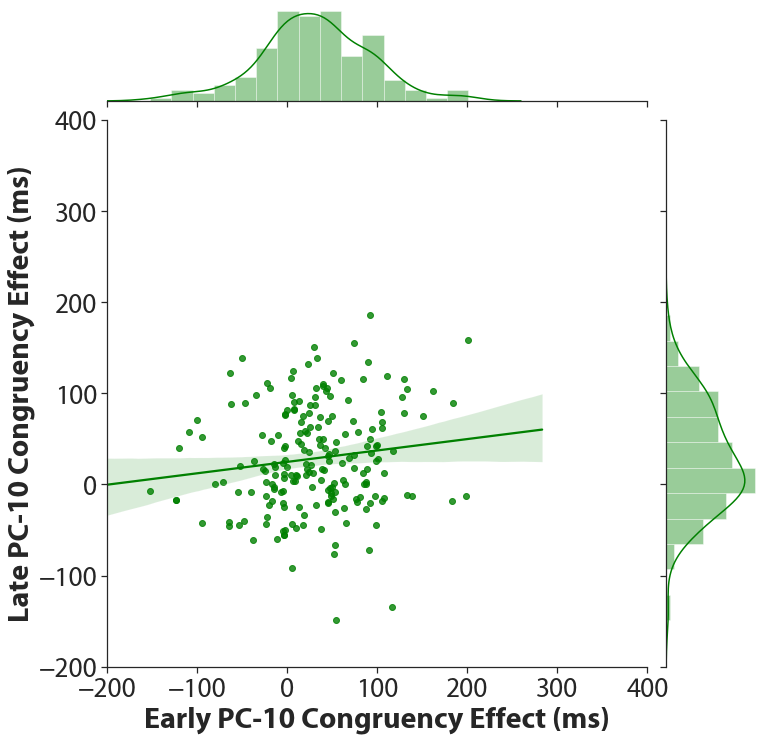

In [58]:
my_corr_graphs(miccong_early_bias.RT, miccong_late_bias.RT, 'Late PC-10 Congruency Effect (ms)', 'Early PC-10 Congruency Effect (ms)', "all_bias_mic.png", 1, ov_mic_early_bias.RT, ov_mic_late_bias.RT,-200,400,-200,400,100)

In [59]:
r_bias_mic, p_bias_mic = stats.pearsonr(miccong_early_bias.RT, miccong_late_bias.RT)  
n_bias_mic = len(miccong_early_bias.RT)
r2_bias_mic, p2_bias_mic = stats.pearsonr((miccong_early_bias.RT/ov_mic_early_bias.RT), (miccong_late_bias.RT/ov_mic_late_bias.RT))
n2_bias_mic = len(miccong_early_bias.RT)

r_bias_mic, p_bias_mic, n_bias_mic-2, r2_bias_mic, p2_bias_mic, n2_bias_mic-2

(0.1332395367888909,
 0.05870783171083035,
 200,
 0.15664748899063546,
 0.025992417321425897,
 200)

The above code is here mostly because I'm going to do a Fischer's r-to-z transformation below to compare the size of the correlations between these graphs, and I need to be able to access that correlation.

In [60]:
round(min(mccong_early_bias.RT)), round(max(mccong_early_bias.RT)), round(min(mccong_late_bias.RT)), round(max(mccong_late_bias.RT))

(-117, 385, -96, 348)

(LinregressResult(slope=0.4081810924278346, intercept=55.71928984079987, rvalue=0.40691395871575525, pvalue=2.041798201147226e-09, stderr=0.06495556698358966),
 LinregressResult(slope=0.41162080623457725, intercept=0.08877917694037728, rvalue=0.40789289554104696, pvalue=1.8522420491088432e-09, stderr=0.06531449667020696))

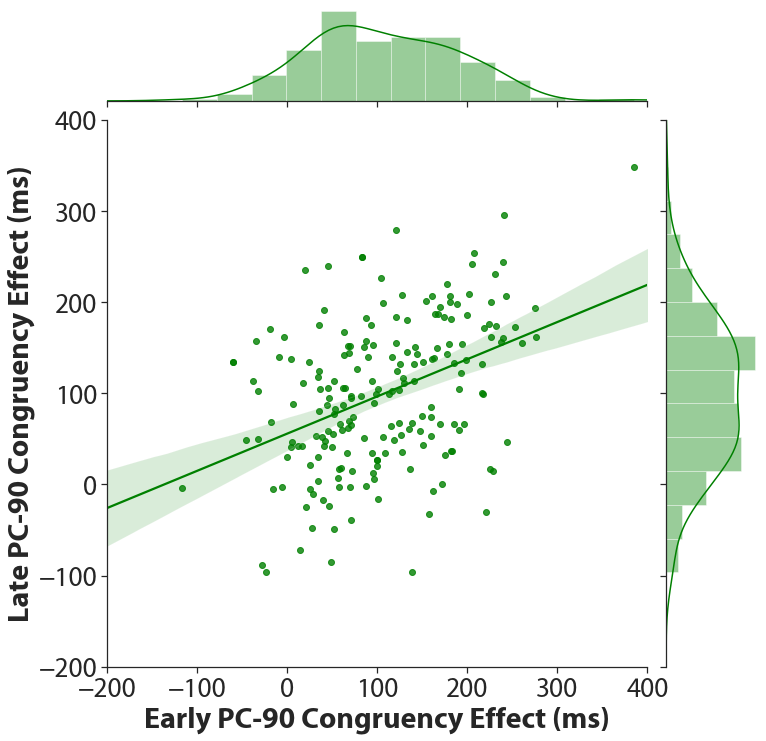

In [61]:
my_corr_graphs(mccong_early_bias.RT, mccong_late_bias.RT, 'Late PC-90 Congruency Effect (ms)', 'Early PC-90 Congruency Effect (ms)', "all_bias_mc.png", 1, ov_mc_early_bias.RT, ov_mc_late_bias.RT,-200,400,-200,400,100)

Now we're doing a Fischer's r-to-z transformation so that we can compare whether there's greater reliability for PC-90 or PC-10 biased items. And we'll do it for both the uncorrected/raw and corrected correlations.

In [62]:
r_bias_mc, p_bias_mc = stats.pearsonr(mccong_early_bias.RT, mccong_late_bias.RT)  
n_bias_mc = len(mccong_early_bias.RT)
r2_bias_mc, p2_bias_mc = stats.pearsonr((mccong_early_bias.RT/ov_mc_early_bias.RT), (mccong_late_bias.RT/ov_mc_late_bias.RT))
n2_bias_mc = len(mccong_early_bias.RT)

r_bias_mc, p_bias_mc, n_bias_mc-2, r2_bias_mc, p2_bias_mc, n2_bias_mc-2

independent_corr(r_bias_mic, r_bias_mc, n_bias_mic, n_bias_mc, twotailed=True, conf_level=0.95, method='fisher')

independent_corr(r2_bias_mic, r2_bias_mc, n2_bias_mic, n2_bias_mc, twotailed=True, conf_level=0.95, method='fisher')

(0.4069139587157553,
 2.0417982011472126e-09,
 199,
 0.4078928955410472,
 1.8522420491087925e-09,
 199)

(2.9675065061246633, 0.0030022592857321673)

(2.7409841806506967, 0.006125545662658993)

In [63]:
round(min(miccong_early_UB.RT)), round(max(miccong_early_UB.RT)), round(min(miccong_late_UB.RT)), round(max(miccong_late_UB.RT))

(-87, 258, -61, 151)

(LinregressResult(slope=0.29205244800136354, intercept=29.743067938947657, rvalue=0.3467192041792784, pvalue=4.601546946445727e-07, stderr=0.056007332399256766),
 LinregressResult(slope=0.30724036046743, intercept=0.043276544673171075, rvalue=0.35707151248316066, pvalue=1.9573174652377516e-07, stderr=0.05697432994068284))

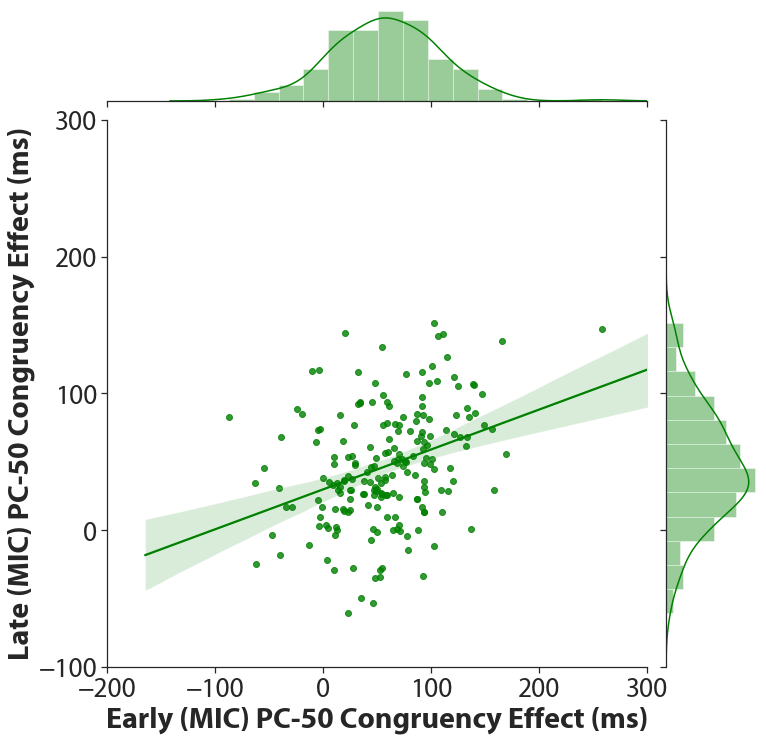

In [64]:
my_corr_graphs(miccong_early_UB.RT, miccong_late_UB.RT, 'Late (MIC) PC-50 Congruency Effect (ms)', 'Early (MIC) PC-50 Congruency Effect (ms)', "all_unbias_mic.png", 1, ov_mic_early_UB.RT, ov_mic_late_UB.RT,-200,300,-100,300,100)

In [65]:
r_unbias_mic, p_unbias_mic = stats.pearsonr(miccong_early_UB.RT, miccong_late_UB.RT)  
n_unbias_mic = len(miccong_early_UB.RT)
r2_unbias_mic, p2_unbias_mic = stats.pearsonr((miccong_early_UB.RT/ov_mic_early_UB.RT), (miccong_late_UB.RT/ov_mic_late_UB.RT))
n2_unbias_mic = len(miccong_early_UB.RT)

r_unbias_mic, p_unbias_mic, n_unbias_mic-2, r2_unbias_mic, p2_unbias_mic, n2_unbias_mic-2

(0.3467192041792782,
 4.601546946445817e-07,
 199,
 0.3570715124831604,
 1.9573174652378048e-07,
 199)

In [66]:
round(min(mccong_early_UB.RT)), round(max(mccong_early_UB.RT)), round(min(mccong_late_UB.RT)), round(max(mccong_late_UB.RT))

(-153, 196, -55, 240)

(LinregressResult(slope=0.37998956705957126, intercept=38.78584902733999, rvalue=0.408813358991733, pvalue=1.6896056516017403e-09, stderr=0.06013247676005086),
 LinregressResult(slope=0.38402711771966724, intercept=0.05739622591864935, rvalue=0.4030044083466963, pvalue=3.0036388147660088e-09, stderr=0.06182165649336563))

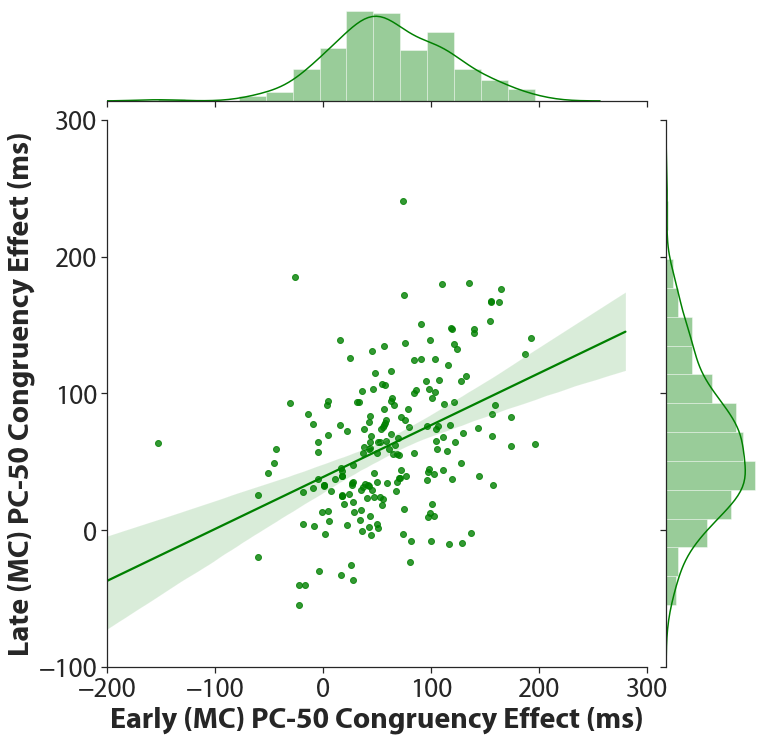

In [67]:
my_corr_graphs(mccong_early_UB.RT, mccong_late_UB.RT, 'Late (MC) PC-50 Congruency Effect (ms)', 'Early (MC) PC-50 Congruency Effect (ms)', "all_unbias_mc.png", 1, ov_mc_early_UB.RT, ov_mc_late_UB.RT,-200,300,-100,300,100)

In [68]:
r_unbias_mc, p_unbias_mc = stats.pearsonr(mccong_early_UB.RT, mccong_late_UB.RT)  
n_unbias_mc = len(mccong_early_UB.RT)
r2_unbias_mc, p2_unbias_mc = stats.pearsonr((mccong_early_UB.RT/ov_mc_early_UB.RT), (mccong_late_UB.RT/ov_mc_late_UB.RT))
n2_unbias_mc = len(mccong_early_UB.RT)

r_unbias_mc, p_unbias_mc, n_unbias_mc-2, r2_unbias_mc, p2_unbias_mc, n2_unbias_mc-2

independent_corr(r_unbias_mic, r_unbias_mc, n_unbias_mic, n_unbias_mc, twotailed=True, conf_level=0.95, method='fisher')

independent_corr(r2_unbias_mic, r2_unbias_mc, n2_unbias_mic, n2_unbias_mc, twotailed=True, conf_level=0.95, method='fisher')

(0.4088133589917328,
 1.68960565160175e-09,
 199,
 0.40300440834669643,
 3.0036388147660328e-09,
 199)

(0.7211251941097916, 0.4708324914051618)

(0.5343611706817176, 0.5930916780458952)

Now for Accuracy

In [69]:
ACCv9r1bias, ACCv9r1biascong = cong_bias(adat, 'Accuracy', 'PC-50', 9, 1, 2)
ACCv9r2bias, ACCv9r2biascong = cong_bias(adat, 'Accuracy', 'PC-50', 9, 2, 2)
ACCv9r3bias, ACCv9r3biascong = cong_bias(adat, 'Accuracy', 'PC-50', 9, 3, 2)
ACCv9r4bias, ACCv9r4biascong = cong_bias(adat, 'Accuracy', 'PC-50', 9, 4, 2) 

ACCv10r1bias, ACCv10r1biascong = cong_bias(adat, 'Accuracy', 'PC-50', 10, 1, 2)
ACCv10r2bias, ACCv10r2biascong = cong_bias(adat, 'Accuracy', 'PC-50', 10, 2, 2)
ACCv10r3bias, ACCv10r3biascong = cong_bias(adat, 'Accuracy', 'PC-50', 10, 3, 2)
ACCv10r4bias, ACCv10r4biascong = cong_bias(adat, 'Accuracy', 'PC-50', 10, 4, 2)

ACCv9r1UB, ACCv9r1UBcong = cong_bias(adat, 'Accuracy', 'PC-50', 9, 1, 1) 
ACCv9r2UB, ACCv9r2UBcong = cong_bias(adat, 'Accuracy', 'PC-50', 9, 2, 1)
ACCv9r3UB, ACCv9r3UBcong = cong_bias(adat, 'Accuracy', 'PC-50', 9, 3, 1)
ACCv9r4UB, ACCv9r4UBcong = cong_bias(adat, 'Accuracy', 'PC-50', 9, 4, 1)

ACCv10r1UB, ACCv10r1UBcong = cong_bias(adat, 'Accuracy', 'PC-50', 10, 1, 1)
ACCv10r2UB, ACCv10r2UBcong = cong_bias(adat, 'Accuracy', 'PC-50', 10, 2, 1)
ACCv10r3UB, ACCv10r3UBcong = cong_bias(adat, 'Accuracy', 'PC-50', 10, 3, 1)
ACCv10r4UB, ACCv10r4UBcong = cong_bias(adat, 'Accuracy', 'PC-50', 10, 4, 1)

In [70]:
ovACCv9biasr1 = adat.loc[adat['Item']!="PC-50"].loc[adat['Version']==9].loc[adat['RunCounter']==1].groupby(['subject'])['Accuracy'].mean().reset_index()
ovACCv9biasr2 = adat.loc[adat['Item']!="PC-50"].loc[adat['Version']==9].loc[adat['RunCounter']==2].groupby(['subject'])['Accuracy'].mean().reset_index()
ovACCv9biasr3 = adat.loc[adat['Item']!="PC-50"].loc[adat['Version']==9].loc[adat['RunCounter']==3].groupby(['subject'])['Accuracy'].mean().reset_index()
ovACCv9biasr4 = adat.loc[adat['Item']!="PC-50"].loc[adat['Version']==9].loc[adat['RunCounter']==4].groupby(['subject'])['Accuracy'].mean().reset_index()

ovACCv10biasr1 = adat.loc[adat['Item']!="PC-50"].loc[adat['Version']==10].loc[adat['RunCounter']==1].groupby(['subject'])['Accuracy'].mean().reset_index()
ovACCv10biasr2 = adat.loc[adat['Item']!="PC-50"].loc[adat['Version']==10].loc[adat['RunCounter']==2].groupby(['subject'])['Accuracy'].mean().reset_index()
ovACCv10biasr3 = adat.loc[adat['Item']!="PC-50"].loc[adat['Version']==10].loc[adat['RunCounter']==3].groupby(['subject'])['Accuracy'].mean().reset_index()
ovACCv10biasr4 = adat.loc[adat['Item']!="PC-50"].loc[adat['Version']==10].loc[adat['RunCounter']==4].groupby(['subject'])['Accuracy'].mean().reset_index()

ovACCv9UBr1 = adat.loc[adat['Item']=="PC-50"].loc[adat['Version']==9].loc[adat['RunCounter']==1].groupby(['subject'])['Accuracy'].mean().reset_index()
ovACCv9UBr2 = adat.loc[adat['Item']=="PC-50"].loc[adat['Version']==9].loc[adat['RunCounter']==2].groupby(['subject'])['Accuracy'].mean().reset_index()
ovACCv9UBr3 = adat.loc[adat['Item']=="PC-50"].loc[adat['Version']==9].loc[adat['RunCounter']==3].groupby(['subject'])['Accuracy'].mean().reset_index()
ovACCv9UBr4 = adat.loc[adat['Item']=="PC-50"].loc[adat['Version']==9].loc[adat['RunCounter']==4].groupby(['subject'])['Accuracy'].mean().reset_index()

ovACCv10UBr1 = adat.loc[adat['Item']=="PC-50"].loc[adat['Version']==10].loc[adat['RunCounter']==1].groupby(['subject'])['Accuracy'].mean().reset_index()
ovACCv10UBr2 = adat.loc[adat['Item']=="PC-50"].loc[adat['Version']==10].loc[adat['RunCounter']==2].groupby(['subject'])['Accuracy'].mean().reset_index()
ovACCv10UBr3 = adat.loc[adat['Item']=="PC-50"].loc[adat['Version']==10].loc[adat['RunCounter']==3].groupby(['subject'])['Accuracy'].mean().reset_index()
ovACCv10UBr4 = adat.loc[adat['Item']=="PC-50"].loc[adat['Version']==10].loc[adat['RunCounter']==4].groupby(['subject'])['Accuracy'].mean().reset_index()

In [71]:
miccong_early_bias_ACC = ACCv9r1biascong.append(ACCv10r3biascong).reset_index()
miccong_late_bias_ACC = ACCv9r2biascong.append(ACCv10r4biascong).reset_index()

mccong_early_bias_ACC = ACCv9r3biascong.append(ACCv10r1biascong).reset_index()
mccong_late_bias_ACC = ACCv9r4biascong.append(ACCv10r2biascong).reset_index()

miccong_early_UB_ACC = ACCv9r1UBcong.append(ACCv10r3UBcong).reset_index()
miccong_late_UB_ACC = ACCv9r2UBcong.append(ACCv10r4UBcong).reset_index()

mccong_early_UB_ACC = ACCv9r3UBcong.append(ACCv10r1UBcong).reset_index()
mccong_late_UB_ACC = ACCv9r4UBcong.append(ACCv10r2UBcong).reset_index()

ov_mic_early_bias_ACC = ovACCv9biasr1.append(ovACCv10biasr3).reset_index()
ov_mic_late_bias_ACC = ovACCv9biasr2.append(ovACCv10biasr4).reset_index()

ov_mc_early_bias_ACC = ovACCv9biasr3.append(ovACCv10biasr1).reset_index()
ov_mc_late_bias_ACC = ovACCv9biasr4.append(ovACCv10biasr2).reset_index()

ov_mic_early_UB_ACC = ovACCv9UBr1.append(ovACCv10UBr3).reset_index()
ov_mic_late_UB_ACC = ovACCv9UBr2.append(ovACCv10UBr4).reset_index()

ov_mc_early_UB_ACC = ovACCv9UBr3.append(ovACCv10UBr1).reset_index()
ov_mc_late_UB_ACC = ovACCv9UBr4.append(ovACCv10UBr2).reset_index()


In [72]:
(min(miccong_early_bias_ACC.Accuracy)), (max(miccong_early_bias_ACC.Accuracy)), (min(miccong_late_bias_ACC.Accuracy)), (max(miccong_late_bias_ACC.Accuracy))

(-0.6323185011709602,
 0.44730679156908665,
 -0.2786885245901639,
 0.5222482435597189)

(LinregressResult(slope=0.09772621596318691, intercept=-0.006628321751071033, rvalue=0.11182479891923304, pvalue=0.11309375138288633, stderr=0.061408071529261594),
 LinregressResult(slope=0.04748200309173144, intercept=-0.011468793360588439, rvalue=0.11110269207818153, pvalue=0.11545418269291569, stderr=0.030032559575179203))

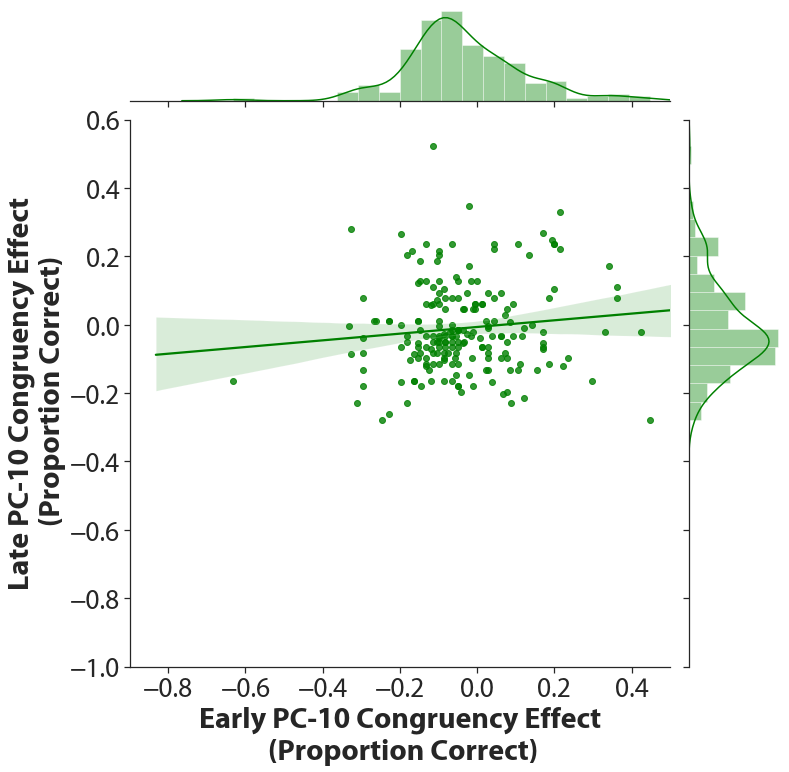

In [73]:
my_corr_graphs(miccong_early_bias_ACC.Accuracy, miccong_late_bias_ACC.Accuracy, 'Late PC-10 Congruency Effect\n (Proportion Correct)', 'Early PC-10 Congruency Effect\n (Proportion Correct)', "all_bias_mic_ACC.png", 1, ov_mic_early_bias_ACC.Accuracy, ov_mic_late_bias_ACC.Accuracy, -0.9, 0.5, -1.0, 0.6, 0.2)

In [74]:
r_bias_mic_a, p_bias_mic_a = stats.pearsonr(miccong_early_bias_ACC.Accuracy, miccong_late_bias_ACC.Accuracy)  
n_bias_mic_a = len(miccong_early_bias_ACC.Accuracy)
r2_bias_mic_a, p2_bias_mic_a = stats.pearsonr((miccong_early_bias_ACC.Accuracy/ov_mic_early_bias_ACC.Accuracy), (miccong_late_bias_ACC.Accuracy/ov_mic_late_bias_ACC.Accuracy))
n2_bias_mic_a = len(miccong_early_bias_ACC.Accuracy)

r_bias_mic_a, p_bias_mic_a, n_bias_mic_a-2, r2_bias_mic_a, p2_bias_mic_a, n2_bias_mic_a-2

(0.11182479891923297,
 0.11309375138288805,
 200,
 0.11110269207818158,
 0.1154541826929164,
 200)

In [75]:
(min(mccong_early_bias_ACC.Accuracy)), (max(mccong_early_bias_ACC.Accuracy)), (min(mccong_late_bias_ACC.Accuracy)), (max(mccong_late_bias_ACC.Accuracy))

(-0.8243559718969555,
 0.2622950819672131,
 -0.9836065573770492,
 0.19672131147540983)

(LinregressResult(slope=0.4530836037563925, intercept=-0.09573630132640082, rvalue=0.44549167991272604, pvalue=3.062796735424317e-11, stderr=0.06438513081616364),
 LinregressResult(slope=0.44735107048438894, intercept=-0.10620851984539868, rvalue=0.45200122783130997, pvalue=1.4534232551125991e-11, stderr=0.06242623645892728))

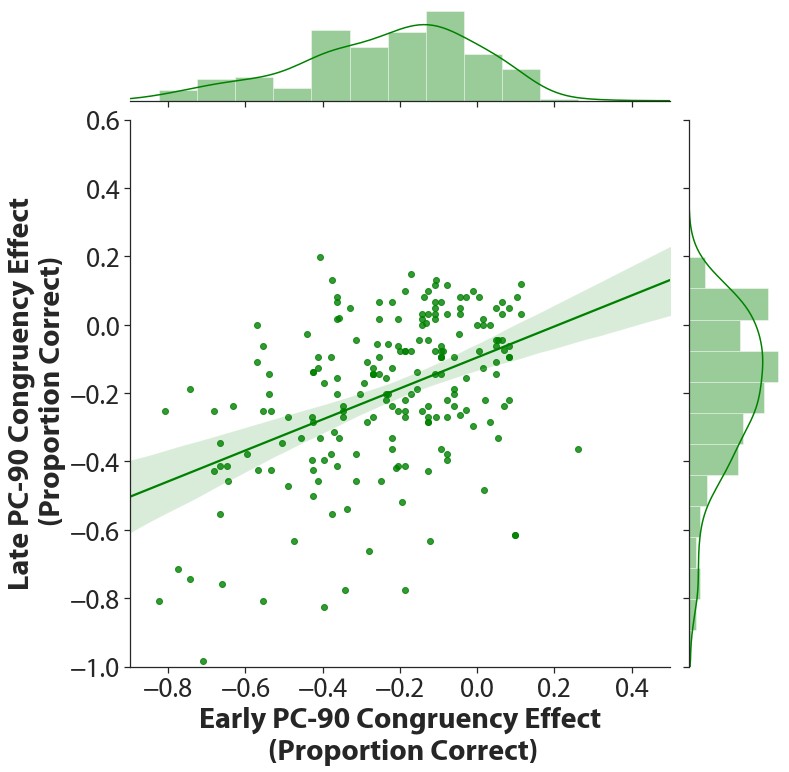

In [76]:
my_corr_graphs(mccong_early_bias_ACC.Accuracy, mccong_late_bias_ACC.Accuracy, 'Late PC-90 Congruency Effect\n (Proportion Correct)', 'Early PC-90 Congruency Effect\n (Proportion Correct)', "all_bias_mc_ACC.png", 1, ov_mc_early_bias_ACC.Accuracy, ov_mc_late_bias_ACC.Accuracy, -0.9, 0.5, -1.0, 0.6, 0.2)

In [77]:
r_bias_mc_a, p_bias_mc_a = stats.pearsonr(mccong_early_bias_ACC.Accuracy, mccong_late_bias_ACC.Accuracy)  
n_bias_mc_a = len(mccong_early_bias_ACC.Accuracy)
r2_bias_mc_a, p2_bias_mc_a = stats.pearsonr((mccong_early_bias_ACC.Accuracy/ov_mc_early_bias_ACC.Accuracy), (mccong_late_bias_ACC.Accuracy/ov_mc_late_bias_ACC.Accuracy))
n2_bias_mc_a = len(mccong_early_bias_ACC.Accuracy)

r_bias_mc_a, p_bias_mc_a, n_bias_mc_a-2, r2_bias_mc_a, p2_bias_mc_a, n2_bias_mc_a-2

independent_corr(r_bias_mic_a, r_bias_mc_a, n_bias_mic_a, n_bias_mc_a, twotailed=True, conf_level=0.95, method='fisher')

independent_corr(r2_bias_mic_a, r2_bias_mc_a, n2_bias_mic_a, n2_bias_mc_a, twotailed=True, conf_level=0.95, method='fisher')

(0.445491679912726,
 3.06279673542436e-11,
 200,
 0.45200122783130986,
 1.4534232551126073e-11,
 200)

(3.6584898775200885, 0.0002537057594089731)

(3.7470894595342195, 0.0001788982973132125)

In [78]:
(min(miccong_early_UB_ACC.Accuracy)), (max(miccong_early_UB_ACC.Accuracy)), (min(miccong_late_UB_ACC.Accuracy)), (max(miccong_late_UB_ACC.Accuracy))

(-0.85, 0.30000000000000004, -0.5, 0.35)

(LinregressResult(slope=0.26548789732748274, intercept=-0.023889298183798275, rvalue=0.3268501759282735, pvalue=2.058115477374324e-06, stderr=0.054280997321517165),
 LinregressResult(slope=0.23125595169856464, intercept=-0.02841149588074307, rvalue=0.3714450034715673, pvalue=5.2555975951013156e-08, stderr=0.04087372700384175))

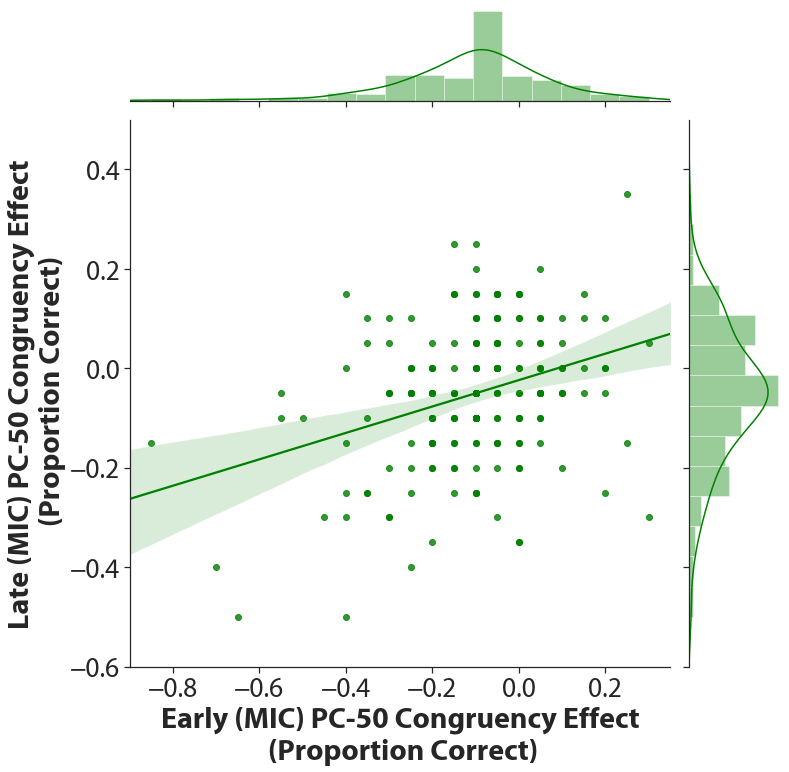

In [79]:
my_corr_graphs(miccong_early_UB_ACC.Accuracy, miccong_late_UB_ACC.Accuracy, 'Late (MIC) PC-50 Congruency Effect\n (Proportion Correct)', 'Early (MIC) PC-50 Congruency Effect\n (Proportion Correct)', "all_unbias_mic_ACC.png", 1, ov_mic_early_UB_ACC.Accuracy, ov_mic_late_UB_ACC.Accuracy, -0.9, 0.35, -0.6, 0.5, 0.2)

In [80]:
r_unbias_mic_a, p_unbias_mic_a = stats.pearsonr(miccong_early_UB_ACC.Accuracy, miccong_late_UB_ACC.Accuracy)  
n_unbias_mic_a = len(miccong_early_UB_ACC.Accuracy)
r2_unbias_mic_a, p2_unbias_mic_a = stats.pearsonr((miccong_early_UB_ACC.Accuracy/ov_mic_early_UB_ACC.Accuracy), (miccong_late_UB_ACC.Accuracy/ov_mic_late_UB_ACC.Accuracy))
n2_unbias_mic_a = len(miccong_early_UB_ACC.Accuracy)

r_unbias_mic_a, p_unbias_mic_a, n_unbias_mic_a-2, r2_unbias_mic_a, p2_unbias_mic_a, n2_unbias_mic_a-2

(0.3268501759282733,
 2.058115477374352e-06,
 200,
 0.371445003471567,
 5.255597595101429e-08,
 200)

In [81]:
(min(mccong_early_UB_ACC.Accuracy)), (max(mccong_early_UB_ACC.Accuracy)), (min(mccong_late_UB_ACC.Accuracy)), (max(mccong_late_UB_ACC.Accuracy))

(-0.8, 0.25, -0.5499999999999999, 0.3999999999999999)

(LinregressResult(slope=0.38828216321107945, intercept=-0.013499050149617005, rvalue=0.4937763436625999, pvalue=8.198250232627467e-14, stderr=0.04835219232095857),
 LinregressResult(slope=0.3240673293322118, intercept=-0.02282603061865969, rvalue=0.516024970157653, pvalue=3.84951479341037e-15, stderr=0.038037694822759385))

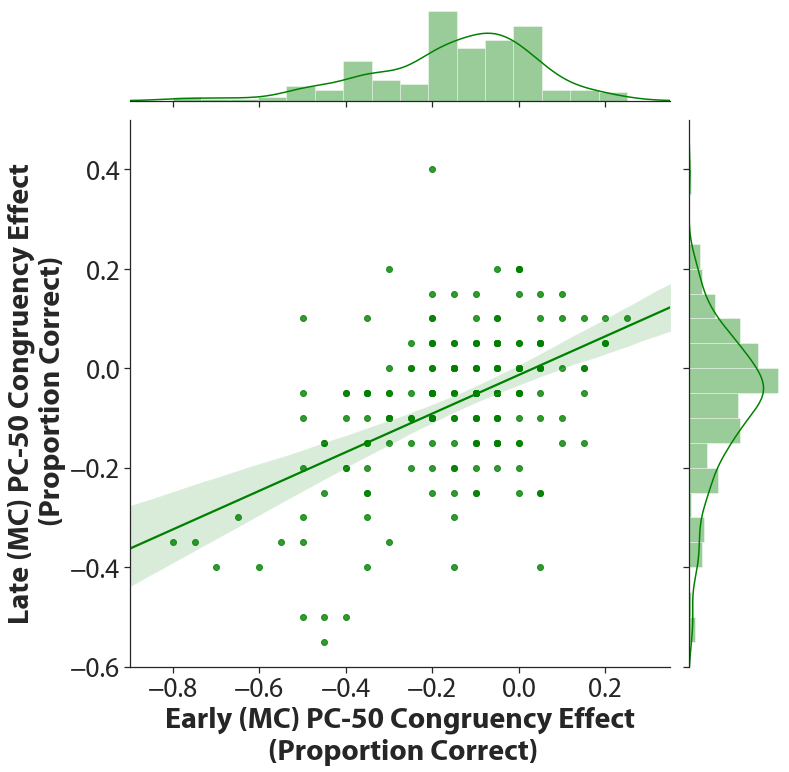

In [82]:
my_corr_graphs(mccong_early_UB_ACC.Accuracy, mccong_late_UB_ACC.Accuracy, 'Late (MC) PC-50 Congruency Effect\n (Proportion Correct)', 'Early (MC) PC-50 Congruency Effect\n (Proportion Correct)', "all_unbias_mc_acc.png", 1, ov_mc_early_UB_ACC.Accuracy, ov_mc_late_UB_ACC.Accuracy, -0.9, 0.35, -0.6, 0.5, 0.2)

In [83]:
r_unbias_mc_a, p_unbias_mc_a = stats.pearsonr(mccong_early_UB_ACC.Accuracy, mccong_late_UB_ACC.Accuracy)  
n_unbias_mc_a = len(mccong_early_UB_ACC.Accuracy)
r2_unbias_mc_a, p2_unbias_mc_a = stats.pearsonr((mccong_early_UB_ACC.Accuracy/ov_mc_early_UB_ACC.Accuracy), (mccong_late_UB_ACC.Accuracy/ov_mc_late_UB_ACC.Accuracy))
n2_unbias_mc_a = len(mccong_early_UB_ACC.Accuracy)

r_unbias_mc_a, p_unbias_mc_a, n_unbias_mc_a-2, r2_unbias_mc_a, p2_unbias_mc_a, n2_unbias_mc_a-2

independent_corr(r_unbias_mic_a, r_unbias_mc_a, n_unbias_mic_a, n_unbias_mc_a, twotailed=True, conf_level=0.95, method='fisher')

independent_corr(r2_unbias_mic_a, r2_unbias_mc_a, n2_unbias_mic_a, n2_unbias_mc_a, twotailed=True, conf_level=0.95, method='fisher')

(0.4937763436625998,
 8.198250232627616e-14,
 200,
 0.5160249701576531,
 3.8495147934103234e-15,
 200)

(2.012394437316891, 0.04417837441654382)

(1.8035593305032478, 0.07130041652633423)

Early (first block) compared to late (second block) congruency effects for unbiased items were moderately and positively correlated within both the mostly congruent (Figure 5A & C; RT: r(199) = 0.41, p < 0.001; corrected: r(199) = 0.40, p < 0.001; Accuracy: r(200) = 0.49, p < 0.001; corrected: r(200) = 0.52, p < 0.001) and mostly incongruent (Figure 5B & D; RT: r(199) = 0.35, p < 0.001; corrected: r(199) = 0.36, p < 0.001; Accuracy: r(200) = 0.33, p < 0.001; corrected: r(200) = 0.37, p < 0.001) contexts. Comparing these correlation coefficients, using a Fischer’s r-to-z transformation, we found slight evidence for greater reliability within the mostly congruent context via accuracy (uncorrected: z = 2.01, p = 0.044; corrected: z = 1.80, p = 0.071) but not RT (uncorrected: z = 0.72, p = 0.471; corrected: z = 0.53, p = 0.593). 

#### What about split halves reliability?

Next, we ran split-halves spearman’s rho correlations between congruency effects calculated for alternating 0s and 1s across trials within each PC context, testing whether participants recruited control consistently across time. 

In [84]:
def splithalfcalc(df, dv, biasrun):
    if biasrun == 1: #0s for MIC - biased
        sub_means = df.loc[df['Item']!='PC-50'].loc[df['sh']==0].loc[df['BlockType']=='PC-25'].groupby(['subject','Congruency'])[dv].mean().reset_index()
    elif biasrun == 2: #1s for MIC  - biased
        sub_means = df.loc[df['Item']!='PC-50'].loc[df['sh']==1].loc[df['BlockType']=='PC-25'].groupby(['subject','Congruency'])[dv].mean().reset_index()
    elif biasrun == 3: #0s for MC  - biased
        sub_means = df.loc[df['Item']!='PC-50'].loc[df['sh']==0].loc[df['BlockType']=='PC-75'].groupby(['subject','Congruency'])[dv].mean().reset_index()
    elif biasrun == 4: #1s for MC  - biased
        sub_means = df.loc[df['Item']!='PC-50'].loc[df['sh']==1].loc[df['BlockType']=='PC-75'].groupby(['subject','Congruency'])[dv].mean().reset_index()
    elif biasrun == 5: #0s for MIC -unbiased
        sub_means = df.loc[df['Item']=='PC-50'].loc[df['sh']==0].loc[df['BlockType']=='PC-25'].groupby(['subject','Congruency'])[dv].mean().reset_index()
    elif biasrun == 6: #1s for MIC -unbiased
        sub_means = df.loc[df['Item']=='PC-50'].loc[df['sh']==1].loc[df['BlockType']=='PC-25'].groupby(['subject','Congruency'])[dv].mean().reset_index()
    elif biasrun == 7: #0s for MC -unbiased
        sub_means = df.loc[df['Item']=='PC-50'].loc[df['sh']==0].loc[df['BlockType']=='PC-75'].groupby(['subject','Congruency'])[dv].mean().reset_index()
    elif biasrun == 8: #1s for MIC -unbiased
        sub_means = df.loc[df['Item']=='PC-50'].loc[df['sh']==1].loc[df['BlockType']=='PC-75'].groupby(['subject','Congruency'])[dv].mean().reset_index()
    
    Congdiff = sub_means.loc[sub_means['Congruency']=='Incongruent'].reset_index()[dv] - sub_means.loc[sub_means['Congruency']=='Congruent'].reset_index()[dv]
    return sub_means, Congdiff

In [85]:
MICbias_0, MICbias_0cong = splithalfcalc(cdat, 'RT', 1)
MICbias_1, MICbias_1cong = splithalfcalc(cdat, 'RT', 2)
MCbias_1, MCbias_1cong = splithalfcalc(cdat, 'RT', 4)
MICunbias_0, MICunbias_0cong = splithalfcalc(cdat, 'RT', 5)
MICunbias_1, MICunbias_1cong = splithalfcalc(cdat, 'RT', 6)
MCunbias_0, MCunbias_0cong = splithalfcalc(cdat, 'RT', 7)
MCunbias_1, MCunbias_1cong = splithalfcalc(cdat, 'RT', 8)

In [86]:
ovMICB_0 = cdat.loc[cdat['Item']!='PC-50'].loc[cdat['sh']==0].loc[cdat['BlockType']=='PC-25'].groupby(['subject'])['RT'].mean().reset_index()
ovMICB_1 = cdat.loc[cdat['Item']!='PC-50'].loc[cdat['sh']==1].loc[cdat['BlockType']=='PC-25'].groupby(['subject'])['RT'].mean().reset_index()
ovMCB_0 = cdat.loc[cdat['Item']!='PC-50'].loc[cdat['sh']==0].loc[cdat['BlockType']=='PC-75'].groupby(['subject'])['RT'].mean().reset_index()
ovMCB_1 = cdat.loc[cdat['Item']!='PC-50'].loc[cdat['sh']==1].loc[cdat['BlockType']=='PC-75'].groupby(['subject'])['RT'].mean().reset_index()
ovMICUB_0 = cdat.loc[cdat['Item']=='PC-50'].loc[cdat['sh']==0].loc[cdat['BlockType']=='PC-25'].groupby(['subject'])['RT'].mean().reset_index()
ovMICUB_1 = cdat.loc[cdat['Item']=='PC-50'].loc[cdat['sh']==1].loc[cdat['BlockType']=='PC-25'].groupby(['subject'])['RT'].mean().reset_index()
ovMCUB_0 = cdat.loc[cdat['Item']=='PC-50'].loc[cdat['sh']==0].loc[cdat['BlockType']=='PC-75'].groupby(['subject'])['RT'].mean().reset_index()
ovMCUB_1 = cdat.loc[cdat['Item']=='PC-50'].loc[cdat['sh']==1].loc[cdat['BlockType']=='PC-75'].groupby(['subject'])['RT'].mean().reset_index()

In [87]:
#subjects 6 and 93 ended up with no correct incong trials for the 0 group for MC context
MCbias_1cong = MCbias_1cong.reset_index()
MCbias_1cong = MCbias_1cong.loc[MCbias_1cong['index']!=92].loc[MCbias_1cong['index']!=5].reset_index()

ovMCB_0 = ovMCB_0.reset_index()
ovMCB_0 = ovMCB_0.loc[ovMCB_0['index']!=92].loc[ovMCB_0['index']!=5].reset_index()

ovMCB_1 = ovMCB_1.reset_index()
ovMCB_1 = ovMCB_1.loc[ovMCB_1['index']!=92].loc[ovMCB_1['index']!=5].reset_index()

In [88]:
MCbias_0 = cdat.loc[cdat['subject']!=6].loc[cdat['subject']!=93].loc[cdat['Item']!='PC-50'].loc[cdat['sh']==0].loc[cdat['BlockType']=='PC-75'].reset_index()
MCbias_0s = MCbias_0.groupby(['subject','Congruency'])['RT'].mean().reset_index()
MCbias_0cong = MCbias_0s.loc[MCbias_0s['Congruency']=='Incongruent'].reset_index()['RT'] - MCbias_0s.loc[MCbias_0s['Congruency']=='Congruent'].reset_index()['RT']

In [89]:
(min(MICbias_0cong)),(max(MICbias_0cong)), (min(MICbias_1cong)), (max(MICbias_1cong))

(-132.9375, 216.13157894736844, -160.7782608695652, 217.25714285714292)

(LinregressResult(slope=0.10128774168272522, intercept=29.67973534238657, rvalue=0.1007948335352734, pvalue=0.15349025550306258, stderr=0.07069459429174214),
 LinregressResult(slope=0.11551727585587891, intercept=0.04477978600303766, rvalue=0.11209406132511068, pvalue=0.1122233061095281, stderr=0.07241083866690914))

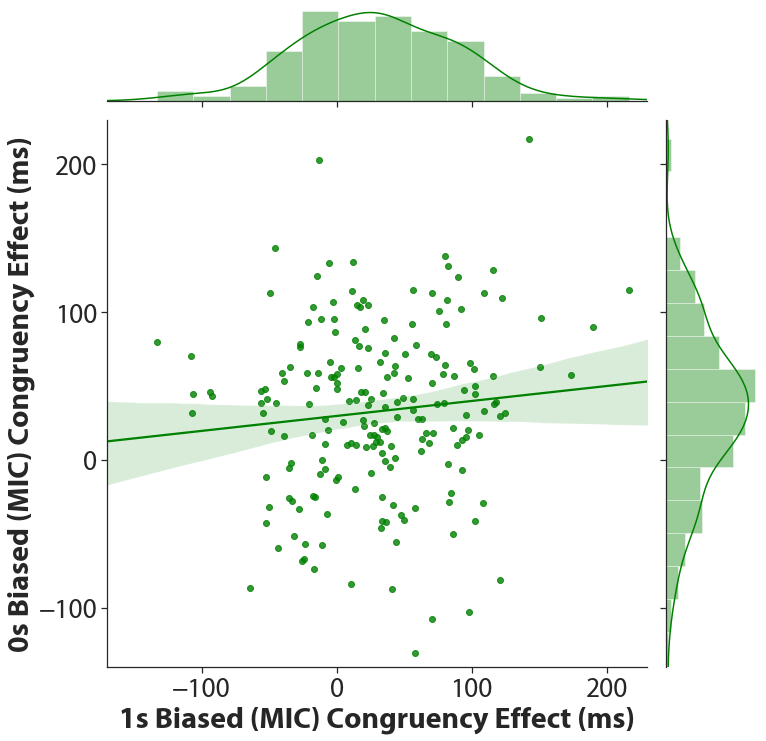

In [90]:
my_corr_graphs(MICbias_0cong, MICbias_1cong, '0s Biased (MIC) Congruency Effect (ms)', '1s Biased (MIC) Congruency Effect (ms)', "sh_mic_biasRT.png", 1, ovMICB_0.RT, ovMICB_1.RT, -170,230,-140,230,100)

In [91]:
rho_bias_mic, p_bias_mic = stats.spearmanr(MICbias_0cong, MICbias_1cong)
n_bias_mic = len(MICbias_0cong)
rho2_bias_mic, p2_bias_mic = stats.spearmanr((MICbias_0cong/ovMICB_0.RT), (MICbias_1cong/ovMICB_1.RT))
n2_bias_mic = len(MICbias_0cong)

rho_bias_mic, p_bias_mic, n_bias_mic-2, rho2_bias_mic, p2_bias_mic, n2_bias_mic-2

(0.08556519941384623,
 0.22597787212288986,
 200,
 0.10640525121551196,
 0.13175945171333509,
 200)

In [92]:
(min(MCbias_0cong)),(max(MCbias_0cong)), (min(MCbias_1cong.RT)), (max(MCbias_1cong.RT))

(-114.18604651162786, 384.16666666666663, -121.936170212766, 349.2777777777778)

(LinregressResult(slope=0.44799980484757385, intercept=58.87438943304778, rvalue=0.4645214015425996, pvalue=4.244575838149014e-12, stderr=0.0606957695680459),
 LinregressResult(slope=0.4584246622847247, intercept=0.09206842129645423, rvalue=0.47007199030616365, pvalue=2.175401610820993e-12, stderr=0.06117144554803879))

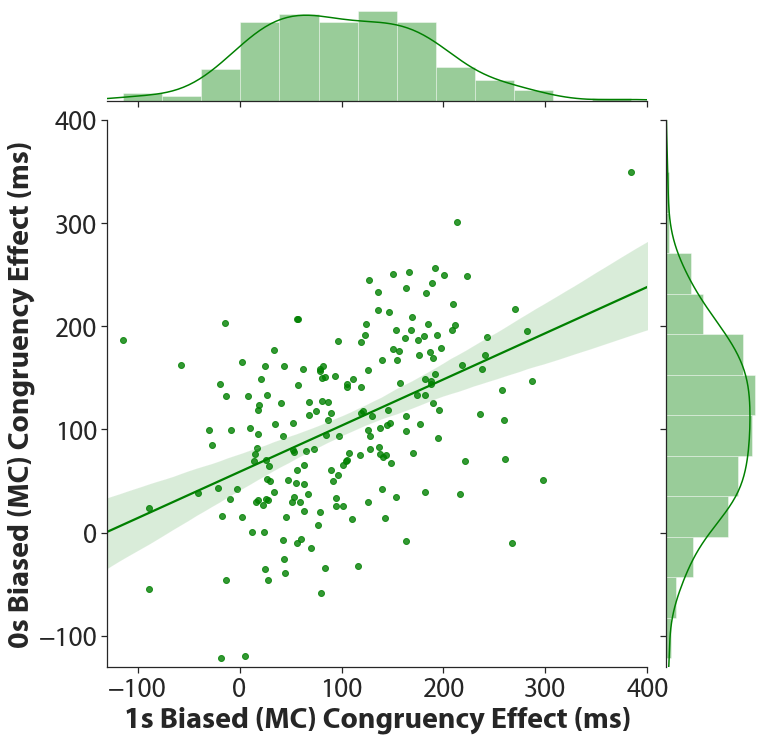

In [93]:
my_corr_graphs(MCbias_0cong, MCbias_1cong.RT, '0s Biased (MC) Congruency Effect (ms)', '1s Biased (MC) Congruency Effect (ms)', "sh_mc_biasRT.png", 1, ovMCB_0.RT, ovMCB_1.RT, -130,400,-130,400,100)

In [94]:
rho_bias_mc, p_bias_mc = stats.spearmanr(MCbias_0cong, MCbias_1cong.RT)
n_bias_mc = len(MCbias_0cong)
rho2_bias_mc, p2_bias_mc = stats.spearmanr((MCbias_0cong/ovMCB_0.RT), (MCbias_1cong.RT/ovMCB_1.RT))
n2_bias_mc = len(MCbias_0cong)

rho_bias_mc, p_bias_mc, n_bias_mc-2, rho2_bias_mc, p2_bias_mc, n2_bias_mc-2

independent_corr(rho_bias_mic, rho_bias_mc, n_bias_mic, n_bias_mc, twotailed=True, conf_level=0.95, method='fisher')

independent_corr(rho2_bias_mic, rho2_bias_mc, n2_bias_mic, n2_bias_mc, twotailed=True, conf_level=0.95, method='fisher')

(0.46065101627540694,
 6.717107165526082e-12,
 198,
 0.46525163129078234,
 3.889927208588181e-12,
 198)

(4.102901791510572, 4.080004655793168e-05)

(3.95187460945024, 7.75413701070704e-05)

In [95]:
(min(MICunbias_0cong)),(max(MICunbias_0cong)), (min(MICunbias_1cong)), (max(MICunbias_1cong))

(-82.14912280701753, 159.2698412698412, -74.31818181818187, 241.0)

(LinregressResult(slope=0.1580356470986439, intercept=41.036714328232094, rvalue=0.15036236801405034, pvalue=0.03268372584761366, stderr=0.07347424084729609),
 LinregressResult(slope=0.15077479301114333, intercept=0.060617293793240365, rvalue=0.1448994880147527, pvalue=0.039638202450773374, stderr=0.07280130359753673))

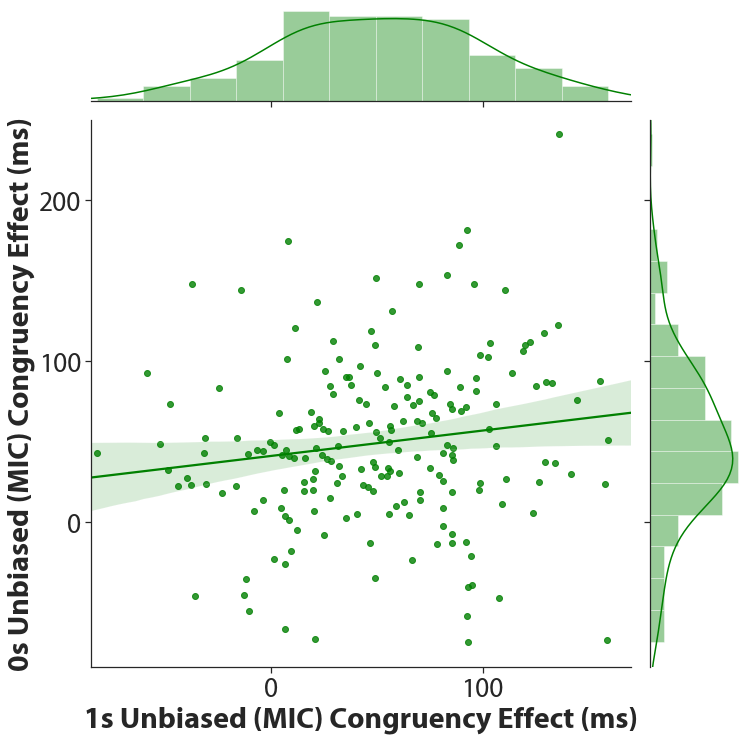

In [96]:
my_corr_graphs(MICunbias_0cong, MICunbias_1cong, '0s Unbiased (MIC) Congruency Effect (ms)', '1s Unbiased (MIC) Congruency Effect (ms)', "sh_mic_unbiasRT.png", 1, ovMICUB_0.RT, ovMICUB_1.RT, -85,170,-90,250,100)

In [97]:
rho_unbias_mic, p_unbias_mic = stats.spearmanr(MICunbias_0cong, MICunbias_1cong)
n_unbias_mic = len(MICunbias_0cong)
rho2_unbias_mic, p2_unbias_mic = stats.spearmanr((MICunbias_0cong/ovMICUB_0.RT), (MICunbias_1cong/ovMICUB_1.RT))
n2_unbias_mic = len(MICunbias_0cong)

rho_unbias_mic, p_unbias_mic, n_unbias_mic-2, rho2_unbias_mic, p2_unbias_mic, n2_unbias_mic-2

(0.1724044551212512,
 0.0141465131484881,
 200,
 0.1773464531218948,
 0.011570756846243794,
 200)

In [98]:
(min(MCunbias_0cong)),(max(MCunbias_0cong)), (min(MCunbias_1cong)), (max(MCunbias_1cong))

(-86.20000000000005, 219.04761904761904, -75.6875, 192.20000000000005)

(LinregressResult(slope=0.39319200435037155, intercept=35.46132195338686, rvalue=0.3891582461642091, pvalue=1.0410829160367735e-08, stderr=0.06581178357133026),
 LinregressResult(slope=0.3898437407812907, intercept=0.051623063884334804, rvalue=0.38799678821878175, pvalue=1.1611296154813097e-08, stderr=0.06548148480185284))

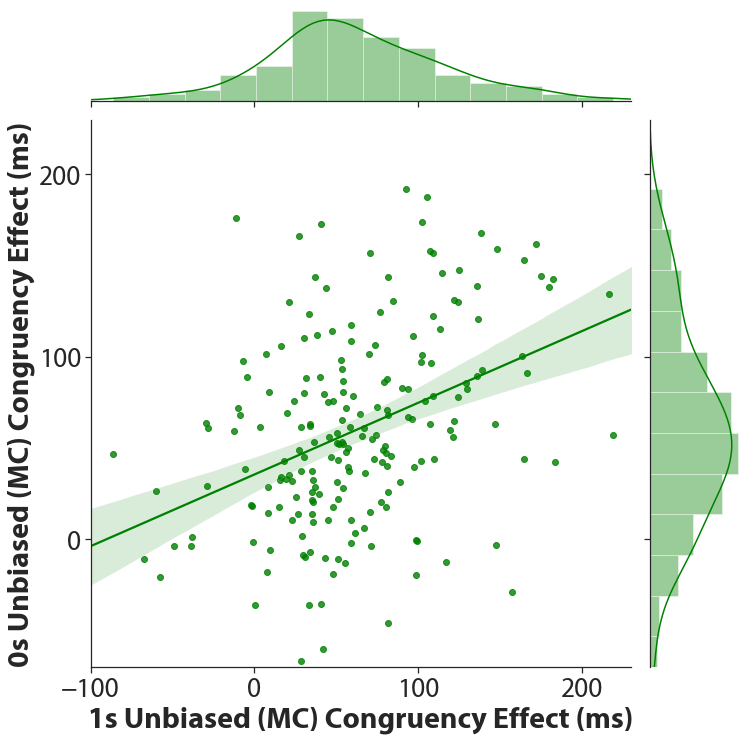

In [99]:
my_corr_graphs(MCunbias_0cong, MCunbias_1cong, '0s Unbiased (MC) Congruency Effect (ms)', '1s Unbiased (MC) Congruency Effect (ms)', "sh_mc_unbiasRT.png", 1, ovMCUB_0.RT, ovMCUB_1.RT, -100,230,-70,230,100)

In [100]:
rho_unbias_mc, p_unbias_mc = stats.spearmanr(MCunbias_0cong, MCunbias_1cong)  
n_unbias_mc = len(MCunbias_0cong)
rho2_unbias_mc, p2_unbias_mc = stats.spearmanr((MCunbias_0cong/ovMCUB_0.RT), (MCunbias_1cong/ovMCUB_1.RT))
n2_unbias_mc = len(MCunbias_0cong)

rho_unbias_mc, p_unbias_mc, n_unbias_mc-2, rho2_unbias_mc, p2_unbias_mc, n2_unbias_mc-2

independent_corr(rho_unbias_mic, rho_unbias_mc, n_unbias_mic, n_unbias_mc, twotailed=True, conf_level=0.95, method='fisher')

independent_corr(rho2_unbias_mic, rho2_unbias_mc, n2_unbias_mic, n2_unbias_mc, twotailed=True, conf_level=0.95, method='fisher')

(0.3838455384395877,
 1.7091625223570215e-08,
 200,
 0.38979006348543094,
 9.809019367777991e-09,
 200)

(2.2984143125707734, 0.021538219679204662)

(2.3172932352914355, 0.020487763558503902)

In [101]:
MICbias_0_ACC, MICbias_0cong_ACC = splithalfcalc(adat, 'Accuracy', 1)
MICbias_1_ACC, MICbias_1cong_ACC = splithalfcalc(adat, 'Accuracy', 2)
MCbias_0_ACC, MCbias_0cong_ACC = splithalfcalc(adat, 'Accuracy', 3)
MCbias_1_ACC, MCbias_1cong_ACC = splithalfcalc(adat, 'Accuracy', 4)
MICunbias_0_ACC, MICunbias_0cong_ACC = splithalfcalc(adat, 'Accuracy', 5)
MICunbias_1_ACC, MICunbias_1cong_ACC = splithalfcalc(adat, 'Accuracy', 6)
MCunbias_0_ACC, MCunbias_0cong_ACC = splithalfcalc(adat, 'Accuracy', 7)
MCunbias_1_ACC, MCunbias_1cong_ACC = splithalfcalc(adat, 'Accuracy', 8)

In [102]:
ovMICB_0_ACC = adat.loc[adat['Item']!='PC-50'].loc[adat['sh']==0].loc[adat['BlockType']=='PC-25'].groupby(['subject'])['Accuracy'].mean().reset_index()
ovMICB_1_ACC = adat.loc[adat['Item']!='PC-50'].loc[adat['sh']==1].loc[adat['BlockType']=='PC-25'].groupby(['subject'])['Accuracy'].mean().reset_index()
ovMCB_0_ACC = adat.loc[adat['Item']!='PC-50'].loc[adat['sh']==0].loc[adat['BlockType']=='PC-75'].groupby(['subject'])['Accuracy'].mean().reset_index()
ovMCB_1_ACC = adat.loc[adat['Item']!='PC-50'].loc[adat['sh']==1].loc[adat['BlockType']=='PC-75'].groupby(['subject'])['Accuracy'].mean().reset_index()
ovMICUB_0_ACC = adat.loc[adat['Item']=='PC-50'].loc[adat['sh']==0].loc[adat['BlockType']=='PC-25'].groupby(['subject'])['Accuracy'].mean().reset_index()
ovMICUB_1_ACC = adat.loc[adat['Item']=='PC-50'].loc[adat['sh']==1].loc[adat['BlockType']=='PC-25'].groupby(['subject'])['Accuracy'].mean().reset_index()
ovMCUB_0_ACC = adat.loc[adat['Item']=='PC-50'].loc[adat['sh']==0].loc[adat['BlockType']=='PC-75'].groupby(['subject'])['Accuracy'].mean().reset_index()
ovMCUB_1_ACC = adat.loc[adat['Item']=='PC-50'].loc[adat['sh']==1].loc[adat['BlockType']=='PC-75'].groupby(['subject'])['Accuracy'].mean().reset_index()

In [103]:
(min(MICbias_0cong_ACC)),(max(MICbias_0cong_ACC)), (min(MICbias_1cong_ACC)), (max(MICbias_1cong_ACC))

(-0.35, 0.43442622950819676, -0.5846153846153845, 0.42307692307692313)

(LinregressResult(slope=0.03631682678479033, intercept=-0.026427923364248065, rvalue=0.032946814482705845, pvalue=0.6415858412863802, stderr=0.07790110653383149),
 LinregressResult(slope=0.10197028369455693, intercept=-0.03589042503829128, rvalue=0.08443561025449516, pvalue=0.2321874786971058, stderr=0.08509015498691952))

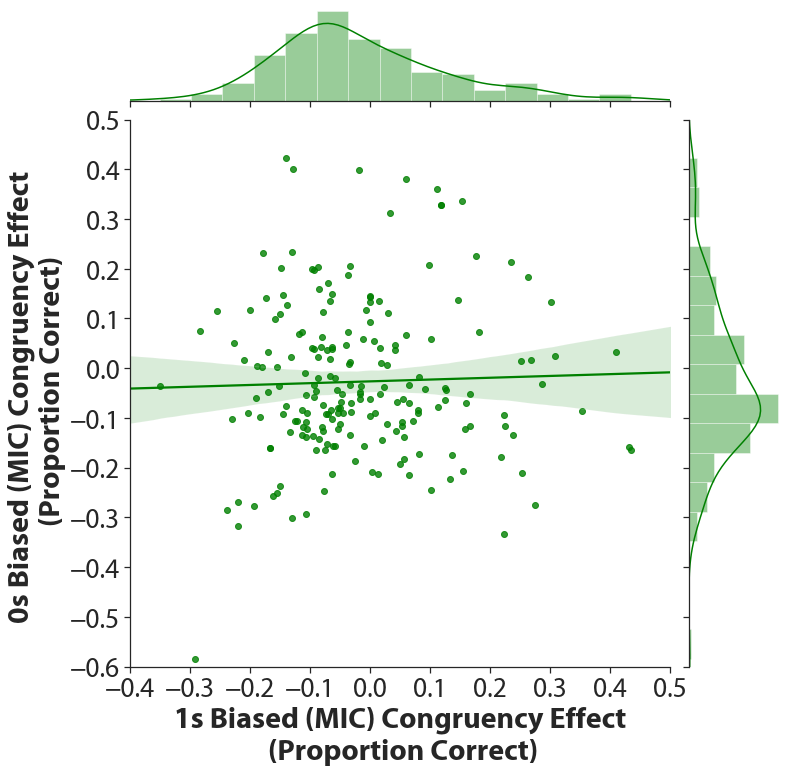

In [104]:
my_corr_graphs(MICbias_0cong_ACC, MICbias_1cong_ACC, '0s Biased (MIC) Congruency Effect \n (Proportion Correct)', '1s Biased (MIC) Congruency Effect\n (Proportion Correct)', "sh_mic_biasACC.png", 1, ovMICB_0_ACC.Accuracy, ovMICB_1_ACC.Accuracy, -0.40,0.50,-0.60,0.5,0.1)

In [105]:
rho_bias_mic_a, p_bias_mic_a = stats.spearmanr(MICbias_0cong_ACC, MICbias_1cong_ACC)
n_bias_mic_a = len(MICbias_0cong_ACC)
rho2_bias_mic_a, p2_bias_mic_a = stats.spearmanr((MICbias_0cong_ACC/ovMICB_0_ACC.Accuracy), (MICbias_1cong_ACC/ovMICB_1_ACC.Accuracy))
n2_bias_mic_a = len(MICbias_0cong_ACC)

rho_bias_mic_a, p_bias_mic_a, n_bias_mic_a-2, rho2_bias_mic_a, p2_bias_mic_a, n2_bias_mic_a-2

(0.0025850628360675697,
 0.9708735514485003,
 200,
 0.005499843304050391,
 0.9380802535911165,
 200)

In [106]:
(min(MCbias_0cong_ACC)),(max(MCbias_0cong_ACC)), (min(MCbias_1cong_ACC)), (max(MCbias_1cong_ACC))

(-0.9846153846153847,
 0.2222222222222222,
 -0.9538461538461539,
 0.2033898305084746)

(LinregressResult(slope=0.46886592369828234, intercept=-0.11346542559816332, rvalue=0.42093752498839293, pvalue=4.4384749333517166e-10, stderr=0.07144407735824448),
 LinregressResult(slope=0.49644564371129635, intercept=-0.12687434941275366, rvalue=0.435138085645654, pvalue=9.707054075000594e-11, stderr=0.07263527769725325))

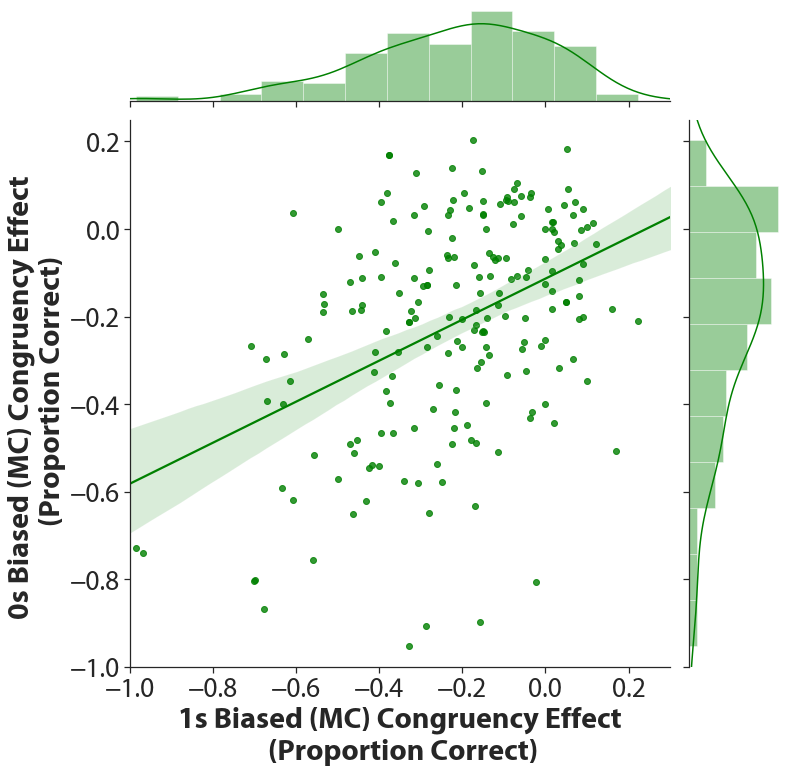

In [107]:
my_corr_graphs(MCbias_0cong_ACC, MCbias_1cong_ACC, '0s Biased (MC) Congruency Effect \n (Proportion Correct)', '1s Biased (MC) Congruency Effect\n (Proportion Correct)', "sh_mc_biasACC.png", 1, ovMCB_0_ACC.Accuracy, ovMCB_1_ACC.Accuracy, -1,0.30,-1,0.25,0.2)

In [108]:
rho_bias_mc_a, p_bias_mc_a = stats.spearmanr(MCbias_0cong_ACC, MCbias_1cong_ACC) 
n_bias_mc_a = len(MCbias_0cong_ACC)
rho2_bias_mc_a, p2_bias_mc_a = stats.spearmanr((MCbias_0cong_ACC/ovMCB_0_ACC.Accuracy), (MCbias_1cong_ACC/ovMCB_1_ACC.Accuracy))
n2_bias_mc_a = len(MCbias_0cong_ACC)

rho_bias_mc_a, p_bias_mc_a, n_bias_mc_a-2, rho2_bias_mc_a, p2_bias_mc_a, n2_bias_mc_a-2

independent_corr(rho_bias_mic_a, rho_bias_mc_a, n_bias_mic_a, n_bias_mc_a, twotailed=True, conf_level=0.95, method='fisher')

independent_corr(rho2_bias_mic_a, rho2_bias_mc_a, n2_bias_mic_a, n2_bias_mc_a, twotailed=True, conf_level=0.95, method='fisher')

(0.3715486048150785,
 5.20751303172707e-08,
 200,
 0.3803166891326724,
 2.364216353969462e-08,
 200)

(3.8666316261418605, 0.00011034891707284444)

(3.939413781815128, 8.168094893390432e-05)

In [109]:
(min(MICunbias_0cong_ACC)),(max(MICunbias_0cong_ACC)), (min(MICunbias_1cong_ACC)), (max(MICunbias_1cong_ACC))

(-0.7028985507246377, 0.23923444976076558, -0.66, 0.4522058823529411)

(LinregressResult(slope=0.4006658587198268, intercept=-0.047058680526630585, rvalue=0.3650176660436605, pvalue=9.237268886258878e-08, stderr=0.07226090775190297),
 LinregressResult(slope=0.43270942082965375, intercept=-0.05856771693542727, rvalue=0.39949644429337927, pvalue=3.867561550384636e-09, stderr=0.07021212638509806))

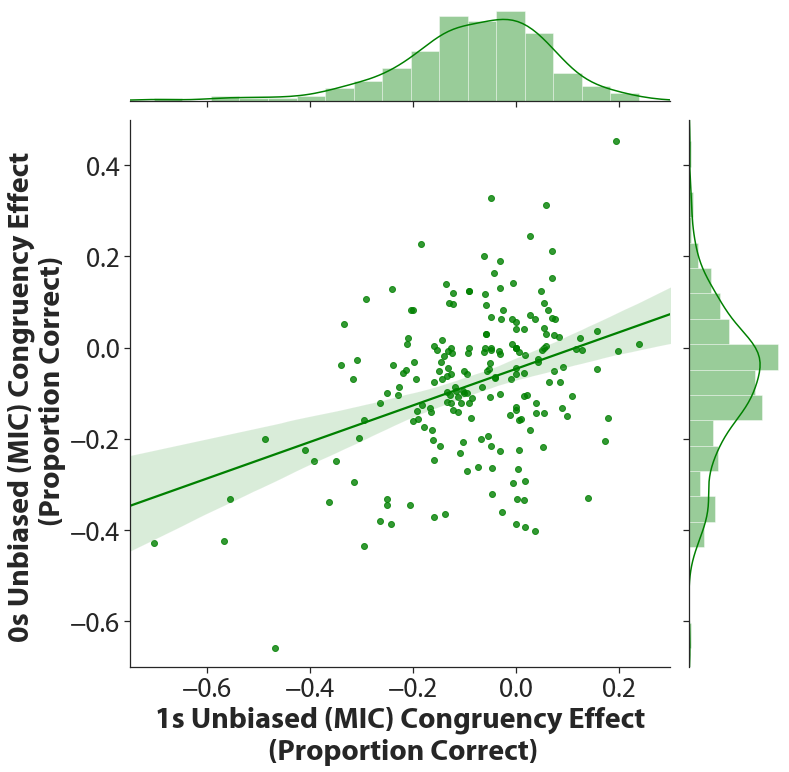

In [110]:
my_corr_graphs(MICunbias_0cong_ACC, MICunbias_1cong_ACC, '0s Unbiased (MIC) Congruency Effect \n (Proportion Correct)', '1s Unbiased (MIC) Congruency Effect\n (Proportion Correct)', "sh_mic_unbiasACC.png", 1, ovMICUB_0_ACC.Accuracy, ovMICUB_1_ACC.Accuracy, -0.75,0.30,-0.70,0.50,0.2)

In [111]:
rho_unbias_mic_a, p_unbias_mic_a = stats.spearmanr(MICunbias_0cong_ACC, MICunbias_1cong_ACC)  
n_unbias_mic_a = len(MICunbias_0cong_ACC)
rho2_unbias_mic_a, p2_unbias_mic_a = stats.spearmanr((MICunbias_0cong_ACC/ovMICUB_0_ACC.Accuracy), (MICunbias_1cong_ACC/ovMICUB_1_ACC.Accuracy))
n2_unbias_mic_a = len(MICunbias_0cong_ACC)
 
rho_unbias_mic_a, p_unbias_mic_a, n_unbias_mic_a-2, rho2_unbias_mic_a, p2_unbias_mic_a, n2_unbias_mic_a-2

(0.2693935557588526,
 0.00010576923997780547,
 200,
 0.26677888028831265,
 0.0001240909539718566,
 200)

In [112]:
(min(MCunbias_0cong_ACC)),(max(MCunbias_0cong_ACC)), (min(MCunbias_1cong_ACC)), (max(MCunbias_1cong_ACC))

(-0.7269736842105263,
 0.3142857142857143,
 -0.5714285714285714,
 0.20740740740740737)

(LinregressResult(slope=0.3872757344246235, intercept=-0.060208207004171815, rvalue=0.4617346131509432, pvalue=4.627898486219987e-12, stderr=0.052607219550891635),
 LinregressResult(slope=0.4081995490185241, intercept=-0.07849852196235212, rvalue=0.5215177678332116, pvalue=1.7471086298094908e-15, stderr=0.04722368087757576))

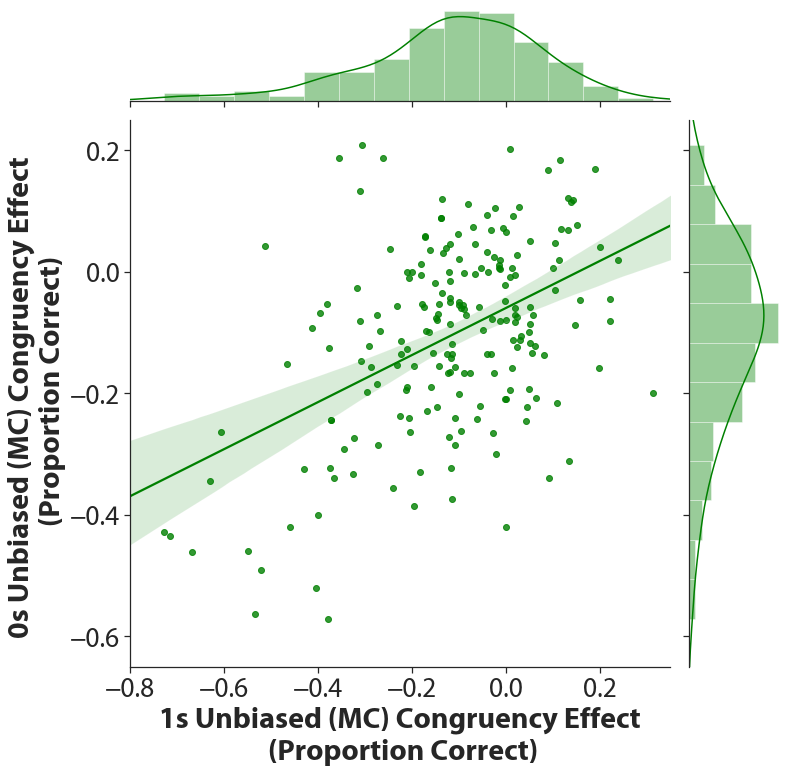

In [113]:
my_corr_graphs(MCunbias_0cong_ACC, MCunbias_1cong_ACC, '0s Unbiased (MC) Congruency Effect \n (Proportion Correct)', '1s Unbiased (MC) Congruency Effect\n (Proportion Correct)', "sh_mc_unbiasACC.png", 1, ovMCUB_0_ACC.Accuracy, ovMCUB_1_ACC.Accuracy, -0.8,0.35,-0.65,0.25,0.2)

In [114]:
rho_unbias_mc_a, p_unbias_mc_a = stats.spearmanr(MCunbias_0cong_ACC, MCunbias_1cong_ACC)  
n_unbias_mc_a = len(MCunbias_0cong_ACC)
rho2_unbias_mc_a, p2_unbias_mc_a = stats.spearmanr((MCunbias_0cong_ACC/ovMCUB_0_ACC.Accuracy), (MCunbias_1cong_ACC/ovMCUB_1_ACC.Accuracy))
n2_unbias_mc_a = len(MCunbias_0cong_ACC)

rho_unbias_mc_a, p_unbias_mc_a, n_unbias_mc_a-2, rho2_unbias_mc_a, p2_unbias_mc_a, n2_unbias_mc_a-2

independent_corr(rho_unbias_mic_a, rho_unbias_mc_a, n_unbias_mic_a, n_unbias_mc_a, twotailed=True, conf_level=0.95, method='fisher')

independent_corr(rho2_unbias_mic_a, rho2_unbias_mc_a, n2_unbias_mic_a, n2_unbias_mc_a, twotailed=True, conf_level=0.95, method='fisher')

(0.34837936843417733,
 3.7596114158431927e-07,
 200,
 0.3462904523235866,
 4.4590056335372267e-07,
 200)

(0.8716951949417244, 0.38337468230099003)

(0.8761005888912173, 0.3809753526619779)

We found modest reliability within both the mostly congruent context (RT: ρ(200) = 0.39, p < 0.001; corrected: ρ(200) = 0.39, p < 0.001; Accuracy: ρ(200) = 0.35, p < 0.001; corrected: ρ(200) = 0.35, p < 0.001) and mostly incongruent context (RT: ρ(200) = 0.17, p = 0.017; corrected: ρ(200) = 0.18, p = 0.010; Accuracy: ρ(200) = 0.27, p < 0.001; corrected: ρ(200) = 0.27, p < 0.001). Again, comparing correlation coefficients with a Fischer’s r-to-z transformation (Myers & Sirois, 2006), we found some evidence for greater behavioral consistency in the mostly congruent context, but here with RT (uncorrected: z = 2.43, p = 0.015; corrected: z = 2.31, p = 0.021) and not accuracy (uncorrected: z = 0.872, p = 0.383; corrected: z = 0.876, p = 0.381).

In short, these control-learning measures were stable across the study (for the corresponding analyses on biased items, see Supplementary Text), such that the lack of correlations between these measures and metrics of reward sensitivity cannot be accounted for by poor reliability in the control learning measurements. 

### Are the biased and unbiased congruency effects related within context?

One key determinant of the unbiased LWPC effect should be the learning process taking place with respect to the biased items. Specifically, an underlying assumption of PC paradigms is that the biased items drive the learning, and the resultant adjustments in control are then extended to the unbiased items. Accordingly, congruency effects for biased and unbiased items should be positively correlated, but to the best of our knowledge this has not previously been assessed in the LWPC (cf. Bugg & Dey, 2018; Gonthier et al., 2016). We therefore calculated correlations between congruency effects for both biased and unbiased items across PC contexts (collapsed across block orders, for greater power).

In [115]:
def relate_bias(df, dv, ItemFilter, VersionFilter, biasrun):
    if biasrun == 1: #early UB
        sub_means = df.loc[df['Item']==ItemFilter].loc[df['Version']==VersionFilter].loc[df['RunCounter'] < 3].groupby(['subject','Congruency'])[dv].mean().reset_index()
    elif biasrun == 2: #late UB
        sub_means = df.loc[df['Item']==ItemFilter].loc[df['Version']==VersionFilter].loc[df['RunCounter'] > 2].groupby(['subject','Congruency'])[dv].mean().reset_index()
    elif biasrun == 3: #early B
        sub_means = df.loc[df['Item']!=ItemFilter].loc[df['Version']==VersionFilter].loc[df['RunCounter'] < 3].groupby(['subject','Congruency'])[dv].mean().reset_index()
    elif biasrun == 4: #late B
        sub_means = df.loc[df['Item']!=ItemFilter].loc[df['Version']==VersionFilter].loc[df['RunCounter'] > 2].groupby(['subject','Congruency'])[dv].mean().reset_index()
    
    Congdiff = sub_means.loc[sub_means['Congruency']=='Incongruent'].reset_index()[dv] - sub_means.loc[sub_means['Congruency']=='Congruent'].reset_index()[dv]
    return sub_means, Congdiff

In [116]:
RTv9earlybias, RTv9earlybiascong = relate_bias(cdat, 'RT', 'PC-50', 9, 3)
RTv9latebias, RTv9latebiascong = relate_bias(cdat, 'RT', 'PC-50', 9, 4)

RTv10earlybias, RTv10earlybiascong = relate_bias(cdat, 'RT', 'PC-50', 10, 3)
RTv10latebias, RTv10latebiascong = relate_bias(cdat, 'RT', 'PC-50', 10, 4)

RTv9earlyUB, RTv9earlyUBcong = relate_bias(cdat, 'RT', 'PC-50', 9, 1)
RTv9lateUB, RTv9lateUBcong = relate_bias(cdat, 'RT', 'PC-50', 9, 2)

RTv10earlyUB, RTv10earlyUBcong = relate_bias(cdat, 'RT', 'PC-50', 10, 1)
RTv10lateUB, RTv10lateUBcong = relate_bias(cdat, 'RT', 'PC-50', 10, 2)

In [117]:
ovRTv9biasearly = cdat.loc[cdat['Item']!="PC-50"].loc[cdat['Version']==9].loc[cdat['RunCounter'] < 3].groupby(['subject'])['RT'].mean().reset_index()
ovRTv9biaslate = cdat.loc[cdat['Item']!="PC-50"].loc[cdat['Version']==9].loc[cdat['RunCounter'] > 2].groupby(['subject'])['RT'].mean().reset_index()

ovRTv10biasearly = cdat.loc[cdat['Item']!="PC-50"].loc[cdat['Version']==10].loc[cdat['RunCounter'] < 3].groupby(['subject'])['RT'].mean().reset_index()
ovRTv10biaslate = cdat.loc[cdat['Item']!="PC-50"].loc[cdat['Version']==10].loc[cdat['RunCounter'] > 2].groupby(['subject'])['RT'].mean().reset_index()

ovRTv9UBearly = cdat.loc[cdat['Item']=="PC-50"].loc[cdat['Version']==9].loc[cdat['RunCounter'] < 3].groupby(['subject'])['RT'].mean().reset_index()
ovRTv9UBlate = cdat.loc[cdat['Item']=="PC-50"].loc[cdat['Version']==9].loc[cdat['RunCounter'] > 2].groupby(['subject'])['RT'].mean().reset_index()

ovRTv10UBearly = cdat.loc[cdat['Item']=="PC-50"].loc[cdat['Version']==10].loc[cdat['RunCounter'] < 3].groupby(['subject'])['RT'].mean().reset_index()
ovRTv10UBlate = cdat.loc[cdat['Item']=="PC-50"].loc[cdat['Version']==10].loc[cdat['RunCounter'] > 2].groupby(['subject'])['RT'].mean().reset_index()

In [118]:
miccong_bias = RTv9earlybiascong.append(RTv10latebiascong).reset_index()
mccong_bias = RTv9latebiascong.append(RTv10earlybiascong).reset_index()

miccong_UB = RTv9earlyUBcong.append(RTv10lateUBcong).reset_index()
mccong_UB = RTv9lateUBcong.append(RTv10earlyUBcong).reset_index()

ov_mic_bias = ovRTv9biasearly.append(ovRTv10biaslate).reset_index()
ov_mc_bias = ovRTv9biaslate.append(ovRTv10biasearly).reset_index()

ov_mic_UB = ovRTv9UBearly.append(ovRTv10UBlate).reset_index()
ov_mc_UB = ovRTv9UBlate.append(ovRTv10UBearly).reset_index()

In [119]:
(min(miccong_bias.RT)),(max(miccong_bias.RT)), (min(miccong_UB.RT)), (max(miccong_UB.RT))

(-73.08950617283949, 181.35897435897436, -41.5711574952561, 193.00534759358288)

(LinregressResult(slope=0.14666878355759208, intercept=21.934977364559973, rvalue=0.12512778508344127, pvalue=0.07600632691829173, stderr=0.08223224973640923),
 LinregressResult(slope=0.15736300701639752, intercept=0.03284273693518652, rvalue=0.12813050729098088, pvalue=0.06917527817662784, stderr=0.08612723700462734))

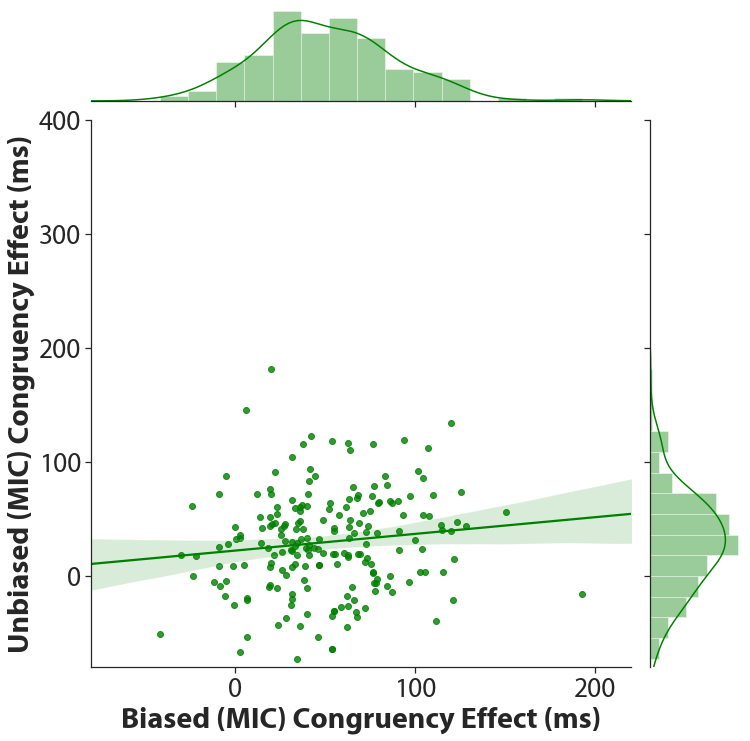

In [120]:
my_corr_graphs(miccong_UB.RT, miccong_bias.RT, 'Unbiased (MIC) Congruency Effect (ms)', 'Biased (MIC) Congruency Effect (ms)', "biasunbias_micRT.png", 1, ov_mic_UB.RT, ov_mic_bias.RT, -80,220,-80,400,100)

In [121]:
(min(mccong_bias.RT)),(max(mccong_bias.RT)), (min(mccong_UB.RT)), (max(mccong_UB.RT))

(-70.01386138613861, 360.06862745098033, -40.026190476190436, 171.030303030303)

(LinregressResult(slope=0.6344097665821732, intercept=64.80619546789661, rvalue=0.409356944775851, pvalue=1.4564407673360463e-09, stderr=0.09998290491317363),
 LinregressResult(slope=0.662564651171472, intercept=0.10588824269224291, rvalue=0.3844944642423767, pvalue=1.6094975400137757e-08, stderr=0.11248244970012147))

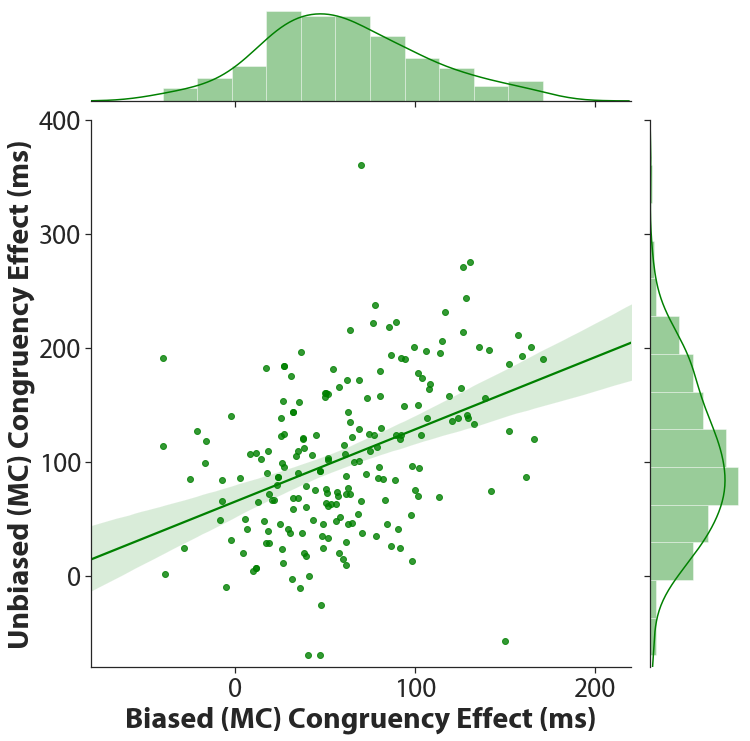

In [122]:
my_corr_graphs(mccong_UB.RT, mccong_bias.RT, 'Unbiased (MC) Congruency Effect (ms)', 'Biased (MC) Congruency Effect (ms)', "biasunbias_mcRT.png", 1, ov_mc_UB.RT, ov_mc_bias.RT, -80,220,-80,400,100)

In [123]:
ACCv9earlybias, ACCv9earlybiascong = relate_bias(adat, 'Accuracy', 'PC-50', 9, 3)
ACCv9latebias, ACCv9latebiascong = relate_bias(adat, 'Accuracy', 'PC-50', 9, 4)

ACCv10earlybias, ACCv10earlybiascong = relate_bias(adat, 'Accuracy', 'PC-50', 10, 3)
ACCv10latebias, ACCv10latebiascong = relate_bias(adat, 'Accuracy', 'PC-50', 10, 4)

ACCv9earlyUB, ACCv9earlyUBcong = relate_bias(adat, 'Accuracy', 'PC-50', 9, 1)
ACCv9lateUB, ACCv9lateUBcong = relate_bias(adat, 'Accuracy', 'PC-50', 9, 2)

ACCv10earlyUB, ACCv10earlyUBcong = relate_bias(adat, 'Accuracy', 'PC-50', 10, 1)
ACCv10lateUB, ACCv10lateUBcong = relate_bias(adat, 'Accuracy', 'PC-50', 10, 2)

In [124]:
ovACCv9biasearly = adat.loc[adat['Item']!="PC-50"].loc[adat['Version']==9].loc[adat['RunCounter'] < 3].groupby(['subject'])['Accuracy'].mean().reset_index()
ovACCv9biaslate = adat.loc[adat['Item']!="PC-50"].loc[adat['Version']==9].loc[adat['RunCounter'] > 2].groupby(['subject'])['Accuracy'].mean().reset_index()

ovACCv10biasearly = adat.loc[adat['Item']!="PC-50"].loc[adat['Version']==10].loc[adat['RunCounter'] < 3].groupby(['subject'])['Accuracy'].mean().reset_index()
ovACCv10biaslate = adat.loc[adat['Item']!="PC-50"].loc[adat['Version']==10].loc[adat['RunCounter'] > 2].groupby(['subject'])['Accuracy'].mean().reset_index()

ovACCv9UBearly = adat.loc[adat['Item']=="PC-50"].loc[adat['Version']==9].loc[adat['RunCounter'] < 3].groupby(['subject'])['Accuracy'].mean().reset_index()
ovACCv9UBlate = adat.loc[adat['Item']=="PC-50"].loc[adat['Version']==9].loc[adat['RunCounter'] > 2].groupby(['subject'])['Accuracy'].mean().reset_index()

ovACCv10UBearly = adat.loc[adat['Item']=="PC-50"].loc[adat['Version']==10].loc[adat['RunCounter'] < 3].groupby(['subject'])['Accuracy'].mean().reset_index()
ovACCv10UBlate = adat.loc[adat['Item']=="PC-50"].loc[adat['Version']==10].loc[adat['RunCounter'] > 2].groupby(['subject'])['Accuracy'].mean().reset_index()

In [125]:
miccong_bias_ACC = ACCv9earlybiascong.append(ACCv10latebiascong).reset_index()
mccong_bias_ACC = ACCv9latebiascong.append(ACCv10earlybiascong).reset_index()

miccong_UB_ACC = ACCv9earlyUBcong.append(ACCv10lateUBcong).reset_index()
mccong_UB_ACC = ACCv9lateUBcong.append(ACCv10earlyUBcong).reset_index()

ov_mic_bias_ACC = ovACCv9biasearly.append(ovACCv10biaslate).reset_index()
ov_mc_bias_ACC = ovACCv9biaslate.append(ovACCv10biasearly).reset_index()

ov_mic_UB_ACC = ovACCv9UBearly.append(ovACCv10UBlate).reset_index()
ov_mc_UB_ACC = ovACCv9UBlate.append(ovACCv10UBearly).reset_index()

In [126]:
(min(miccong_bias_ACC.Accuracy)),(max(miccong_bias_ACC.Accuracy)), (min(miccong_UB_ACC.Accuracy)), (max(miccong_UB_ACC.Accuracy))

(-0.39812646370023413, 0.27283372365339587, -0.575, 0.3)

(LinregressResult(slope=0.15675167387327082, intercept=-0.01096597601580951, rvalue=0.18956824691029012, pvalue=0.006890381342704507, stderr=0.05740959740127393),
 LinregressResult(slope=0.1668871686072321, intercept=-0.013200777239984834, rvalue=0.22537696434455864, pvalue=0.0012600637783874659, stderr=0.05101272033002749))

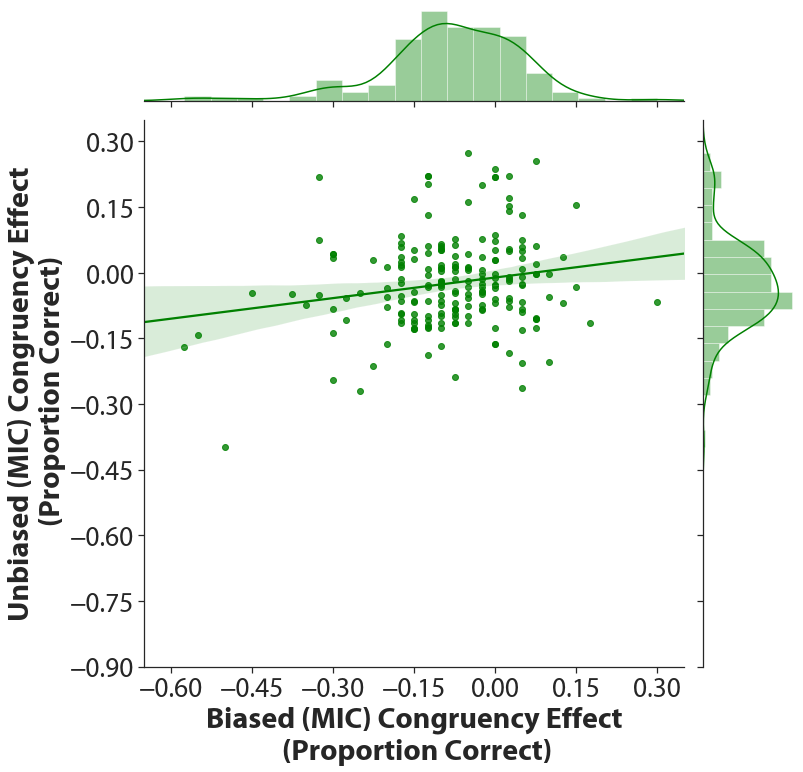

In [127]:
my_corr_graphs(miccong_UB_ACC.Accuracy, miccong_bias_ACC.Accuracy, 'Unbiased (MIC) Congruency Effect\n (Proportion Correct)', 'Biased (MIC) Congruency Effect\n (Proportion Correct)', "biasunbias_micACC.png", 1, ov_mic_UB_ACC.Accuracy, ov_mic_bias_ACC.Accuracy, -0.65,0.35,-0.90,0.35,0.15)

In [128]:
(min(mccong_bias_ACC.Accuracy)),(max(mccong_bias_ACC.Accuracy)), (min(mccong_UB_ACC.Accuracy)), (max(mccong_UB_ACC.Accuracy))

(-0.8466042154566745, 0.11709601873536302, -0.575, 0.17499999999999993)

(LinregressResult(slope=0.605484038794868, intercept=-0.1485880318278376, rvalue=0.4596461914207533, pvalue=5.93405029238726e-12, stderr=0.08272312705499862),
 LinregressResult(slope=0.5241282409701993, intercept=-0.16752811067916928, rvalue=0.5095258805974239, pvalue=9.626115930706011e-15, stderr=0.06258707344942195))

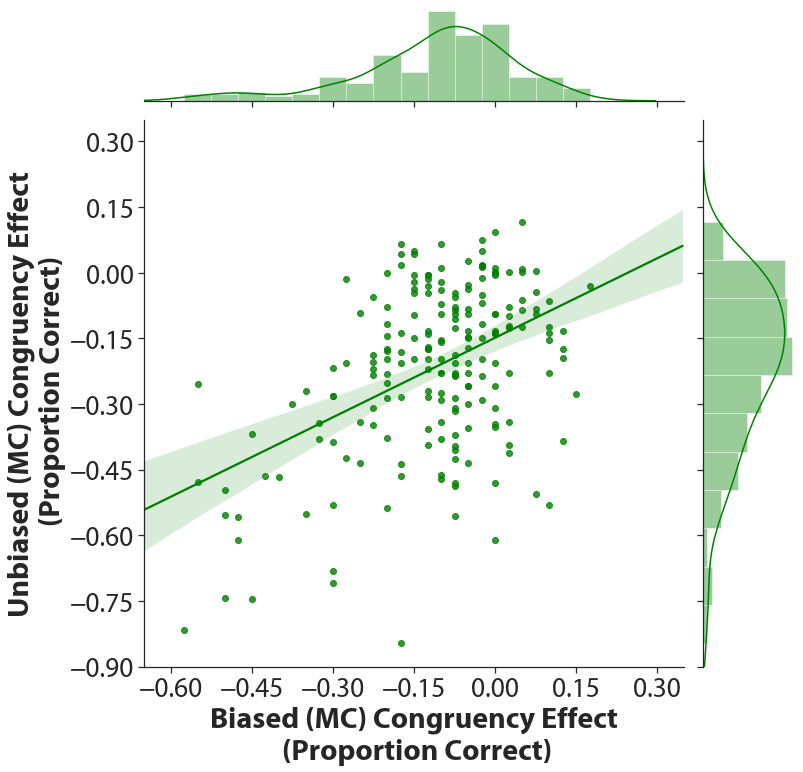

In [129]:
my_corr_graphs(mccong_UB_ACC.Accuracy, mccong_bias_ACC.Accuracy, 'Unbiased (MC) Congruency Effect\n (Proportion Correct)', 'Biased (MC) Congruency Effect\n (Proportion Correct)', "biasunbias_mcACC.png", 1, ov_mc_UB_ACC.Accuracy, ov_mc_bias_ACC.Accuracy, -0.65,0.35,-0.90,0.35,0.15)

Let's compare the correlation coefficients for the unbiased/biased correlations

In [130]:
r, p = stats.pearsonr(mccong_UB.RT, mccong_bias.RT)
n = len(mccong_UB.RT)
r2, p2 = stats.pearsonr(miccong_UB.RT, miccong_bias.RT)
n2 = len(miccong_UB.RT)
independent_corr(r, r2, n, n2, twotailed=True, conf_level=0.95, method='fisher')

(3.0827784568743746, 0.002050777660940195)

In [131]:
r, p = stats.pearsonr((mccong_UB.RT/ov_mc_UB.RT), (mccong_bias.RT/ov_mc_bias.RT))
n = len(mccong_UB.RT)
r2, p2 = stats.pearsonr((miccong_UB.RT/ov_mic_UB.RT), (miccong_bias.RT/ov_mic_bias.RT))
n2 = len(miccong_UB.RT)
independent_corr(r, r2, n, n2, twotailed=True, conf_level=0.95, method='fisher')

(2.757924374238216, 0.0058169653749040595)

In [132]:
r, p = stats.pearsonr(mccong_UB_ACC.Accuracy, mccong_bias_ACC.Accuracy)
n = len(mccong_UB_ACC.Accuracy)
r2, p2 = stats.pearsonr(miccong_UB_ACC.Accuracy, miccong_bias_ACC.Accuracy)
n2 = len(miccong_UB_ACC.Accuracy)
independent_corr(r, r2, n, n2, twotailed=True, conf_level=0.95, method='fisher')

(3.042099393604937, 0.0023493430484990974)

In [133]:
r, p = stats.pearsonr((mccong_UB_ACC.Accuracy/ov_mc_UB_ACC.Accuracy), (mccong_bias_ACC.Accuracy/ov_mc_bias_ACC.Accuracy))
n = len(mccong_UB_ACC.Accuracy)
r2, p2 = stats.pearsonr((miccong_UB_ACC.Accuracy/ov_mic_UB_ACC.Accuracy), (miccong_bias_ACC.Accuracy/ov_mic_bias_ACC.Accuracy))
n2 = len(miccong_UB_ACC.Accuracy)
independent_corr(r, r2, n, n2, twotailed=True, conf_level=0.95, method='fisher')

(3.3194256062091356, 0.0009020283550762453)

Congruency effects for biased and unbiased items were positively correlated in both contexts (RT, r(200) = 0.41, p < 0.001; corrected for overall RT: r(200) = 0.38, p < 0.001; Accuracy, r(200) = 0.46, p < 0.001; corrected for overall Accuracy: r(200) = 0.51, p < 0.001) than the MIC context (RT, r(200) = 0.13, p = 0.076; corrected: r(200) = 0.13, p = 0.069; Accuracy, r(200) = 0.19, p = 0.007; corrected: r(200) = 0.23, p = 0.001). Notably, when we compared the correlation coefficients between the MC and MIC contexts with a Fischer’s r-to-z transformation, we found that the associations were stronger across both RT (uncorrected: z = 3.08, p = 0.002; corrected: z = 2.76, p = 0.006) and Accuracy (uncorrected: z = 3.04, p = 0.002; corrected: z = 3.32, p < 0.001) for the mostly congruent context. This may suggest a more consistent application of (low) control within the mostly congruent context than (high control) in the mostly incongruent context. Overall, these results clearly support the basic assumption of learning from biased items being extended to the application of control to the unbiased items.

# Making Supplementary Tables with 95% Confidence Intervals

Now I'm making the Supplementary tables that show our data in full, with 95% CIs accompanying the means.

In [134]:
import scipy.stats

#credit for simplifying code here: https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
def mean_confidence_interval(data, acc, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    
    #adding a rounded for the sake of the table
    if acc == 0:
        mrounded = np.round(m); lowerci = np.round(m-h); upperci = np.round(m+h)
    elif acc == 1: #can't fully round proportion correct, else it goes to 1.0!
        mrounded = np.round(m,decimals=3); lowerci = np.round(m-h,decimals=3); upperci = np.round(m+h, decimals=3)
    #return m, m-h, m+h
    return mrounded, [lowerci, upperci]

In [135]:
def ci_effects(df, dv, Filter2, Filter3, Context):
    if Context == 1:
        sub_means = df.loc[df['Item']==Filter2].loc[df['BlockOrder']==Filter3].groupby(['subject','ContextCong'])[dv].mean().reset_index()
    elif Context == 2:
        sub_means = df.loc[df['Item']!=Filter2].loc[df['BlockOrder']==Filter3].groupby(['subject','ContextCong'])[dv].mean().reset_index()
    elif Context == 3:
        sub_means = df.loc[df['Item']==Filter2].loc[df['BlockOrder']==Filter3].groupby(['subject','RunCounter','ContextCong'])[dv].mean().reset_index()
    elif Context == 4:
        sub_means = df.loc[df['Item']!=Filter2].loc[df['BlockOrder']==Filter3].groupby(['subject','RunCounter','ContextCong'])[dv].mean().reset_index()
        
    return sub_means

In [136]:
def make_ci_table(df, dv, Filter2, Filter3, Context, Context2, RTacc, tablename):
    
    x = ci_effects(df, dv, Filter2, Filter3, Context);
    overall_MIC_IC = mean_confidence_interval(x.loc[x['ContextCong'] == 'HighIC'][dv],RTacc)
    overall_MIC_C = mean_confidence_interval(x.loc[x['ContextCong'] == 'HighC'][dv],RTacc)
    overall_MC_IC = mean_confidence_interval(x.loc[x['ContextCong'] == 'LowIC'][dv],RTacc)
    overall_MC_C = mean_confidence_interval(x.loc[x['ContextCong'] == 'LowC'][dv],RTacc)
    
    x1 = ci_effects(df, dv, Filter2, Filter3, Context2);
    r1_MIC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighIC'].loc[x1['RunCounter'] == 1][dv],RTacc)
    r1_MIC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighC'].loc[x1['RunCounter'] == 1][dv],RTacc)
    r1_MC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowIC'].loc[x1['RunCounter'] == 1][dv],RTacc)
    r1_MC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowC'].loc[x1['RunCounter'] == 1][dv],RTacc)

    r2_MIC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighIC'].loc[x1['RunCounter'] == 2][dv],RTacc)
    r2_MIC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighC'].loc[x1['RunCounter'] == 2][dv],RTacc)
    r2_MC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowIC'].loc[x1['RunCounter'] == 2][dv],RTacc)
    r2_MC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowC'].loc[x1['RunCounter'] == 2][dv],RTacc)

    r3_MIC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighIC'].loc[x1['RunCounter'] == 3][dv],RTacc)
    r3_MIC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighC'].loc[x1['RunCounter'] == 3][dv],RTacc)
    r3_MC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowIC'].loc[x1['RunCounter'] == 3][dv],RTacc)
    r3_MC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowC'].loc[x1['RunCounter'] == 3][dv],RTacc)
    
    r4_MIC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighIC'].loc[x1['RunCounter'] == 4][dv],RTacc)
    r4_MIC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighC'].loc[x1['RunCounter'] == 4][dv],RTacc)
    r4_MC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowIC'].loc[x1['RunCounter'] == 4][dv],RTacc)
    r4_MC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowC'].loc[x1['RunCounter'] == 4][dv],RTacc)
    
    MyTable = pd.DataFrame({'Context.TrialType': ['MC.C', 'MC.IC', 'MIC.C', 'MIC.IC'],
                     'Run 1': [r1_MC_C, r1_MC_IC, r1_MIC_C, r1_MIC_IC],
                     'Run 2': [r2_MC_C, r2_MC_IC, r2_MIC_C, r2_MIC_IC],
                     'Run 3': [r3_MC_C, r3_MC_IC, r3_MIC_C, r3_MIC_IC],
                     'Run 4': [r4_MC_C, r4_MC_IC, r4_MIC_C, r4_MIC_IC],
                     'Overall': [overall_MC_C, overall_MC_IC, overall_MIC_C, overall_MIC_IC]})

    MyTable.to_csv(csvpath+tablename)
    return MyTable

Biased items via RT: first up MIC-MIC-MC-MC, then MC-MC-MIC-MIC

In [137]:
make_ci_table(cdat, 'RT', 'PC-50', 'IncongFirst', 2, 4, 0, 'biasedRT_SuppTable_MIC.csv')

,Context.TrialType,Run 1,Run 2,Run 3,Run 4,Overall
0,MC.C,"(nan, [nan, nan])","(nan, [nan, nan])","(620.0, [609.0, 631.0])","(622.0, [610.0, 633.0])","(621.0, [610.0, 632.0])"
1,MC.IC,"(nan, [nan, nan])","(nan, [nan, nan])","(717.0, [701.0, 733.0])","(706.0, [689.0, 724.0])","(714.0, [698.0, 729.0])"
2,MIC.C,"(670.0, [655.0, 686.0])","(640.0, [624.0, 656.0])","(nan, [nan, nan])","(nan, [nan, nan])","(655.0, [641.0, 668.0])"
3,MIC.IC,"(703.0, [692.0, 715.0])","(665.0, [654.0, 676.0])","(nan, [nan, nan])","(nan, [nan, nan])","(683.0, [672.0, 693.0])"


In [138]:
make_ci_table(cdat, 'RT', 'PC-50', 'CongFirst', 2, 4, 0, 'biasedRT_SuppTable_MC.csv')

,Context.TrialType,Run 1,Run 2,Run 3,Run 4,Overall
0,MC.C,"(637.0, [627.0, 647.0])","(617.0, [608.0, 626.0])","(nan, [nan, nan])","(nan, [nan, nan])","(627.0, [618.0, 636.0])"
1,MC.IC,"(755.0, [736.0, 774.0])","(730.0, [711.0, 749.0])","(nan, [nan, nan])","(nan, [nan, nan])","(741.0, [725.0, 758.0])"
2,MIC.C,"(nan, [nan, nan])","(nan, [nan, nan])","(626.0, [612.0, 639.0])","(611.0, [598.0, 624.0])","(618.0, [607.0, 629.0])"
3,MIC.IC,"(nan, [nan, nan])","(nan, [nan, nan])","(654.0, [644.0, 665.0])","(643.0, [633.0, 652.0])","(648.0, [639.0, 658.0])"


And for Accuracy, with biased items: first up MIC-MIC-MC-MC, then MC-MC-MIC-MIC

In [139]:
make_ci_table(adat, 'Accuracy', 'PC-50', 'IncongFirst', 2, 4, 1, 'biasedACC_SuppTable_MIC.csv')

,Context.TrialType,Run 1,Run 2,Run 3,Run 4,Overall
0,MC.C,"(nan, [nan, nan])","(nan, [nan, nan])","(0.93, [0.92, 0.941])","(0.936, [0.927, 0.946])","(0.933, [0.925, 0.942])"
1,MC.IC,"(nan, [nan, nan])","(nan, [nan, nan])","(0.753, [0.714, 0.792])","(0.761, [0.718, 0.805])","(0.757, [0.723, 0.792])"
2,MIC.C,"(0.839, [0.805, 0.873])","(0.902, [0.878, 0.925])","(nan, [nan, nan])","(nan, [nan, nan])","(0.87, [0.849, 0.892])"
3,MIC.IC,"(0.788, [0.762, 0.813])","(0.88, [0.865, 0.895])","(nan, [nan, nan])","(nan, [nan, nan])","(0.834, [0.816, 0.851])"


In [140]:
make_ci_table(adat, 'Accuracy', 'PC-50', 'CongFirst', 2, 4, 1, 'biasedACC_SuppTable_MC.csv')

,Context.TrialType,Run 1,Run 2,Run 3,Run 4,Overall
0,MC.C,"(0.868, [0.846, 0.89])","(0.924, [0.912, 0.937])","(nan, [nan, nan])","(nan, [nan, nan])","(0.896, [0.88, 0.912])"
1,MC.IC,"(0.58, [0.532, 0.628])","(0.697, [0.649, 0.745])","(nan, [nan, nan])","(nan, [nan, nan])","(0.639, [0.596, 0.681])"
2,MIC.C,"(nan, [nan, nan])","(nan, [nan, nan])","(0.882, [0.854, 0.91])","(0.89, [0.865, 0.915])","(0.886, [0.865, 0.907])"
3,MIC.IC,"(nan, [nan, nan])","(nan, [nan, nan])","(0.86, [0.842, 0.878])","(0.892, [0.877, 0.906])","(0.876, [0.862, 0.89])"


unbiased items, RT: first up MIC-MIC-MC-MC, then MC-MC-MIC-MIC

In [141]:
make_ci_table(cdat, 'RT', 'PC-50', 'IncongFirst', 1, 3, 0, 'unbiasedRT_SuppTable_MIC.csv')

,Context.TrialType,Run 1,Run 2,Run 3,Run 4,Overall
0,MC.C,"(nan, [nan, nan])","(nan, [nan, nan])","(669.0, [659.0, 679.0])","(661.0, [649.0, 673.0])","(665.0, [654.0, 676.0])"
1,MC.IC,"(nan, [nan, nan])","(nan, [nan, nan])","(721.0, [708.0, 733.0])","(710.0, [698.0, 722.0])","(715.0, [704.0, 726.0])"
2,MIC.C,"(683.0, [670.0, 696.0])","(655.0, [644.0, 666.0])","(nan, [nan, nan])","(nan, [nan, nan])","(668.0, [658.0, 679.0])"
3,MIC.IC,"(740.0, [728.0, 753.0])","(707.0, [696.0, 718.0])","(nan, [nan, nan])","(nan, [nan, nan])","(721.0, [710.0, 732.0])"


In [142]:
make_ci_table(cdat, 'RT', 'PC-50', 'CongFirst', 1, 3, 0, 'unbiasedRT_SuppTable_MC.csv')

,Context.TrialType,Run 1,Run 2,Run 3,Run 4,Overall
0,MC.C,"(677.0, [666.0, 688.0])","(657.0, [645.0, 669.0])","(nan, [nan, nan])","(nan, [nan, nan])","(667.0, [656.0, 677.0])"
1,MC.IC,"(748.0, [735.0, 761.0])","(733.0, [721.0, 746.0])","(nan, [nan, nan])","(nan, [nan, nan])","(739.0, [728.0, 750.0])"
2,MIC.C,"(nan, [nan, nan])","(nan, [nan, nan])","(659.0, [649.0, 670.0])","(655.0, [644.0, 666.0])","(657.0, [647.0, 668.0])"
3,MIC.IC,"(nan, [nan, nan])","(nan, [nan, nan])","(718.0, [706.0, 729.0])","(696.0, [684.0, 708.0])","(707.0, [696.0, 717.0])"


unbiased, accuracy: first up MIC-MIC-MC-MC, then MC-MC-MIC-MIC

In [143]:
make_ci_table(adat, 'Accuracy', 'PC-50', 'IncongFirst', 1, 3, 1, 'unbiasedACC_SuppTable_MIC.csv')

,Context.TrialType,Run 1,Run 2,Run 3,Run 4,Overall
0,MC.C,"(nan, [nan, nan])","(nan, [nan, nan])","(0.854, [0.83, 0.879])","(0.871, [0.85, 0.892])","(0.863, [0.842, 0.883])"
1,MC.IC,"(nan, [nan, nan])","(nan, [nan, nan])","(0.774, [0.745, 0.803])","(0.837, [0.812, 0.862])","(0.805, [0.781, 0.829])"
2,MIC.C,"(0.81, [0.781, 0.839])","(0.855, [0.832, 0.878])","(nan, [nan, nan])","(nan, [nan, nan])","(0.833, [0.811, 0.854])"
3,MIC.IC,"(0.661, [0.622, 0.701])","(0.816, [0.791, 0.84])","(nan, [nan, nan])","(nan, [nan, nan])","(0.738, [0.711, 0.766])"


In [144]:
make_ci_table(adat, 'Accuracy', 'PC-50', 'CongFirst', 1, 3, 1, 'unbiasedACC_SuppTable_MC.csv')

,Context.TrialType,Run 1,Run 2,Run 3,Run 4,Overall
0,MC.C,"(0.827, [0.799, 0.856])","(0.849, [0.823, 0.876])","(nan, [nan, nan])","(nan, [nan, nan])","(0.838, [0.813, 0.864])"
1,MC.IC,"(0.604, [0.562, 0.645])","(0.738, [0.707, 0.769])","(nan, [nan, nan])","(nan, [nan, nan])","(0.671, [0.638, 0.703])"
2,MIC.C,"(nan, [nan, nan])","(nan, [nan, nan])","(0.839, [0.813, 0.865])","(0.882, [0.862, 0.902])","(0.86, [0.84, 0.881])"
3,MIC.IC,"(nan, [nan, nan])","(nan, [nan, nan])","(0.774, [0.745, 0.802])","(0.816, [0.791, 0.841])","(0.795, [0.771, 0.819])"


# Post-test / Filler Task Questionnaire Data

### Information about How These Data Are Organized

We collected demographic variables such as `gender`, `age`, `ethnicity`, and `race`. Listed in `AllSubsDemo.csv`. For `race`, AI meant American Indian/Alaska Native, A meant Asian, NH meant Native Hawaiian/Other Pacific Islander, AA meant African American/Black, W meant Caucasian/White, M meant Multiracial, O meant Other, NA meant Do not wish to reply. For `ethnicity`, HL meant Hispanic/Latino, NHL meant Non-Hispanic/Latino, NA meant Do no wish to reply. There was a validater that made sure there was a value for each, but for 2 participants, there is nothing listed for ethnicity (not sure why). For `gender`, F meant Female, M meant Male, T meant Trans*, NA meant do not wish to reply. `Age` was self-entered by the participant. One participant had an age of 258, and it is unclear whether they meant 25, 58, or 28. 

W/in `AllSubsPostTest.csv`:

`subject` indicates the deidentified participant.

`BlockVaryQ` indicates 1 ('yes') or 0 ('no') in response to the prompt "Did you notice any systematic variation in how often particular **blocks/runs** were associated with an **easy** (congruent) trial (i.e., the color of the color-word matched the meaning of the color-word) or **hard** (incongruent) trial (i.e., the color of the color-word DID NOT match its meaning)?"

`ItemVaryQ` indicates 1 ('yes') or 0 ('no') in response to the prompt "Did you notice any systematic variation in how often particular **color-words** were associated with an **easy** (congruent) trial (i.e., the color of the color-word matched the meaning of the color-word) or **hard** (incongruent) trial (i.e., the color of the color-word DID NOT match its meaning)?"

`FreqPredict_1`, `FreqPredict_2`, `FreqPredict_3`, `FreqPredict_4`, `FreqPredict_5` indicate participants' rating for red + orange, red + yellow, red + green, red + blue, and red + purple in response to the prompt "The frequency of **easy** (congruent) and **hard** (incongruent) trials may have been determined by each individual color-word or a combination of color-words. For instance, this frequency might have been manipulated so that red and orange, red and yellow, red and green, red and blue, red and purple were both more likely to involve either easy or hard trials. Please rate the likelihood of each pairing predicting a particular trial type." Always anchored 100, Balanced anchored 50, and Never anchored 0. We test against 50 to look at whether participants thought any word pairing had predictive value.

`SCForcedChoice_RED`, `SCForcedChoice_ORANGE`, `SCForcedChoice_YELLOW`, `SCForcedChoice_GREEN`, `SCForcedChoice_BLUE`, `SCForcedChoice_PURPLE` indicate participants' choice of incongruent/hard, congruent/easy, or neutral for the different color-word stimuli (randomized presentation) in response to the question "Which trial type was each color-word most often associated with?". The prompt itself said: "**Hard** (incongruent) **trials** (i.e., the color of the color-word DID NOT match the meaning of the color-word) may have occurred more frequently for **two of these color-words**, while **easy** (congruent) **trials** (i.e., the color of the color-word matched its meaning) may have occurred more frequently for the other **two color-words**. **Two other color-words** may have been **neutral** (i.e., equal likelihood of being hard or easy). In other words, there are two color-words for each trial type. Please match each color-word to its most likely trial type."

Because each participant had a random color-word pairing (i.e., whether "red" represented the PC-90, PC-10, or PC-50 item), I subsequently calculated `SCForcedChoice` (all items, range [0, 6]), `SCForcedChoice_bias` (PC-90 & PC-10 items, range [0, 4]), and `SCForcedChoice_LWPC` (PC-50 items, range [0, 2]).

W/in `AllSubsBisBas.csv`:

The *following items* are from Carver, C. S., & White, T. L. (1994). Behavioral inhibition, behavioral activation, and affective responses to impending reward and punishment: The BIS/BAS scales. Journal of Personality and Social Psychology, 67, 319-333.

Items other than 2 and 22 are reverse scored. The scale is from 1 to 4 (1 = very true for me, 2 = somewhat true for me, 3 = somewhat false for me, 4 = very false for me).

<em>BAS Drive</em>: 3, 9, 12, 21.

<em>BAS Fun Seeking</em>: 5, 10, 15, 20.

<em>BAS Reward Responsiveness</em>: 4, 7, 14, 18, 23.

<em>BIS</em>: 2, 8, 13, 16, 19, 22, 24.

Items 1, 6, 11, 17 are fillers. I will not be doing anything with these items.

---

Now let's calculate the reported age and gender of our participants...

In [145]:
%cd C:\Users\cb383\Desktop\YearFour\controllearning\LWPCtufb\data

C:\Users\cb383\Desktop\YearFour\controllearning\LWPCtufb\data


In [146]:
demo = pd.read_csv('AllSubsDemo.csv')
demwide = pd.DataFrame()

In [147]:
lists = [[] for list in range(0,6)]
    
for ID in np.unique(demo.subject):
    sub = demo[demo.subject == ID].reset_index()
    lists[0].append(ID)
    eth = sub[sub.question == 'Ethnicity'].reset_index().data.pop(0)
    race = sub[sub.question == 'Race'].reset_index().data.pop(0)
    gender = sub[sub.question == 'Gender'].reset_index().data.pop(0)
    age = sub[sub.question == 'Age'].reset_index().data.pop(0)
    pop = sub.population.pop(0)
    lists[1].append(eth)
    lists[2].append(race)
    lists[3].append(gender)
    lists[4].append(int(age))
    lists[5].append(pop)
        
demwide['subject'] = lists[0]
demwide['Ethnicity'] = lists[1]
demwide['Race'] = lists[2]
demwide['Gender'] = lists[3]
demwide['Age'] = lists[4]
demwide['population'] = lists[5]

In [148]:
MTurk = demwide.loc[demwide['population'] == 1]
SONA = demwide.loc[demwide['population'] == 2]

In [149]:
np.where(pd.isnull(MTurk))

(array([57], dtype=int64), array([1], dtype=int64))

In [150]:
MTurk.loc[MTurk['subject']==58]

,subject,Ethnicity,Race,Gender,Age,population
57,58,NaN,AA,M,31,1


In [151]:
print("Non-Hisp Asian/AA F:" + str(len(MTurk.loc[MTurk['Gender'] == "F"].loc[MTurk['Race'] == 'A'].loc[MTurk['Ethnicity']=='NHL'])))
print("Hisp Asian/AA F:" + str(len(MTurk.loc[MTurk['Gender'] == "F"].loc[MTurk['Race'] == 'A'].loc[MTurk['Ethnicity']=='HL'])))
print("Non-Hisp Am Ind/Alas Nat F:" + str(len(MTurk.loc[MTurk['Gender'] == "F"].loc[MTurk['Race'] == 'AI'].loc[MTurk['Ethnicity']=='NHL'])))
print("Hisp Am Ind/Alas Nat F:" + str(len(MTurk.loc[MTurk['Gender'] == "F"].loc[MTurk['Race'] == 'AI'].loc[MTurk['Ethnicity']=='HL'])))
print("Non-Hisp Nat Hawaii/PI F:" + str(len(MTurk.loc[MTurk['Gender'] == "F"].loc[MTurk['Race'] == 'NH'].loc[MTurk['Ethnicity']=='NHL'])))
print("Hisp Nat Hawaii/PI F:" + str(len(MTurk.loc[MTurk['Gender'] == "F"].loc[MTurk['Race'] == 'NH'].loc[MTurk['Ethnicity']=='HL'])))
print("Non-Hisp African American/Black F:" + str(len(MTurk.loc[MTurk['Gender'] == "F"].loc[MTurk['Race'] == 'AA'].loc[MTurk['Ethnicity']=='NHL'])))
print("Hisp African American/Black F:" + str(len(MTurk.loc[MTurk['Gender'] == "F"].loc[MTurk['Race'] == 'AA'].loc[MTurk['Ethnicity']=='HL'])))
print("Non-Hisp Multirac F:" + str(len(MTurk.loc[MTurk['Gender'] == "F"].loc[MTurk['Race'] == 'M'].loc[MTurk['Ethnicity']=='NHL'])))
print("Hisp Multirac F:" + str(len(MTurk.loc[MTurk['Gender'] == "F"].loc[MTurk['Race'] == 'M'].loc[MTurk['Ethnicity']=='HL'])))
print("Non-Hisp Other F:" + str(len(MTurk.loc[MTurk['Gender'] == "F"].loc[MTurk['Race'] == 'O'].loc[MTurk['Ethnicity']=='NHL'])))
print("Hisp Other F:" + str(len(MTurk.loc[MTurk['Gender'] == "F"].loc[MTurk['Race'] == 'O'].loc[MTurk['Ethnicity']=='HL'])))
print("Non-Hisp Cauc/White F:" + str(len(MTurk.loc[MTurk['Gender'] == "F"].loc[MTurk['Race'] == 'W'].loc[MTurk['Ethnicity']=='NHL'])))
print("Hisp Cauc/White F:" + str(len(MTurk.loc[MTurk['Gender'] == "F"].loc[MTurk['Race'] == 'W'].loc[MTurk['Ethnicity']=='HL'])))
print("Non-Hisp NoReply F:" + str(len(MTurk.loc[MTurk['Gender'] == "F"].loc[MTurk['Race'] == 'NA'].loc[MTurk['Ethnicity']=='NHL'])))
print("Hisp NoReply F:" + str(len(MTurk.loc[MTurk['Gender'] == "F"].loc[MTurk['Race'] == 'NA'].loc[MTurk['Ethnicity']=='HL'])))

Non-Hisp Asian/AA F:6
Hisp Asian/AA F:0
Non-Hisp Am Ind/Alas Nat F:0
Hisp Am Ind/Alas Nat F:0
Non-Hisp Nat Hawaii/PI F:0
Hisp Nat Hawaii/PI F:0
Non-Hisp African American/Black F:1
Hisp African American/Black F:1
Non-Hisp Multirac F:0
Hisp Multirac F:2
Non-Hisp Other F:0
Hisp Other F:0
Non-Hisp Cauc/White F:23
Hisp Cauc/White F:3
Non-Hisp NoReply F:0
Hisp NoReply F:0


In [152]:
print("Non-Hisp Asian/AA M:" + str(len(MTurk.loc[MTurk['Gender'] == "M"].loc[MTurk['Race'] == 'A'].loc[MTurk['Ethnicity']=='NHL'])))
print("Hisp Asian/AA M:" + str(len(MTurk.loc[MTurk['Gender'] == "M"].loc[MTurk['Race'] == 'A'].loc[MTurk['Ethnicity']=='HL'])))
print("Non-Hisp Am Ind/Alas Nat M:" + str(len(MTurk.loc[MTurk['Gender'] == "M"].loc[MTurk['Race'] == 'AI'].loc[MTurk['Ethnicity']=='NHL'])))
print("Hisp Am Ind/Alas Nat M:" + str(len(MTurk.loc[MTurk['Gender'] == "M"].loc[MTurk['Race'] == 'AI'].loc[MTurk['Ethnicity']=='HL'])))
print("Non-Hisp Nat Hawaii/PI M:" + str(len(MTurk.loc[MTurk['Gender'] == "M"].loc[MTurk['Race'] == 'NH'].loc[MTurk['Ethnicity']=='NHL'])))
print("Hisp Nat Hawaii/PI M:" + str(len(MTurk.loc[MTurk['Gender'] == "M"].loc[MTurk['Race'] == 'NH'].loc[MTurk['Ethnicity']=='HL'])))
print("Non-Hisp African American/Black M:" + str(len(MTurk.loc[MTurk['Gender'] == "M"].loc[MTurk['Race'] == 'AA'].loc[MTurk['Ethnicity']=='NHL'])))
print("Hisp African American/Black M:" + str(len(MTurk.loc[MTurk['Gender'] == "M"].loc[MTurk['Race'] == 'AA'].loc[MTurk['Ethnicity']=='HL'])))
print("Non-Hisp Multirac M:" + str(len(MTurk.loc[MTurk['Gender'] == "M"].loc[MTurk['Race'] == 'M'].loc[MTurk['Ethnicity']=='NHL'])))
print("Hisp Multirac M:" + str(len(MTurk.loc[MTurk['Gender'] == "M"].loc[MTurk['Race'] == 'M'].loc[MTurk['Ethnicity']=='HL'])))
print("Non-Hisp Other M:" + str(len(MTurk.loc[MTurk['Gender'] == "M"].loc[MTurk['Race'] == 'O'].loc[MTurk['Ethnicity']=='NHL'])))
print("Hisp Other M:" + str(len(MTurk.loc[MTurk['Gender'] == "M"].loc[MTurk['Race'] == 'O'].loc[MTurk['Ethnicity']=='HL'])))
print("Non-Hisp Cauc/White M:" + str(len(MTurk.loc[MTurk['Gender'] == "M"].loc[MTurk['Race'] == 'W'].loc[MTurk['Ethnicity']=='NHL'])))
print("Hisp Cauc/White M:" + str(len(MTurk.loc[MTurk['Gender'] == "M"].loc[MTurk['Race'] == 'W'].loc[MTurk['Ethnicity']=='HL'])))
print("Non-Hisp NoReply M:" + str(len(MTurk.loc[MTurk['Gender'] == "M"].loc[MTurk['Race'] == 'NA'].loc[MTurk['Ethnicity']=='NHL'])))
print("Hisp NoReply M:" + str(len(MTurk.loc[MTurk['Gender'] == "M"].loc[MTurk['Race'] == 'NA'].loc[MTurk['Ethnicity']=='HL'])))

Non-Hisp Asian/AA M:3
Hisp Asian/AA M:0
Non-Hisp Am Ind/Alas Nat M:1
Hisp Am Ind/Alas Nat M:1
Non-Hisp Nat Hawaii/PI M:0
Hisp Nat Hawaii/PI M:0
Non-Hisp African American/Black M:5
Hisp African American/Black M:4
Non-Hisp Multirac M:0
Hisp Multirac M:1
Non-Hisp Other M:0
Hisp Other M:0
Non-Hisp Cauc/White M:32
Hisp Cauc/White M:2
Non-Hisp NoReply M:0
Hisp NoReply M:0


In [153]:
MTurk.loc[MTurk['Gender'] == "T"]

,subject,Ethnicity,Race,Gender,Age,population
7,8,NHL,W,T,34,1
73,74,NHL,A,T,23,1


In [154]:
np.where(pd.isnull(SONA))

(array([ 0,  4, 67], dtype=int64), array([1, 1, 1], dtype=int64))

In [155]:
SONA.loc[SONA['subject']==89] #sub 1 = 89 (i.e., position 0 in the array)
SONA.loc[SONA['subject']==93]
SONA.loc[SONA['subject']==156]

,subject,Ethnicity,Race,Gender,Age,population
88,89,NaN,W,M,19,2


,subject,Ethnicity,Race,Gender,Age,population
92,93,NaN,W,F,19,2


,subject,Ethnicity,Race,Gender,Age,population
155,156,NaN,W,F,18,2


In [156]:
print("Non-Hisp Asian/AA F:" + str(len(SONA.loc[SONA['Gender'] == "F"].loc[SONA['Race'] == 'A'].loc[SONA['Ethnicity']=='NHL'])))
print("Hisp Asian/AA F:" + str(len(SONA.loc[SONA['Gender'] == "F"].loc[SONA['Race'] == 'A'].loc[SONA['Ethnicity']=='HL'])))
print("Non-Hisp Am Ind/Alas Nat F:" + str(len(SONA.loc[SONA['Gender'] == "F"].loc[SONA['Race'] == 'AI'].loc[SONA['Ethnicity']=='NHL'])))
print("Hisp Am Ind/Alas Nat F:" + str(len(SONA.loc[SONA['Gender'] == "F"].loc[SONA['Race'] == 'AI'].loc[SONA['Ethnicity']=='HL'])))
print("Non-Hisp Nat Hawaii/PI F:" + str(len(SONA.loc[SONA['Gender'] == "F"].loc[SONA['Race'] == 'NH'].loc[SONA['Ethnicity']=='NHL'])))
print("Hisp Nat Hawaii/PI F:" + str(len(SONA.loc[SONA['Gender'] == "F"].loc[SONA['Race'] == 'NH'].loc[SONA['Ethnicity']=='HL'])))
print("Non-Hisp African American/Black F:" + str(len(SONA.loc[SONA['Gender'] == "F"].loc[SONA['Race'] == 'AA'].loc[SONA['Ethnicity']=='NHL'])))
print("Hisp African American/Black F:" + str(len(SONA.loc[SONA['Gender'] == "F"].loc[SONA['Race'] == 'AA'].loc[SONA['Ethnicity']=='HL'])))
print("Non-Hisp Multirac F:" + str(len(SONA.loc[SONA['Gender'] == "F"].loc[SONA['Race'] == 'M'].loc[SONA['Ethnicity']=='NHL'])))
print("Hisp Multirac F:" + str(len(SONA.loc[SONA['Gender'] == "F"].loc[SONA['Race'] == 'M'].loc[SONA['Ethnicity']=='HL'])))
print("Non-Hisp Other F:" + str(len(SONA.loc[SONA['Gender'] == "F"].loc[SONA['Race'] == 'O'].loc[SONA['Ethnicity']=='NHL'])))
print("Hisp Other F:" + str(len(SONA.loc[SONA['Gender'] == "F"].loc[SONA['Race'] == 'O'].loc[SONA['Ethnicity']=='HL'])))
print("Non-Hisp Cauc/White F:" + str(len(SONA.loc[SONA['Gender'] == "F"].loc[SONA['Race'] == 'W'].loc[SONA['Ethnicity']=='NHL'])))
print("Hisp Cauc/White F:" + str(len(SONA.loc[SONA['Gender'] == "F"].loc[SONA['Race'] == 'W'].loc[SONA['Ethnicity']=='HL'])))
print("Non-Hisp NoReply F:" + str(len(SONA.loc[SONA['Gender'] == "F"].loc[SONA['Race'] == 'NA'].loc[SONA['Ethnicity']=='NHL'])))
print("Hisp NoReply F:" + str(len(SONA.loc[SONA['Gender'] == "F"].loc[SONA['Race'] == 'NA'].loc[SONA['Ethnicity']=='HL'])))

Non-Hisp Asian/AA F:20
Hisp Asian/AA F:0
Non-Hisp Am Ind/Alas Nat F:1
Hisp Am Ind/Alas Nat F:0
Non-Hisp Nat Hawaii/PI F:0
Hisp Nat Hawaii/PI F:0
Non-Hisp African American/Black F:3
Hisp African American/Black F:0
Non-Hisp Multirac F:4
Hisp Multirac F:1
Non-Hisp Other F:0
Hisp Other F:0
Non-Hisp Cauc/White F:32
Hisp Cauc/White F:14
Non-Hisp NoReply F:0
Hisp NoReply F:0


In [157]:
print("Non-Hisp Asian/AA M:" + str(len(SONA.loc[SONA['Gender'] == "M"].loc[SONA['Race'] == 'A'].loc[SONA['Ethnicity']=='NHL'])))
print("Hisp Asian/AA M:" + str(len(SONA.loc[SONA['Gender'] == "M"].loc[SONA['Race'] == 'A'].loc[SONA['Ethnicity']=='HL'])))
print("Non-Hisp Am Ind/Alas Nat M:" + str(len(SONA.loc[SONA['Gender'] == "M"].loc[SONA['Race'] == 'AI'].loc[SONA['Ethnicity']=='NHL'])))
print("Hisp Am Ind/Alas Nat M:" + str(len(SONA.loc[SONA['Gender'] == "M"].loc[SONA['Race'] == 'AI'].loc[SONA['Ethnicity']=='HL'])))
print("Non-Hisp Nat Hawaii/PI M:" + str(len(SONA.loc[SONA['Gender'] == "M"].loc[SONA['Race'] == 'NH'].loc[SONA['Ethnicity']=='NHL'])))
print("Hisp Nat Hawaii/PI M:" + str(len(SONA.loc[SONA['Gender'] == "M"].loc[SONA['Race'] == 'NH'].loc[SONA['Ethnicity']=='HL'])))
print("Non-Hisp African American/Black M:" + str(len(SONA.loc[SONA['Gender'] == "M"].loc[SONA['Race'] == 'AA'].loc[SONA['Ethnicity']=='NHL'])))
print("Hisp African American/Black M:" + str(len(SONA.loc[SONA['Gender'] == "M"].loc[SONA['Race'] == 'AA'].loc[SONA['Ethnicity']=='HL'])))
print("Non-Hisp Multirac M:" + str(len(SONA.loc[SONA['Gender'] == "M"].loc[SONA['Race'] == 'M'].loc[SONA['Ethnicity']=='NHL'])))
print("Hisp Multirac M:" + str(len(SONA.loc[SONA['Gender'] == "M"].loc[SONA['Race'] == 'M'].loc[SONA['Ethnicity']=='HL'])))
print("Non-Hisp Other M:" + str(len(SONA.loc[SONA['Gender'] == "M"].loc[SONA['Race'] == 'O'].loc[SONA['Ethnicity']=='NHL'])))
print("Hisp Other M:" + str(len(SONA.loc[SONA['Gender'] == "M"].loc[SONA['Race'] == 'O'].loc[SONA['Ethnicity']=='HL'])))
print("Non-Hisp Cauc/White M:" + str(len(SONA.loc[SONA['Gender'] == "M"].loc[SONA['Race'] == 'W'].loc[SONA['Ethnicity']=='NHL'])))
print("Hisp Cauc/White M:" + str(len(SONA.loc[SONA['Gender'] == "M"].loc[SONA['Race'] == 'W'].loc[SONA['Ethnicity']=='HL'])))
print("Non-Hisp NoReply M:" + str(len(SONA.loc[SONA['Gender'] == "M"].loc[SONA['Race'] == 'NA'].loc[SONA['Ethnicity']=='NHL'])))
print("Hisp NoReply M:" + str(len(SONA.loc[SONA['Gender'] == "M"].loc[SONA['Race'] == 'NA'].loc[SONA['Ethnicity']=='HL'])))

Non-Hisp Asian/AA M:10
Hisp Asian/AA M:0
Non-Hisp Am Ind/Alas Nat M:0
Hisp Am Ind/Alas Nat M:0
Non-Hisp Nat Hawaii/PI M:0
Hisp Nat Hawaii/PI M:0
Non-Hisp African American/Black M:7
Hisp African American/Black M:1
Non-Hisp Multirac M:3
Hisp Multirac M:1
Non-Hisp Other M:0
Hisp Other M:0
Non-Hisp Cauc/White M:13
Hisp Cauc/White M:1
Non-Hisp NoReply M:0
Hisp NoReply M:0


In [158]:
ageMTurk = MTurk.loc[MTurk['Age'] != 258].reset_index()

In [159]:
np.nanmean(ageMTurk.Age, dtype=float, axis=0)

37.85057471264368

In [160]:
np.nanmean(SONA.Age, dtype=float, axis=0)

19.236842105263158

In [161]:
np.nanstd(ageMTurk.Age)

10.895036026307254

In [162]:
np.nanstd(SONA.Age)

1.0370558155388439

Now onto the BIS-BAS questionnaire.

Note that subject 89 did not have any BIS-BAS data, and subject 186 did not have any memory data, so both of these subjects will be excluded from the relevant analyses.

In [163]:
bb = pd.read_csv('AllSubsBisBas.csv')

In [164]:
bb.BisBasResp = 5 - bb.BisBasResp

In [165]:
bbRR4 = bb.loc[bb['BisBasQ'] == 'bisbas-4'].BisBasResp
bbRR7 = bb.loc[bb['BisBasQ'] == 'bisbas-7'].BisBasResp
bbRR14 = bb.loc[bb['BisBasQ'] == 'bisbas-14'].BisBasResp
bbRR18 = bb.loc[bb['BisBasQ'] == 'bisbas-18'].BisBasResp
bbRR23 = bb.loc[bb['BisBasQ'] == 'bisbas-23'].BisBasResp

bbD3 = bb.loc[bb['BisBasQ'] == 'bisbas-3'].BisBasResp
bbD9 = bb.loc[bb['BisBasQ'] == 'bisbas-9'].BisBasResp
bbD12 = bb.loc[bb['BisBasQ'] == 'bisbas-12'].BisBasResp
bbD21 = bb.loc[bb['BisBasQ'] == 'bisbas-21'].BisBasResp

bbFS5 = bb.loc[bb['BisBasQ'] == 'bisbas-5'].BisBasResp
bbFS10 = bb.loc[bb['BisBasQ'] == 'bisbas-10'].BisBasResp
bbFS15 = bb.loc[bb['BisBasQ'] == 'bisbas-15'].BisBasResp
bbFS20 = bb.loc[bb['BisBasQ'] == 'bisbas-20'].BisBasResp

bbB8 = bb.loc[bb['BisBasQ'] == 'bisbas-8'].BisBasResp
bbB13 = bb.loc[bb['BisBasQ'] == 'bisbas-13'].BisBasResp
bbB16 = bb.loc[bb['BisBasQ'] == 'bisbas-16'].BisBasResp
bbB19 = bb.loc[bb['BisBasQ'] == 'bisbas-19'].BisBasResp
bbB24 = bb.loc[bb['BisBasQ'] == 'bisbas-24'].BisBasResp
bbB2 = bb.loc[bb['BisBasQ'] == 'bisbas-2'].BisBasResp
bbB22 = bb.loc[bb['BisBasQ'] == 'bisbas-22'].BisBasResp

#shouldn't be reverse coded
bbB2 = 5 - bbB2;
bbB22 = 5 - bbB22;

In [166]:
bas_drive = np.sum([bbD3,bbD9,bbD12,bbD21],axis=0)
bas_funseeking = np.sum([bbFS5,bbFS10,bbFS15,bbFS20],axis=0)
bas_rewardresp = np.sum([bbRR4,bbRR7,bbRR14,bbRR18,bbRR23],axis=0)
bis = np.sum([bbB8,bbB13,bbB16,bbB19,bbB24,bbB2,bbB22],axis=0)
sub = list(set(bb.subject))

#get into the right file format
bRR = pd.DataFrame({'RR': bas_rewardresp, 'subject':sub})
bBIS = pd.DataFrame({'BIS': bis, 'subject':sub})

If performance feedback promotes proactive control via a motivational route (“motivation hypothesis”), the expression of the LWPC effect within individuals should be positively associated with trait reward responsiveness. Trait reward responsiveness was assessed with the reward responsiveness subscale of the BIS-BAS (Carver & White, 1994), which participants filled out as part of the Filler Phase between the learning and memory phases.

In [167]:
#sub 89 had no bis-bas, so excluding here
SCT_RT_FB = SCT_RT_FB.loc[SCT_RT_FB['index']!=88]
SCT_ACC_FB = SCT_ACC_FB.loc[SCT_ACC_FB['index']!=88]
overallRT_T = overallRT_T.loc[overallRT_T['index']!=88]
overallACC_T = overallACC_T.loc[overallACC_T['index']!=88]
SC_RT_FB = SC_RT_FB.loc[SC_RT_FB['index']!=88]
SC_ACC_FB = SC_ACC_FB.loc[SC_ACC_FB['index']!=88]
overallMainRT = overallMainRT.loc[overallMainRT['index']!=88]
overallMainACC = overallMainACC.loc[overallMainACC['index']!=88]

In [168]:
def id_corr_graphs(x, y, ylabel, xlabel, figname, selectsubs, corrxvalue, xmin, xmax, ymin, ymax, stepsize1, stepsize2):
    plot = sns.jointplot(x=x, y=y, kind="reg", height=11, ratio=5, color = 'g');
    plt.ylabel(ylabel, fontweight="bold");
    plt.xlabel(xlabel, fontweight="bold");
    plot.ax_marg_x.set_xlim(xmin, xmax);
    plot.ax_marg_y.set_ylim(ymin, ymax);
    plot.ax_joint.xaxis.set_major_locator(ticker.MultipleLocator(stepsize1));
    plot.ax_joint.yaxis.set_major_locator(ticker.MultipleLocator(stepsize2));
    plb.savefig(figurepath+figname, dpi = 300)
    regstat = stats.linregress(x,y)
    
    if selectsubs == 1:
        corrx = x/corrxvalue
        corry = y
    else:
        corrx = x.reset_index(drop=True)/corrxvalue
        corry = y
        
    corrstat = stats.linregress(corrx,corry)
    return regstat, corrstat

In [169]:
bRR = bRR.reset_index()
bBIS = bBIS.reset_index()

In [170]:
bRR = bRR.loc[bRR['subject']!=89]
bBIS = bBIS.loc[bBIS['subject']!=89]

In [171]:
round(min(SCT_RT_FB.RTs)), round(max(SCT_RT_FB.RTs)), round(min(bRR.RR)), round(max(bRR.RR)), round(min(bBIS.BIS)), round(max(bBIS.BIS))

(-117, 127, 7, 20, 7, 28)

(LinregressResult(slope=-0.004434036255014031, intercept=16.989470767925237, rvalue=-0.0854997516561564, pvalue=0.22750173201811655, stderr=0.0036628119838674894),
 LinregressResult(slope=-2.9564833302752778, intercept=16.98805216969446, rvalue=-0.08378171359977439, pvalue=0.2370141545750824, stderr=2.492700178717374))

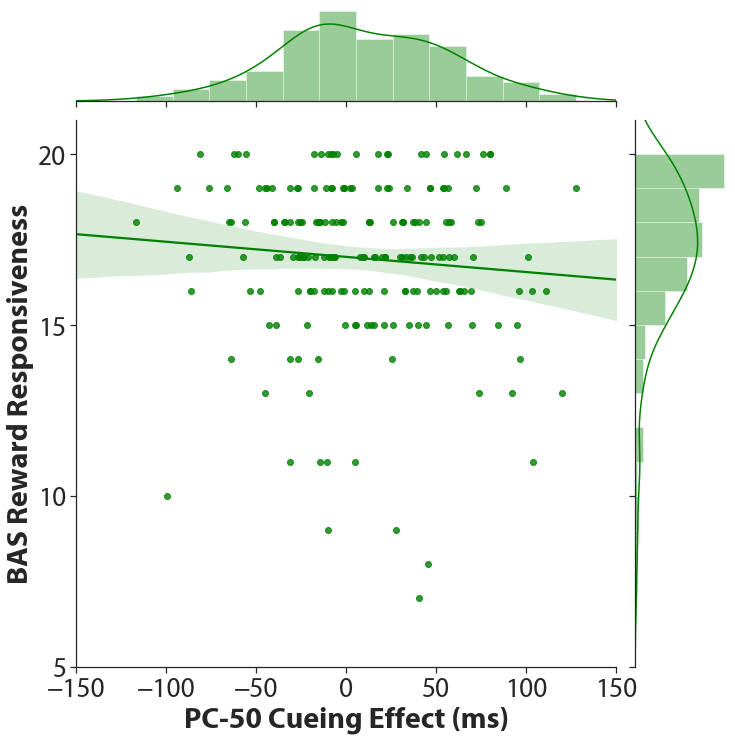

In [172]:
id_corr_graphs(SCT_RT_FB.RTs,bRR.RR,'BAS Reward Responsiveness','PC-50 Cueing Effect (ms)',"SCT_RT_RR_id.png", 1, overallRT_T.RT, -150, 150, 5, 21, 50, 5)

In [173]:
(min(SCT_ACC_FB.ACC)), (max(SCT_ACC_FB.ACC)), round(min(bRR.RR)), round(max(bRR.RR))

(-0.475, 0.42500000000000004, 7, 20)

(LinregressResult(slope=2.135331473979321, intercept=17.011405166296125, rvalue=0.14379264624880958, pvalue=0.04170081021701865, stderr=1.041754089093954),
 LinregressResult(slope=1.71939401522331, intercept=17.01545681946561, rvalue=0.15263345589582392, pvalue=0.030529851528253583, stderr=0.7891878712039313))

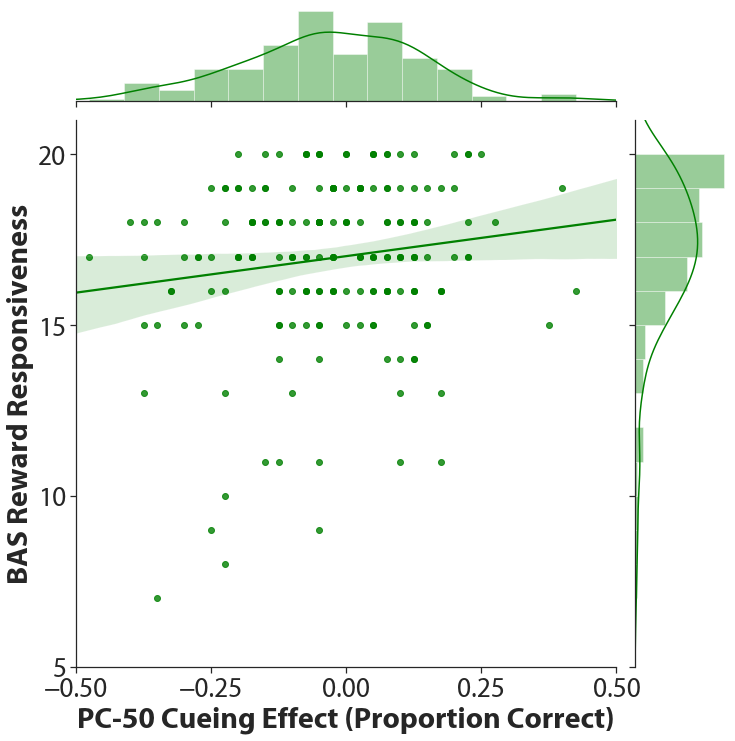

In [174]:
id_corr_graphs(SCT_ACC_FB.ACC,bRR.RR,'BAS Reward Responsiveness', 'PC-50 Cueing Effect (Proportion Correct)', "SCT_ACC_RR_id.png", 1, overallACC_T.Accuracy, -0.5, 0.5, 5, 21, 0.25, 5)

What about the biased PC-90/10 items?

In [175]:
round(min(SC_RT_FB.RTs)), round(max(SC_RT_FB.RTs)), round(min(bRR.RR)), round(max(bRR.RR))

(-186, 320, 7, 20)

(LinregressResult(slope=-0.00291521139579088, intercept=17.162431936930346, rvalue=-0.1025726419926799, pvalue=0.1473450911865756, stderr=0.002004080818753545),
 LinregressResult(slope=-1.857618412864934, intercept=17.15947217700564, rvalue=-0.1023405131075532, pvalue=0.1482679199183966, stderr=1.2799590513767178))

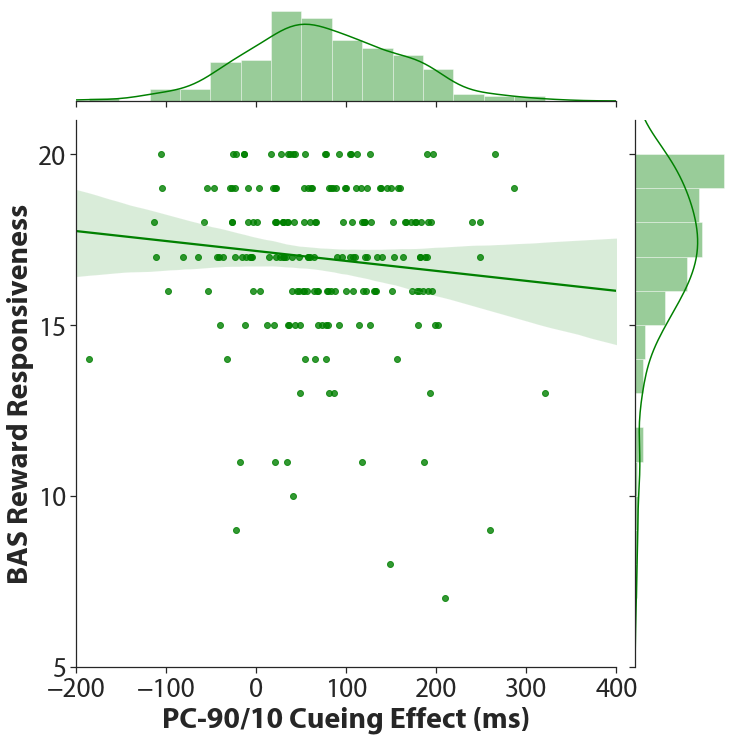

In [176]:
id_corr_graphs(SC_RT_FB.RTs,bRR.RR,'BAS Reward Responsiveness','PC-90/10 Cueing Effect (ms)',"SC_RT_RR_id.png", 1, overallMainRT.RT, -200, 400, 5, 21, 100, 5)

In [177]:
(min(SC_ACC_FB.ACC)), (max(SC_ACC_FB.ACC)), round(min(bRR.RR)), round(max(bRR.RR))

(-0.7880562060889928, 0.2564402810304449, 7, 20)

(LinregressResult(slope=1.1791856212466805, intercept=17.16993537323483, rvalue=0.10441580940010041, pvalue=0.14017160497705447, stderr=0.796175655230652),
 LinregressResult(slope=0.9670395751374063, intercept=17.160082188040327, rvalue=0.10142716117400498, pvalue=0.15194152361471602, stderr=0.6723849337259298))

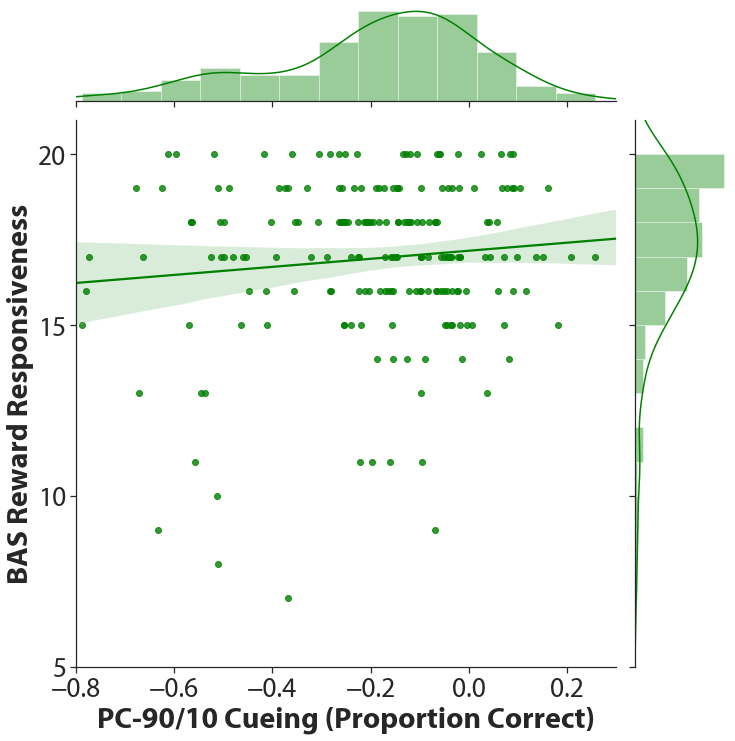

In [178]:
id_corr_graphs(SC_ACC_FB.ACC,bRR.RR,'BAS Reward Responsiveness', 'PC-90/10 Cueing (Proportion Correct)', "SC_ACC_RR_id.png", 1, overallMainACC.Accuracy, -0.8, 0.3, 5, 21, 0.2, 5)

To explore further how trait reward sensitivity might impact conflict-control, we subsequently reran the repeated-measures ANOVAs from the Learning Phase, adding the BAS reward responsiveness scores as a covariate in the analysis.

To do this, I will need to add Reward Responsiveness to my wide-form databases of RT and Accuracy and then convert those to long-form for the ANOVA analysis. Checking by hand whether or not the RR matches each person's score as listed here confirms this worked out OK.

I would also need to add block order to the RT and Accuracy wide-form dataframes, since those do not have the variable.

In [179]:
#432 is the number of data items for each person's learning phase data
res = [ele for ele in bRR.RR for i in range(432)] 

In [180]:
#because sub 89 doesn't have a bis-bas score, have to eliminate from this analysis
acdat = adat.query('(RunCounter != 0) & (subject != 89)').copy()

In [181]:
bRR = bRR.drop(['index'],axis = 1)
bRR = bRR.reset_index()

In [182]:
acdat['RR'] = res
rdat = acdat.query('(TypeOfResponse != "SCRespITI") & (RT > 200) & (RT < 1000) & (Accuracy != 0) & (StimRep != 1)').copy()

In [183]:
RT_RR = rdat.loc[rdat['Item']!='PC-50'].groupby(['subject', 'BlockType','Congruency', 'BlockOrder', 'RR'])['RT'].mean().reset_index();
ACC_RR = acdat.loc[acdat['Item']!='PC-50'].groupby(['subject', 'BlockType','Congruency', 'BlockOrder', 'RR'])['Accuracy'].mean().reset_index();
RT_RR_T = rdat.loc[rdat['Item']=='PC-50'].groupby(['subject', 'BlockType','Congruency', 'BlockOrder', 'RR'])['RT'].mean().reset_index();
ACC_RR_T = acdat.loc[acdat['Item']=='PC-50'].groupby(['subject', 'BlockType','Congruency', 'BlockOrder', 'RR'])['Accuracy'].mean().reset_index();

RT_RR.to_csv(csvpath+'RT_RR.csv')
ACC_RR.to_csv(csvpath+'ACC_RR.csv')
RT_RR_T.to_csv(csvpath+'RT_RR_T.csv')
ACC_RR_T.to_csv(csvpath+'ACC_RR_T.csv')

In [184]:
%cd "csvdata"

C:\Users\cb383\Desktop\YearFour\controllearning\LWPCtufb\data\csvdata


In [185]:
%%writefile SCAnova_RR.R

install.packages("afex",repos='https://mirrors.nics.utk.edu/cran/')
library(afex)

rawRTData <- read.csv('RT_RR.csv')
rawRTData <- within(rawRTData, {subject <- factor(subject)
BlockOrder <- factor(BlockOrder)})
aov_ez("subject", "RT", rawRTData, within = c("BlockType", "Congruency"), between = c("BlockOrder"), covariate = c("RR"), observed = c("RR"), factorize = FALSE, anova_table=list(es = "pes"))

#

rawRTData_T <- read.csv('RT_RR_T.csv')
rawRTData_T <- within(rawRTData_T, {subject <- factor(subject)
BlockOrder <- factor(BlockOrder)})
aov_ez("subject", "RT", rawRTData_T, within = c("BlockType", "Congruency"), between = c("BlockOrder"), covariate = c("RR"), observed = c("RR"), factorize = FALSE, anova_table=list(es = "pes"))

#

rawACCData <- read.csv('ACC_RR.csv')
rawACCData <- within(rawACCData, {subject <- factor(subject)
BlockOrder <- factor(BlockOrder)})
aov_ez("subject", "Accuracy", rawACCData, within = c("BlockType", "Congruency"), between = c("BlockOrder"), covariate = c("RR"), observed = c("RR"), factorize = FALSE, anova_table=list(es = "pes"))

#

rawACCData_T <- read.csv('ACC_RR_T.csv')
rawACCData_T <- within(rawACCData_T, {subject <- factor(subject)
BlockOrder <- factor(BlockOrder)})
aov_ez("subject", "Accuracy", rawACCData_T, within = c("BlockType", "Congruency"), between = c("BlockOrder"), covariate = c("RR"), observed = c("RR"), factorize = FALSE, anova_table=list(es = "pes"))

Overwriting SCAnova_RR.R


In [186]:
! Rscript SCAnova_RR.R

Anova Table (Type 3 tests)

Response: RT
                            Effect     df      MSE         F    pes p.value
1                       BlockOrder 1, 198 10341.59      1.82   .009     .18
2                               RR 1, 198 10341.59      0.07  .0003     .80
3                        BlockType 1, 198  1971.86    6.62 *    .03     .01
4             BlockOrder:BlockType 1, 198  1971.86 70.16 ***    .26  <.0001
5                     RR:BlockType 1, 198  1971.86      2.26    .01     .13
6                       Congruency 1, 198  1478.30 12.14 ***    .06   .0006
7            BlockOrder:Congruency 1, 198  1478.30    4.42 *    .02     .04
8                    RR:Congruency 1, 198  1478.30      0.01 <.0001     .92
9             BlockType:Congruency 1, 198  1725.71  11.08 **    .05    .001
10 BlockOrder:BlockType:Congruency 1, 198  1725.71    3.31 +    .02     .07
11         RR:BlockType:Congruency 1, 198  1725.71      2.49    .01     .12
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*'

Warning message:
package 'afex' is not available (for R version 3.4.3) 
Loading required package: lme4
Loading required package: Matrix
Loading required package: methods
************
Welcome to afex. For support visit: http://afex.singmann.science/
- Functions for ANOVAs: aov_car(), aov_ez(), and aov_4()
- Methods for calculating p-values with mixed(): 'KR', 'S', 'LRT', and 'PB'
- 'afex_aov' and 'mixed' objects can be passed to emmeans() for follow-up tests
- NEWS: library('emmeans') now needs to be called explicitly!
- Get and set global package options with: afex_options()
- Set orthogonal sum-to-zero contrasts globally: set_sum_contrasts()
- For example analyses see: browseVignettes("afex")
************

Attaching package: 'afex'

The following object is masked from 'package:lme4':

    lmer

Warning message:
package 'lme4' was built under R version 3.4.4 
Contrasts set to contr.sum for the following variables: BlockOrder
Warning message:
Numerical variables NOT centered on 0 (i.e.,

There was no significant main effect or interactions associated with trait reward sensitivity for RT, and the PC by congruency interaction had a smaller effect size (ηp2 = 0.02) than when BAS scores were not included. In the accuracy data, there was a trending main effect of trait reward sensitivity (F(1,198) = 3.38, p = 0.068, ηp2 = 0.02) and a significant interaction between reward sensitivity and congruency (F(1,198) = 4.97, p = 0.027, ηp2 = 0.03) as well as the expected significant interaction between reward sensitivity, PC, and congruency (F(1,198) = 7.51, p = 0.007, ηp2 = 0.04). People who had higher reward sensitivity were slightly more accurate, had smaller congruency effects, and had smaller LWPC effects. Note that a smaller LWPC effect with increasing BAS reward responsiveness contradicted our prior assumptions about the relationship between control-learning and trait reward sensitivity.

In sum, trait reward sensitivity showed weak associations with performance accuracy, including the LWPC effect, most of which were only with the unbiased “pure” control-learning items (see Supplementary Text for analysis of biased items). Overall, these analyses suggest that trait reward sensitivity may only play a small role in determining whether an individual learns control-demand associations, which in turn can be seen as discounting a motivational basis for feedback driving the LWPC in the current study.

So, let's look at now how explicitly aware participants were of the PC manipulation...

In [187]:
#from: https://stackoverflow.com/questions/6170246/how-do-i-use-matplotlib-autopct
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '({v:d})'.format(v=val)
    return my_autopct

In [188]:
from numpy import std, mean, sqrt

#correct if the population S.D. is expected to be equal for the two groups.
#from: https://stackoverflow.com/questions/21532471/how-to-calculate-cohens-d-in-python
def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (mean(x) - mean(y)) / sqrt(((nx-1)*std(x, ddof=1) ** 2 + (ny-1)*std(y, ddof=1) ** 2) / dof)

In [189]:
%cd ..

C:\Users\cb383\Desktop\YearFour\controllearning\LWPCtufb\data


In [190]:
posttest = pd.read_csv('AllSubsPostTest.csv')

In [191]:
fcdf = adat.groupby(['subject','ItemType', 'WordPresented'])['LogCounter'].mean().reset_index()

In [192]:
accuracy = []
type2 = []
for i in range(0,len(fcdf)):
    temp = posttest[posttest.subject==fcdf.subject[i]].reset_index()
    targetRow = [j for j, quest in enumerate(temp['question']) if '_{}'.format(fcdf.WordPresented[i].lower()) in quest]

    if (fcdf.ItemType[i]==1) & ('easy' in temp.data[targetRow].iloc[0].lower()):
        accuracy.append(1)
    elif (fcdf.ItemType[i]==2) & ('hard' in temp.data[targetRow].iloc[0].lower()):
        accuracy.append(1)
    elif (fcdf.ItemType[i]==3) & ('neutral' in temp.data[targetRow].iloc[0].lower()):
        accuracy.append(1)
    else: accuracy.append(0)
        
    if (fcdf.ItemType[i]<=2):
        type2.append(1)
    else: type2.append(2)

fcdf['Accuracy'] = accuracy
fcdf['ItemTypeRecoded'] = type2

In [193]:
results_final = fcdf.groupby(['subject','ItemTypeRecoded']).agg(
    {'Accuracy':['sum']}
).reset_index()

results_all = fcdf.groupby(['subject']).agg(
    {'Accuracy':['sum']}
).reset_index()

In [194]:
BlockVary = posttest.loc[posttest['question'] == 'BlockVaryQ'].data.reset_index().astype(float)
ItemVary = posttest.loc[posttest['question'] == 'ItemVaryQ'].data.reset_index().astype(float)

#### We assessed explicit awareness of the underlying task structures by asking participants whether they noticed any systematic variation in the image/Stroop trial sequences at the item and block level.

In [195]:
def mypiegraph(BlockorItem, title, figname):
    fig, ax1 = plt.subplots(figsize=(8, 7));
    if BlockorItem == 0:
        Q1 = [pd.Series.sum(ItemVary.data), len(ItemVary.data) - pd.Series.sum(ItemVary.data)];
    elif BlockorItem == 1:
        Q1 = [pd.Series.sum(BlockVary.data), len(BlockVary.data) - pd.Series.sum(BlockVary.data)];
    Q1labels = ['Yes','No'];
    plt.axis('equal');
    startanglept=90;
    radiussize=0.65;
    legendfontsize=15;
    titlefontsize=17;
    
    patches, texts, junk = ax1.pie(Q1, startangle=startanglept, radius=radiussize, autopct=make_autopct(Q1));
    ax1.legend(patches, Q1labels, loc='lower center', fontsize=legendfontsize, frameon=False);
    fig.suptitle(title, fontsize=titlefontsize,fontweight="bold", y = 0.85);
    plb.savefig(figurepath+figname, bbox_inches='tight');

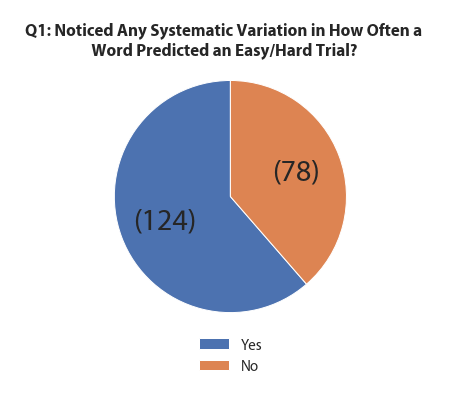

In [196]:
mypiegraph(0, 'Q1: Noticed Any Systematic Variation in How Often a\n Word Predicted an Easy/Hard Trial?', "posttestQ1_Item.png")

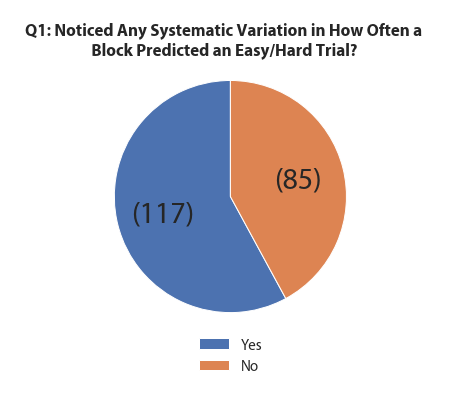

In [197]:
mypiegraph(1, 'Q1: Noticed Any Systematic Variation in How Often a\n Block Predicted an Easy/Hard Trial?', "posttestQ1_Block.png")

#### Next, we asked participants to rate how likely certain color-words would together predict the frequency of easy/congruent and hard/incongruent trials on a scale from 0 (never) to 100 (always). 

For instance, were red and orange paired together? Red and yellow? Red and green?

Were any of the color-word pairings rated as more predictive or nonpredictive than chance (50%)?

In [198]:
FP1 = posttest.loc[posttest['question'] == 'FreqPredict_1'].data.reset_index().dropna().astype(float)
FP2 = posttest.loc[posttest['question'] == 'FreqPredict_2'].data.reset_index().dropna().astype(float)
FP3 = posttest.loc[posttest['question'] == 'FreqPredict_3'].data.reset_index().dropna().astype(float)
FP4 = posttest.loc[posttest['question'] == 'FreqPredict_4'].data.reset_index().dropna().astype(float)
FP5 = posttest.loc[posttest['question'] == 'FreqPredict_5'].data.reset_index().dropna().astype(float)

In [199]:
ttest = stats.ttest_1samp(FP1.data,50)
cohens_dz = ttest[0] / sqrt(len(FP1.data))
ttest, len(FP1.data) - 1, cohens_dz

(Ttest_1sampResult(statistic=-3.3439251809812554, pvalue=0.0009853106222390152),
 201,
 -0.23527775471002083)

In [200]:
ttest = stats.ttest_1samp(FP2.data,50)
cohens_dz = ttest[0] / sqrt(len(FP2.data))
ttest, len(FP2.data) - 1, cohens_dz

(Ttest_1sampResult(statistic=-5.196049061978035, pvalue=4.981526156990376e-07),
 201,
 -0.36559273623058813)

In [201]:
ttest = stats.ttest_1samp(FP3.data,50)
cohens_dz = ttest[0] / sqrt(len(FP3.data))
ttest, len(FP3.data) - 1, cohens_dz

(Ttest_1sampResult(statistic=-4.008236911535261, pvalue=8.616281895982731e-05),
 201,
 -0.28201856496535377)

In [202]:
ttest = stats.ttest_1samp(FP4.data,50)
cohens_dz = ttest[0] / sqrt(len(FP4.data))
ttest, len(FP4.data) - 1, cohens_dz

(Ttest_1sampResult(statistic=-1.6540148743427041, pvalue=0.09968530150326299),
 201,
 -0.11637608045349089)

In [203]:
ttest = stats.ttest_1samp(FP5.data,50)
cohens_dz = ttest[0] / sqrt(len(FP5.data))
ttest, len(FP5.data) - 1, cohens_dz

(Ttest_1sampResult(statistic=-3.240181878515916, pvalue=0.0013979786159889179),
 201,
 -0.22797840142033834)

Because the color-word to PC assignment was randomized across participants, we wouldn't expect these to be more predictive than chance.

In [204]:
GRP_BT = FP1.groupby(['index'])['data'].mean() #1 is red + orange
GRP_BTSEM = pd.Series.std(GRP_BT.dropna()) / sqrt(len(GRP_BT.dropna()))
GRP_BB = FP2.groupby(['index'])['data'].mean() #2 is red + yellow
GRP_BBSEM = pd.Series.std(GRP_BB.dropna()) / sqrt(len(GRP_BB.dropna()))
GRP_BD = FP3.groupby(['index'])['data'].mean() #3 is red + green
GRP_BDSEM = pd.Series.std(GRP_BD.dropna()) / sqrt(len(GRP_BD.dropna()))
GRP_BD2 = FP4.groupby(['index'])['data'].mean() #4 is red + blue
GRP_BD2SEM = pd.Series.std(GRP_BD2.dropna()) / sqrt(len(GRP_BD2.dropna()))
GRP_BC = FP5.groupby(['index'])['data'].mean() #5 is red + purple
GRP_BCSEM = pd.Series.std(GRP_BC.dropna()) / sqrt(len(GRP_BC.dropna()))

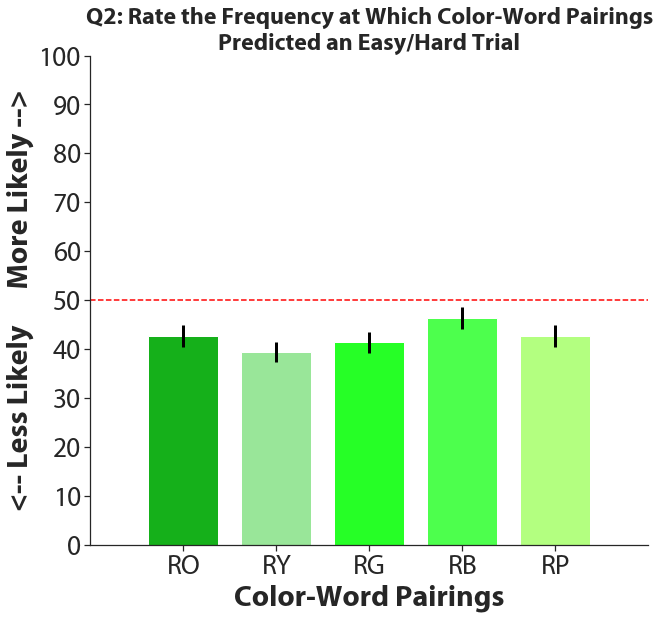

In [205]:
barwidth = 0.75; 
fig, ax = plt.subplots(figsize=(10, 9));
plt.plot([0,1,2,3,4,5,6],[50,50,50,50,50,50,50], 'r--');
rects1 = ax.bar(1,GRP_BT.dropna().mean(),barwidth,color=sns.xkcd_rgb['green'],yerr=GRP_BTSEM,ecolor='k',error_kw=dict(lw=3));
rects2 = ax.bar(2,GRP_BB.dropna().mean(),barwidth,color=(0.6,0.9,0.6),yerr=GRP_BBSEM,ecolor='k',error_kw=dict(lw=3));
rects3 = ax.bar(3,GRP_BD.dropna().mean(),barwidth,color=(0.15,1,0.15),yerr=GRP_BDSEM,ecolor='k',error_kw=dict(lw=3));
rects4 = ax.bar(4,GRP_BD2.dropna().mean(),barwidth,color=(0.3,1,0.3),yerr=GRP_BD2SEM,ecolor='k',error_kw=dict(lw=3));
rects5 = ax.bar(5,GRP_BC.dropna().mean(),barwidth,color=(0.7,1,0.5),yerr=GRP_BCSEM,ecolor='k',error_kw=dict(lw=3));
ax.set_ylim(0,100);
ax.set_xlim(0,6);
ax.set_xticklabels(('RO','RY','RG','RB','RP'));
ax.set_xticks([1, 2, 3, 4, 5]);
ax.set_yticks(np.arange(0, 101, 10));
plt.title('Q2: Rate the Frequency at Which Color-Word Pairings\nPredicted an Easy/Hard Trial', fontsize=24,fontweight="bold");
plt.ylabel('<-- Less Likely      More Likely -->', fontweight="bold");
plt.xlabel('Color-Word Pairings',fontweight="bold");
sns.despine();

plb.savefig(figurepath+"posttestQ2.png", bbox_inches='tight');

#### Participants were then asked to match the color-words to the Stroop trial type that they most likely preceded. Did they perform better than chance (i.e., 2/6 cue-demand relationships correctly matched)? Chance here is 2/6 correct because the options were hard/incongruent, easy/congruent, and neutral; we put both the biased and unbiased items together in the SCForcedChoice question.

##### Note that we also separate out the biased images post-test question (testing against chance then as 4/3) and the unbiased images post-test question (testing against chance as 2/3).

In [206]:
ttest = stats.ttest_1samp(results_all.Accuracy,2)
cohens_dz = ttest[0] / sqrt(len(results_all.Accuracy))
ttest, len(results_all.Accuracy) - 1, cohens_dz, np.mean(results_all.Accuracy)

(Ttest_1sampResult(statistic=array([8.87566562]), pvalue=array([3.8568869e-16])),
 201,
 array([0.62448965]),
 sum    3.118812
 dtype: float64)

In [207]:
ttest = stats.ttest_1samp(results_final.loc[results_final['ItemTypeRecoded']==1].Accuracy,(4/3))
cohens_dz = ttest[0] / sqrt(len(results_final.loc[results_final['ItemTypeRecoded']==1].Accuracy))
ttest, len(results_final.loc[results_final['ItemTypeRecoded']==1].Accuracy) - 1, cohens_dz, np.mean(results_final.loc[results_final['ItemTypeRecoded']==1].Accuracy)

(Ttest_1sampResult(statistic=array([11.98840427]), pvalue=array([2.46843691e-25])),
 201,
 array([0.84350118]),
 sum    2.475248
 dtype: float64)

In [208]:
ttest = stats.ttest_1samp(results_final.loc[results_final['ItemTypeRecoded']==2].Accuracy,(2/3))
cohens_dz = ttest[0] / sqrt(len(results_final.loc[results_final['ItemTypeRecoded']==2].Accuracy))
ttest, len(results_final.loc[results_final['ItemTypeRecoded']==2].Accuracy) - 1, cohens_dz, np.mean(results_final.loc[results_final['ItemTypeRecoded']==2].Accuracy)

(Ttest_1sampResult(statistic=array([-0.41747413]), pvalue=array([0.67677722])),
 201,
 array([-0.02937338]),
 sum    0.643564
 dtype: float64)

That the overall grouping is significant and the biased grouping significant, but not the unbiased, suggests that the increased PC from the biased grouping is what drives the increased recognition. This is consistent with Blais et al. (2012) suggesting that the more extreme the PC manipulation, the more explicitly aware participants are of the manipulation.

# Memory Data Analysis

`TypeofResponse` is similar to what it was in the Learning Phase: `MemRespITI` means the participant didn't respond within the 2 second deadline to identify whether the image was old or new.

`Version` is the variable from the Learning Phase. `LogCounter`, `TrialCounter`, and `MatrixCounter` serve the same purpose as they did in the Learning Phase.

`RunCounter`: here there were 2 runs, with half the images shown in one block and the other half in the other block. New and Old images were intermixed in both blocks equally.

`ImagePresented` indicates which image was shown, which is important to linking with the Learning Phase data.

`Memorymatrix` is 1 when it's a new image and 2 when it's an old image.

`keyPressed` is what participants presesed. a/A represented Old (previously seen), and l/L represented New (never seen).

`RT` is how fast they identified the image as Old or New.

`Hit` is an old image identified as Old.

`FA` is a new image identified as Old.

`CR` is a new image identified as New.

`Miss` is an old image identified as New.

`subject` self-explanatory. `population` is the same as in the Learning Phase data - 1 for MTurk workers and 2 for undergraduate students.

In [209]:
Memorydat = pd.read_csv('AllSubsMemory.csv')
mdat = Memorydat.copy()

In [210]:
#sub 186 has no memory data, memorymatrix = 2 means the old data
LPdata = adat.query('(subject != 186)').copy()
Memdata = mdat.query('(Memorymatrix == 2 & subject != 186)').copy()

LPdata = LPdata.reset_index()
Memdata = Memdata.reset_index()

In [211]:
LPdata = LPdata.rename(columns={"Version":"LPVersion", "TypeOfResponse":"LPTypeOfResponse", "LogCounter":"LPLogCounter","TrialCounter":"LPTrialCounter", "MatrixCounter":"LPMatrixCounter", "RunCounter":"LPRunCounter", "subject": "LPsubject", "ImagePresented":"LPImages", "population": "LPpop", "RT": "LPRT"})

In [212]:
Memorydata = pd.concat([Memdata,LPdata],axis=1,sort=False,join="inner")

In [213]:
Memorydata.to_csv('Memorydata.csv');

Exclude memory trials without a response, with a cognitively fast response (RT < 200).

In [214]:
mdat_old_all = mdat.query('(TypeOfResponse != "MemRespITI") & (RT > 200) & (Memorymatrix == 2)').copy()
mdat_new_all = mdat.query('(TypeOfResponse != "MemRespITI") & (RT > 200) & (Memorymatrix == 1)').copy()

In [215]:
oldrate_all = mdat_old_all.groupby(['subject'])['Hit'].mean().reset_index();
newrate_all = mdat_new_all.groupby(['subject'])['FA'].mean().reset_index();

In [216]:
oldrate_all.Hit.mean()
newrate_all.FA.mean()

0.3677320099990926

0.27853297281100586

In [217]:
ttest = stats.ttest_rel(oldrate_all.Hit, newrate_all.FA)
cohens_dz = ttest[0] / sqrt(len(newrate_all.FA))
ttest,len(newrate_all.FA) - 1, cohens_dz

(Ttest_relResult(statistic=14.055805513151265, pvalue=1.1552949809018057e-31),
 200,
 0.991420079606236)

subject 63 had a 0 false alarm rate, so replaced with 1/N-1

In [218]:
newrate_all = newrate_all.replace(to_replace=0, value = 1/(len(newrate_all.FA)-1))

In [219]:
from scipy.stats import norm
import math
Z = norm.ppf
dprime = Z(oldrate_all.Hit) - Z(newrate_all.FA)

In [220]:
dprime.mean()

0.3115934945241037

In [221]:
dprime = pd.DataFrame({'dprime': dprime})
dprime = dprime.reset_index()

Now make sure to exclude incorrect trials.

All subsequent analyses focus on memory performance as a function of Learning Phase factors. Because we were interested in understanding how intrinsic reinforcement shapes learned control associations, we examined only the trials on which participants had responded correctly. Memory would otherwise potentially be confounded by the type of feedback reinforcement received on a given trial (correct vs. incorrect).

In [222]:
#memory data is already filtered to only old images
mdat3 = Memorydata.query('(TypeOfResponse != "MemRespITI") & (RT > 200) & (Accuracy == 1)').copy()

In analyzing incidental memory of reinforcement events, we combined data across biased and unbiased items. The list-wise context, which is created by the biased items, induces the learned recruitment of control-demand for unbiased items (as supported by the correlation analysis, above). Reinforcement following the biased items serves to reinforce the induced list-wise context, and reinforcement following the unbiased items serves to reinforce the generalization of the control-demand associations. Thus, in understanding how reinforcement shapes control-learning, we collapse across both metrics of control-learning.

In [223]:
%cd csvdata

C:\Users\cb383\Desktop\YearFour\controllearning\LWPCtufb\data\csvdata


In [224]:
countexcl = mdat3.groupby(['subject','BlockType','Congruency','BlockOrder'])['Hit'].count().reset_index()

Will catch anyone with <10 observations in the cells. If the groupby fxn has summarized and the participant has NA cells, then the ANOVA will just exclude them from the analysis anyway.

In [225]:
exclhit = [];
for i in range(0,len(countexcl)):
    sub = countexcl.Hit.reset_index()
    
    if (sub.Hit[i] < 10):
        exclhit.append(1)
    else: exclhit.append(0)
        
countexcl['exclhit'] = exclhit

In [226]:
HitcountComb = (countexcl[countexcl.exclhit == 1].subject).reset_index()

In [227]:
Hit_AnovaComb = mdat3.loc[~mdat3['subject'].isin(HitcountComb.subject)].loc[mdat3['subject'] != 40].groupby(['subject','BlockType','Congruency','BlockOrder'])['Hit'].mean().reset_index()
Hit_AnovaComb.to_csv(csvpath+'Hit_AnovaComb.csv')

In [228]:
%%writefile HitAnovaComb.R

install.packages("afex",repos='https://mirrors.nics.utk.edu/cran/')
library(afex)

rawHitdata <- read.csv('Hit_AnovaComb.csv')
aov_car(Hit ~ BlockOrder + Error(subject/(BlockType*Congruency)), data = rawHitdata, anova_table = list(es = "pes"))

Overwriting HitAnovaComb.R


In [229]:
! Rscript HitAnovaComb.R

Anova Table (Type 3 tests)

Response: Hit
                           Effect     df  MSE         F   pes p.value
1                      BlockOrder 1, 187 0.11      0.34  .002     .56
2                       BlockType 1, 187 0.02      0.07 .0003     .80
3            BlockOrder:BlockType 1, 187 0.02 18.24 ***   .09  <.0001
4                      Congruency 1, 187 0.00      1.68  .009     .20
5           BlockOrder:Congruency 1, 187 0.00      0.03 .0002     .86
6            BlockType:Congruency 1, 187 0.00      0.05 .0003     .82
7 BlockOrder:BlockType:Congruency 1, 187 0.00   8.97 **   .05    .003
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '+' 0.1 ' ' 1


Warning message:
package 'afex' is not available (for R version 3.4.3) 
Loading required package: lme4
Loading required package: Matrix
Loading required package: methods
************
Welcome to afex. For support visit: http://afex.singmann.science/
- Functions for ANOVAs: aov_car(), aov_ez(), and aov_4()
- Methods for calculating p-values with mixed(): 'KR', 'S', 'LRT', and 'PB'
- 'afex_aov' and 'mixed' objects can be passed to emmeans() for follow-up tests
- NEWS: library('emmeans') now needs to be called explicitly!
- Get and set global package options with: afex_options()
- Set orthogonal sum-to-zero contrasts globally: set_sum_contrasts()
- For example analyses see: browseVignettes("afex")
************

Attaching package: 'afex'

The following object is masked from 'package:lme4':

    lmer

Warning message:
package 'lme4' was built under R version 3.4.4 
Contrasts set to contr.sum for the following variables: BlockOrder


We ran a repeated-measures ANOVA on Hit Rates for feedback images across the entire dataset, probing how sensitivity to performance feedback varied as a function of the experimental factors within the Learning Phase. This allowed us to assess the prediction of the context-binding hypothesis that memory should be superior for feedback of context-defining items, and superior for feedback within the mostly incongruent context (or after incongruent trials) under the motivation hypothesis. 

We found a significant interaction between block order and PC context for memory of feedback images (F(1,187) = 18.24, p < 0.001, ηp2 = 0.09, inclusion BF = 1.32 x 107). Participants who experienced the mostly congruent context first displayed a stronger context-dependent effect on memory: they better remembered images from the PC-75 context (Mdiff = 0.06), while participants who experienced the mostly incongruent context first had a smaller tendency for better memory from the PC-25 context (Mdiff = 0.02). Finally, this interaction was also moderated by congruency (F(1,187) = 8.97, p = 0.003, ηp2 = 0.05, inclusion BF = 0.53): participants better remembered images following congruent trials from the PC-75 context if they experienced the mostly congruent context first (Mdiff = 0.02 vs. -0.004) and better remembered incongruent trials from the PC-25 context if they experienced the mostly incongruent context first (Mdiff = 0.02 vs. -0.007). No other effects were trending (F < 1.67). 

These context-dependent memory effects indicate that participants generally had better memory for feedback from context-defining trials, supporting one of the predictions of the context-binding hypothesis, qualified by block order and PC context: participants remembered images better from the trial that defined the first context they experienced, and this effect was more pronounced for participants whose first context was mostly congruent. This data pattern is not compatible with the intrinsic motivation hypothesis, which would suggest superior memory for feedback images following successful (correctly responded to) incongruent trials.

In [230]:
def mem_bar_plot(x,xlabel,hue,huetitle,data, title, imagetitle, dv, dvlabel, ymin, ymax, stepsize):
    g = sns.catplot(x=x, y=dv, hue=hue,data=data,palette=("Set2"),ci=68,kind="bar",height=10, aspect=0.7,saturation=0.6,legend_out = True);
    g.set_axis_labels(xlabel, dvlabel);
    g.despine(left=True);

    # check axes and find which have legends
    for ax in g.axes.flat:
        leg = g.axes.flat[0].get_legend()
        if not leg is None: 
            break

    # or legend may be on a figure
    if leg is None: 
        leg = g._legend

    leg.set_title(huetitle);
    g.set(ylim=(ymin, ymax), yticks=np.arange(ymin,ymax+stepsize,stepsize))
    g.fig.suptitle(title, y = 1.05)

    plb.savefig(figurepath+imagetitle, dpi=300, bbox_inches='tight')

In [231]:
HitANOVA_graph = mdat3.loc[~mdat3['subject'].isin(HitcountComb.subject)].groupby(['subject','BlockType','BlockOrder'])['Hit'].mean().reset_index()

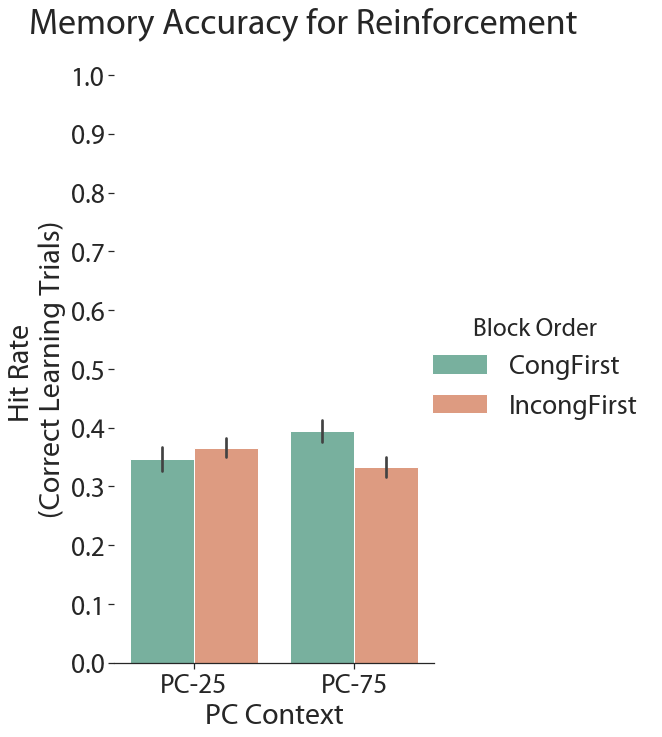

In [232]:
mem_bar_plot('BlockType','PC Context', 'BlockOrder', 'Block Order', HitANOVA_graph,"Memory Accuracy for Reinforcement", "Hit_ANOVA.png", "Hit", "Hit Rate \n(Correct Learning Trials)", 0, 1.0, 0.1)

Means for the ANOVA in the manuscript

In [233]:
#block order x PC
BOPC=mdat3.loc[~mdat3['subject'].isin(HitcountComb.subject)].groupby(['subject','BlockOrder', 'BlockType'])['Hit'].mean().reset_index()
PC75_CFminusIF = BOPC.loc[BOPC['BlockType'] == 'PC-75'].loc[BOPC['BlockOrder'] == 'CongFirst'].reset_index()['Hit'] - BOPC.loc[BOPC['BlockType'] == 'PC-75'].loc[BOPC['BlockOrder'] == 'IncongFirst'].reset_index()['Hit']
PC25_CFminusIF = BOPC.loc[BOPC['BlockType'] == 'PC-25'].loc[BOPC['BlockOrder'] == 'CongFirst'].reset_index()['Hit'] - BOPC.loc[BOPC['BlockType'] == 'PC-25'].loc[BOPC['BlockOrder'] == 'IncongFirst'].reset_index()['Hit']
(PC75_CFminusIF.mean()), (PC25_CFminusIF.mean())

#congruency x block type x block order
PopBO=mdat3.loc[~mdat3['subject'].isin(HitcountComb.subject)].groupby(['subject','BlockType', 'Congruency', 'BlockOrder'])['Hit'].mean().reset_index()
MC_Cong_CF = PopBO.loc[PopBO['BlockType'] == 'PC-75'].loc[PopBO['Congruency'] == 'Incongruent'].loc[PopBO['BlockOrder'] == 'CongFirst'].reset_index()['Hit'] - PopBO.loc[PopBO['BlockType'] == 'PC-75'].loc[PopBO['Congruency'] == 'Congruent'].loc[PopBO['BlockOrder'] == 'CongFirst'].reset_index()['Hit']
MC_Cong_IF = PopBO.loc[PopBO['BlockType'] == 'PC-75'].loc[PopBO['Congruency'] == 'Incongruent'].loc[PopBO['BlockOrder'] == 'IncongFirst'].reset_index()['Hit'] - PopBO.loc[PopBO['BlockType'] == 'PC-75'].loc[PopBO['Congruency'] == 'Congruent'].loc[PopBO['BlockOrder'] == 'IncongFirst'].reset_index()['Hit']
MIC_Cong_CF = PopBO.loc[PopBO['BlockType'] == 'PC-25'].loc[PopBO['Congruency'] == 'Incongruent'].loc[PopBO['BlockOrder'] == 'CongFirst'].reset_index()['Hit'] - PopBO.loc[PopBO['BlockType'] == 'PC-25'].loc[PopBO['Congruency'] == 'Congruent'].loc[PopBO['BlockOrder'] == 'CongFirst'].reset_index()['Hit']
MIC_Cong_IF = PopBO.loc[PopBO['BlockType'] == 'PC-25'].loc[PopBO['Congruency'] == 'Incongruent'].loc[PopBO['BlockOrder'] == 'IncongFirst'].reset_index()['Hit'] - PopBO.loc[PopBO['BlockType'] == 'PC-25'].loc[PopBO['Congruency'] == 'Congruent'].loc[PopBO['BlockOrder'] == 'IncongFirst'].reset_index()['Hit']
(MC_Cong_CF.mean(), MC_Cong_IF.mean()), (MIC_Cong_CF.mean(), MIC_Cong_IF.mean())

(0.06218977445497723, -0.019221325408109058)

((-0.01765449842956416, 0.003553816067435016),
 (0.006918605369377056, -0.01867592708208351))

To test whether the block order by PC context interaction reflected the possibility that most learning from feedback might occur early on in the task, we reran the ANOVA on Hit rates from blocks 1 and 2 only. As with the Learning Phase analyses above, we here drop the within-participants PC context factor (as we only include the initial context for each participant). The block order factor thus becomes a between-participants PC factor, allowing us to contrast reinforcement sensitivity between the MC and MIC contexts in the absence of context order effects. 

In [234]:
Hit_r1Comb = mdat3.loc[mdat3['Time'] == 'Early'].groupby(['subject','Congruency','BlockOrder'])['Hit'].count().reset_index()

In [235]:
exclhit = [];
for i in range(0,len(Hit_r1Comb)):
    sub = Hit_r1Comb.Hit.reset_index()
    
    if (sub.Hit[i] < 10):
        exclhit.append(1)
    else: exclhit.append(0)
        
Hit_r1Comb['exclhit'] = exclhit

In [236]:
r1countComb = (Hit_r1Comb[Hit_r1Comb.exclhit == 1].subject).reset_index()

In [237]:
Hit_Anova_r1Comb = mdat3.loc[mdat3['Time'] == 'Early'].loc[~mdat3['subject'].isin(r1countComb.subject)].groupby(['subject','Congruency','BlockOrder'])['Hit'].mean().reset_index()
Hit_Anova_r1Comb.to_csv(csvpath+'Hit_Anova_r1Comb.csv')

In [238]:
%%writefile HitAnova_r1Comb.R

install.packages("afex",repos='https://mirrors.nics.utk.edu/cran/')
library(afex)

rawHitdata_r1 <- read.csv('Hit_Anova_r1Comb.csv')
aov_car(Hit ~ BlockOrder + Error(subject/(Congruency)), data = rawHitdata_r1, anova_table = list(es = "pes"))

Overwriting HitAnova_r1Comb.R


In [239]:
! Rscript HitAnova_r1Comb.R

Anova Table (Type 3 tests)

Response: Hit
                 Effect     df  MSE       F  pes p.value
1            BlockOrder 1, 192 0.06    0.71 .004     .40
2            Congruency 1, 192 0.00 9.48 **  .05    .002
3 BlockOrder:Congruency 1, 192 0.00    0.21 .001     .64
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '+' 0.1 ' ' 1


Warning message:
package 'afex' is not available (for R version 3.4.3) 
Loading required package: lme4
Loading required package: Matrix
Loading required package: methods
************
Welcome to afex. For support visit: http://afex.singmann.science/
- Functions for ANOVAs: aov_car(), aov_ez(), and aov_4()
- Methods for calculating p-values with mixed(): 'KR', 'S', 'LRT', and 'PB'
- 'afex_aov' and 'mixed' objects can be passed to emmeans() for follow-up tests
- NEWS: library('emmeans') now needs to be called explicitly!
- Get and set global package options with: afex_options()
- Set orthogonal sum-to-zero contrasts globally: set_sum_contrasts()
- For example analyses see: browseVignettes("afex")
************

Attaching package: 'afex'

The following object is masked from 'package:lme4':

    lmer

Warning message:
package 'lme4' was built under R version 3.4.4 
Contrasts set to contr.sum for the following variables: BlockOrder


Here, we found a significant main effect of congruency (F(1,192) = 9.48, p = 0.002, ηp2 = 0.05, inclusion BF = 9.81; all other effects, F < 0.72). Participants were better at remembering feedback images following congruent trials (M = 0.39) than incongruent trials (M = 0.37). This suggests that contrary to the prediction of the motivation hypothesis, especially early in the task, participants were more sensitive to reinforcement for congruent trials.

In [240]:
#congruency
maineffectCong=mdat3.loc[mdat3['Time'] == 'Early'].loc[~mdat3['subject'].isin(r1countComb.subject)].groupby(['subject','Congruency'])['Hit'].mean()
grpmean = pd.Series.mean(maineffectCong, level=1)
(grpmean), grpmean[1] - grpmean[0]

(Congruency
 Congruent      0.389557
 Incongruent    0.369961
 Name: Hit, dtype: float64, -0.019596003228507186)

In [241]:
MECong = maineffectCong.reset_index()
Congtrials = MECong.loc[MECong['Congruency']=='Congruent'].reset_index()
Incongtrials = MECong.loc[MECong['Congruency']=='Incongruent'].reset_index()

np.random.seed(321)
xj = np.random.normal(0.5, 0.045, len(Congtrials.subject))
xj_2 = np.random.normal(1, 0.045, len(Incongtrials.subject))

Congtrials['xj'] = xj;
Incongtrials['xj'] = xj_2;

Congmean = Congtrials.Hit.mean()
ICmean = Incongtrials.Hit.mean()
Congstd = Congtrials.Hit.std()
ICstd = Incongtrials.Hit.std()
Congse = Congstd/np.sqrt(len(Congtrials))
ICse = ICstd/np.sqrt(len(Incongtrials))

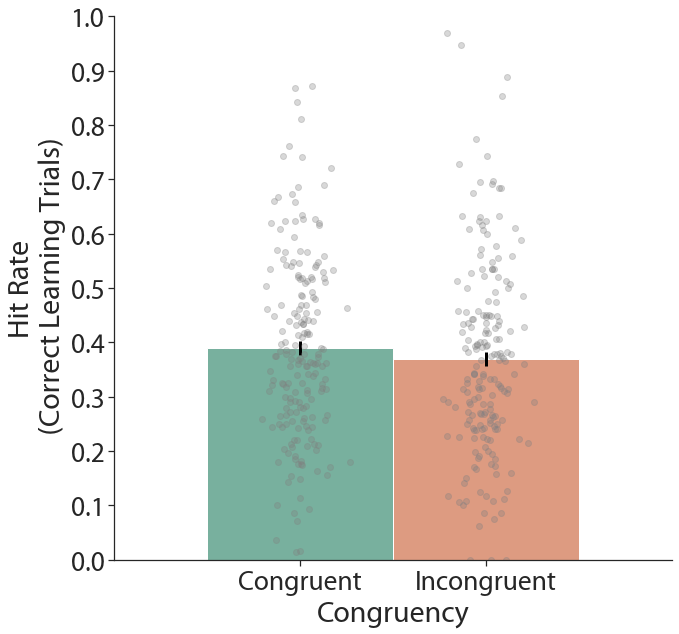

In [242]:
barwidth = 0.5; 
fig, ax = plt.subplots(figsize=(10, 10));
rects1 = ax.bar(0.50,Congmean,barwidth,color='#78b09e',yerr=Congse,ecolor='k',error_kw=dict(lw=3));
rects2 = ax.bar(1,ICmean,barwidth,color='#dd9b81',yerr=ICse,ecolor='k',error_kw=dict(lw=3));
plt.plot(Congtrials.xj,Congtrials.Hit,'o', color='grey', alpha=0.3)
plt.plot(Incongtrials.xj,Incongtrials.Hit,'o', color='grey', alpha=0.3)
ax.set_ylim(0,1.0);
ax.set_xlim(0,1.50);
ax.set_xticklabels(('Congruent','Incongruent'));
ax.set_xticks([0.50, 1]);
ax.set_yticks(np.arange(0, 1.01, 0.1));
plt.ylabel('Hit Rate\n (Correct Learning Trials)');
plt.xlabel('Congruency');
sns.despine();

plb.savefig(figurepath+"success_cong_early.png", dpi=300, bbox_inches='tight');

Finally, a core assumption underlying the control-learning perspective is that people adapt to changes in contextual control demand, which implies that learning should be taking place when moving from one PC context to another. This assumption would predict more attention to feedback when new control demands are being learned, that is, at the beginning of each context. Accordingly, we reanalyzed the data to focus on the “context shifts”, i.e., the first block in which participants experienced a new PC context. Here, we thus grouped blocks 1 and 3 together as the “first” blocks of each context and blocks 2 and 4 as the “last” blocks of each context, and dropped the within-participants PC factor within the analysis, since the new context shift factor and the block order factor already carry the PC information.

In [243]:
Hit_CHComb = mdat3.groupby(['subject','ContextHalf','Congruency','BlockOrder'])['Hit'].count().reset_index()

In [244]:
exclhit = [];
for i in range(0,len(Hit_CHComb)):
    sub = Hit_CHComb.Hit.reset_index()
    
    if (sub.Hit[i] < 10):
        exclhit.append(1)
    else: exclhit.append(0)
        
Hit_CHComb['exclhit'] = exclhit

In [245]:
CHcountComb = (Hit_CHComb[Hit_CHComb.exclhit == 1].subject).reset_index()

In [246]:
Hit_Anova_CHComb = mdat3.loc[~mdat3['subject'].isin(CHcountComb.subject)].groupby(['subject','ContextHalf','Congruency','BlockOrder'])['Hit'].mean().reset_index()
Hit_Anova_CHComb.to_csv(csvpath+'Hit_Anova_CHComb.csv')

In [247]:
%%writefile HitAnova_CHComb.R

install.packages("afex",repos='https://mirrors.nics.utk.edu/cran/')
library(afex)

rawHitdata_CH <- read.csv('Hit_Anova_CHComb.csv')
aov_car(Hit ~ BlockOrder + Error(subject/(Congruency*ContextHalf)), data = rawHitdata_CH, anova_table = list(es = "pes"))

Overwriting HitAnova_CHComb.R


In [248]:
! Rscript HitAnova_CHComb.R

Anova Table (Type 3 tests)

Response: Hit
                             Effect     df  MSE         F  pes p.value
1                        BlockOrder 1, 191 0.11      1.14 .006     .29
2                        Congruency 1, 191 0.01      1.27 .007     .26
3             BlockOrder:Congruency 1, 191 0.01 12.87 ***  .06   .0004
4                       ContextHalf 1, 191 0.01 50.89 ***  .21  <.0001
5            BlockOrder:ContextHalf 1, 191 0.01      0.88 .005     .35
6            Congruency:ContextHalf 1, 191 0.00      1.21 .006     .27
7 BlockOrder:Congruency:ContextHalf 1, 191 0.00 12.33 ***  .06   .0006
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '+' 0.1 ' ' 1


Warning message:
package 'afex' is not available (for R version 3.4.3) 
Loading required package: lme4
Loading required package: Matrix
Loading required package: methods
************
Welcome to afex. For support visit: http://afex.singmann.science/
- Functions for ANOVAs: aov_car(), aov_ez(), and aov_4()
- Methods for calculating p-values with mixed(): 'KR', 'S', 'LRT', and 'PB'
- 'afex_aov' and 'mixed' objects can be passed to emmeans() for follow-up tests
- NEWS: library('emmeans') now needs to be called explicitly!
- Get and set global package options with: afex_options()
- Set orthogonal sum-to-zero contrasts globally: set_sum_contrasts()
- For example analyses see: browseVignettes("afex")
************

Attaching package: 'afex'

The following object is masked from 'package:lme4':

    lmer

Warning message:
package 'lme4' was built under R version 3.4.4 
Contrasts set to contr.sum for the following variables: BlockOrder


We observed larger Hit rates for “first” context blocks (M = 0.38) relative to the “last” context blocks (M = 0.34) (F(1,191) = 50.89, p < 0.001, ηp2 = 0.21, inclusion BF = 9.13 x 109). This effect supports the notion that participants paid more attention to reinforcement events when a context was new (at the beginning of the task and when the context changes) or – put a different way – that they became less sensitive or attentive towards reinforcement later in the blocks within each PC context, when adaptation to the current level of control demand had presumably been achieved. 

However, we also observed evidence of context-dependent shifts in attention towards reinforcement: there was both a significant block order by congruency interaction (F(1,191) = 12.87, p < 0.001, ηp2 = 0.06, inclusion BF = 268.02) and a block order by congruency by context shift interaction (F(1,191) = 12.33, p < 0.001, ηp2 = 0.06, inclusion BF = 5.28; all other effects, F < 1.28). Recapitulating the effects reported in the previous analysis, participants who experienced the mostly congruent context first showed better memory for images following congruent trials (M = 0.03), while participants who experienced the mostly incongruent context first showed better memory for images following incongruent trials (M = 0.02). Participants were thus most sensitive to reinforcement for trials that were most frequent in the context they experienced first, i.e., the trials that established the context, and this effect faded over time. As shown in the figure below, participants showed the memory benefit for images following the most frequent trial type from their first context in early blocks (MC first: M = 0.05; MIC first: M = 0.02). This context-dependent benefit for memory diminished in the later context shifts (MC first: M = 0.01; MIC first: M = 0.00).


In [249]:
#context half
maineffectCH=mdat3.loc[~mdat3['subject'].isin(CHcountComb.subject)].groupby(['subject','ContextHalf'])['Hit'].mean()
grpmean = pd.Series.mean(maineffectCH, level=1)
(grpmean), grpmean[1] - grpmean[0]

#block order x congruency
BOCong=mdat3.loc[~mdat3['subject'].isin(CHcountComb.subject)].groupby(['subject','BlockOrder', 'Congruency'])['Hit'].mean().reset_index()
CongFirstCong = BOCong.loc[BOCong['Congruency'] == 'Incongruent'].loc[BOCong['BlockOrder'] == 'CongFirst'].reset_index()['Hit'] - BOCong.loc[BOCong['Congruency'] == 'Congruent'].loc[BOCong['BlockOrder'] == 'CongFirst'].reset_index()['Hit']
IncongFirstCong = BOCong.loc[BOCong['Congruency'] == 'Incongruent'].loc[BOCong['BlockOrder'] == 'IncongFirst'].reset_index()['Hit'] - BOCong.loc[BOCong['Congruency'] == 'Congruent'].loc[BOCong['BlockOrder'] == 'IncongFirst'].reset_index()['Hit']
(CongFirstCong.mean()), (IncongFirstCong.mean())

#block order x congruency x context half
BOCongCH=mdat3.loc[~mdat3['subject'].isin(CHcountComb.subject)].groupby(['subject','ContextHalf', 'Congruency', 'BlockOrder'])['Hit'].mean().reset_index()
MC_Cong_E = BOCongCH.loc[BOCongCH['ContextHalf'] == 'Early'].loc[BOCongCH['Congruency'] == 'Incongruent'].loc[BOCongCH['BlockOrder'] == 'CongFirst'].reset_index()['Hit'] - BOCongCH.loc[BOCongCH['ContextHalf'] == 'Early'].loc[BOCongCH['Congruency'] == 'Congruent'].loc[BOCongCH['BlockOrder'] == 'CongFirst'].reset_index()['Hit']
MIC_Cong_E = BOCongCH.loc[BOCongCH['ContextHalf'] == 'Early'].loc[BOCongCH['Congruency'] == 'Incongruent'].loc[BOCongCH['BlockOrder'] == 'IncongFirst'].reset_index()['Hit'] - BOCongCH.loc[BOCongCH['ContextHalf'] == 'Early'].loc[BOCongCH['Congruency'] == 'Congruent'].loc[BOCongCH['BlockOrder'] == 'IncongFirst'].reset_index()['Hit']
MC_Cong_L = BOCongCH.loc[BOCongCH['ContextHalf'] == 'Late'].loc[BOCongCH['Congruency'] == 'Incongruent'].loc[BOCongCH['BlockOrder'] == 'CongFirst'].reset_index()['Hit'] - BOCongCH.loc[BOCongCH['ContextHalf'] == 'Late'].loc[BOCongCH['Congruency'] == 'Congruent'].loc[BOCongCH['BlockOrder'] == 'CongFirst'].reset_index()['Hit']
MIC_Cong_L = BOCongCH.loc[BOCongCH['ContextHalf'] == 'Late'].loc[BOCongCH['Congruency'] == 'Incongruent'].loc[BOCongCH['BlockOrder'] == 'IncongFirst'].reset_index()['Hit'] - BOCongCH.loc[BOCongCH['ContextHalf'] == 'Late'].loc[BOCongCH['Congruency'] == 'Congruent'].loc[BOCongCH['BlockOrder'] == 'IncongFirst'].reset_index()['Hit']
(MC_Cong_E.mean(), MIC_Cong_E.mean()), (MC_Cong_L.mean(), MIC_Cong_L.mean())

(ContextHalf
 Early    0.382094
 Late     0.342552
 Name: Hit, dtype: float64, -0.03954281176674235)

(-0.026817859460809803, 0.015499629577730897)

((-0.04717318385373634, 0.024630184938087617),
 (-0.00865031388886498, 0.004501950216274639))

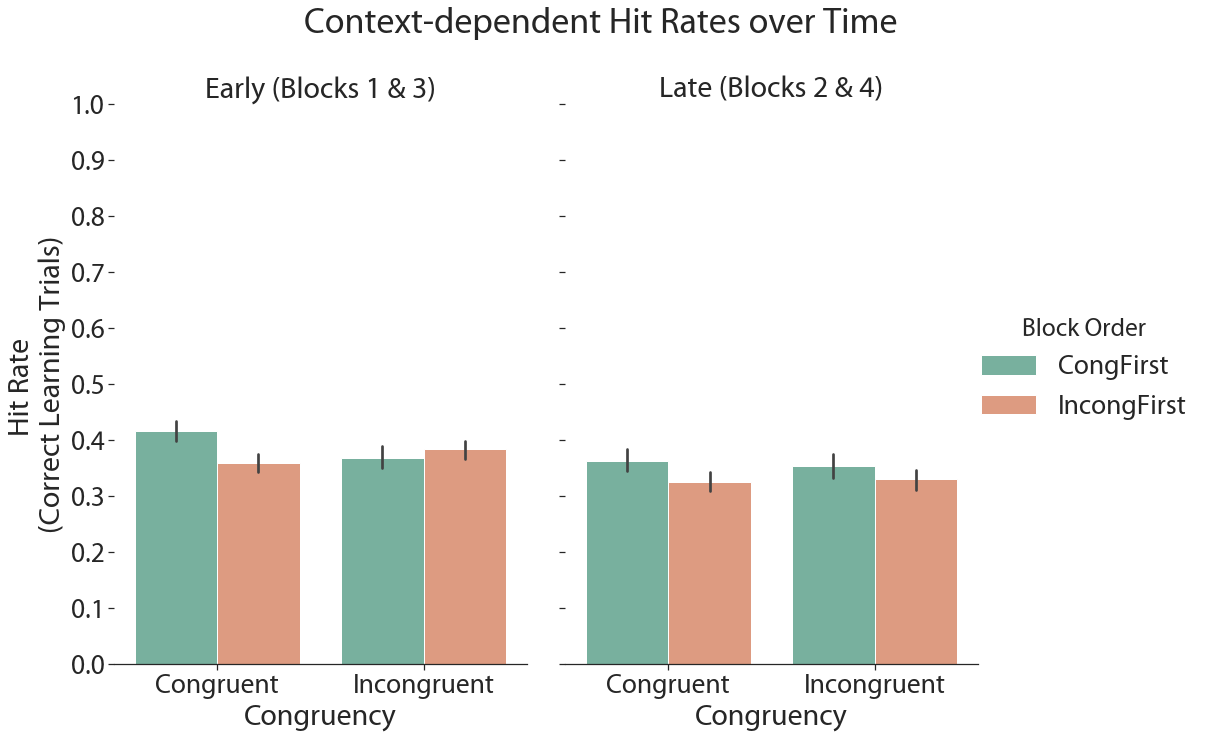

In [250]:
mybargraph('Congruency','Hit','BlockOrder',['Congruent','Incongruent'],'ContextHalf',["Early (Blocks 1 & 3)", "Late (Blocks 2 & 4)"],BOCongCH,'Congruency','Hit Rate \n(Correct Learning Trials)','Context-dependent Hit Rates over Time','Block Order',0,1.0,'Hit_CH_BOCong.png',0.1)